# Attention-Weighted

## Initialization

In [4]:
import random
import torch
import warnings
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from visionts import VisionTS
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from visionts.models_mae import MaskedAutoencoderViT
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

d:\OneDrive - Dialog Axiata PLC\STUDIES\MSC\Sem 3\PG Dip Project CS5999\BiViSIONTS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Common Helper Functions

In [7]:
def cal_metrics(y, forecast):
    '''  Calculate metrics '''
    
    mse = mean_squared_error(y, forecast)
    mae = mean_absolute_error(y, forecast)
    rmse = np.sqrt(mse)
    
    # success = (np.abs(forecast - y) <= 0.10 * np.abs(y)).sum() / len(y)
    # success = (np.abs((forecast - y) / y) <= 0.05).sum() / len(y)
    
    # mape = np.mean(np.abs((y - forecast) / y)) * 100
    # success= (100 - mape)/100
    
    # Weighted MAPE - stable and less sensitive to outliers
    wmape = np.sum(np.abs(y - forecast)) / np.sum(np.abs(y)) * 100
    success = (100 - wmape) / 100
    
    return mse, mae, rmse, success

## Section 1: MAE Model with Attention-Weighted Bivariate Encoding


### Helper Functions

In [10]:
def bivariate_attention_weighted_image(series1, series2, context_len, pred_len, periodicity=24):
    """
    BiViSION Attention-Weighted Fusion Method:
    - Red Channel: Variable 1 (Traffic)
    - Green Channel: Variable 2 (Users)
    - Blue Channel: Correlation-weighted adaptive fusion
    
    The attention weight is computed based on the correlation between variables.
    """
    total_len = context_len + pred_len
    # Truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization later
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Compute global correlation coefficient
    corr = np.corrcoef(series1[:usable_len], series2[:usable_len])[0, 1]
    # Normalize correlation to [0, 1] range for alpha weight
    alpha = (corr + 1) / 2  # Maps [-1, 1] to [0, 1]
    
    print(f"📊 Correlation between Traffic and Users: {corr:.4f}")
    print(f"🎯 Attention weight (alpha): {alpha:.4f}")
    
    # Create blue channel as correlation-weighted adaptive fusion
    # When correlation is high (alpha → 1), more weight on series1
    # When correlation is low (alpha → 0.5), balanced weight
    # When negative correlation (alpha → 0), more weight on series2
    matrix_fusion = alpha * matrix1_norm + (1 - alpha) * matrix2_norm
    
    # Convert to uint8 [0, 255]
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    # Stack into RGB image
    height, width = r_channel.shape
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and normalization parameters
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len,
        'alpha': alpha,
        'correlation': corr
    }
    
    return img, norm_params

def attention_weighted_image_to_bivariate(img, norm_params, periodicity=24):
    """
    Decode attention-weighted RGB image back to two time series
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Extract channels
    r_channel = img_array[:, :, 0]  # Traffic
    g_channel = img_array[:, :, 1]  # Users
    # Blue channel contains fusion but we only need original variables
    
    # Flatten
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

### Execution

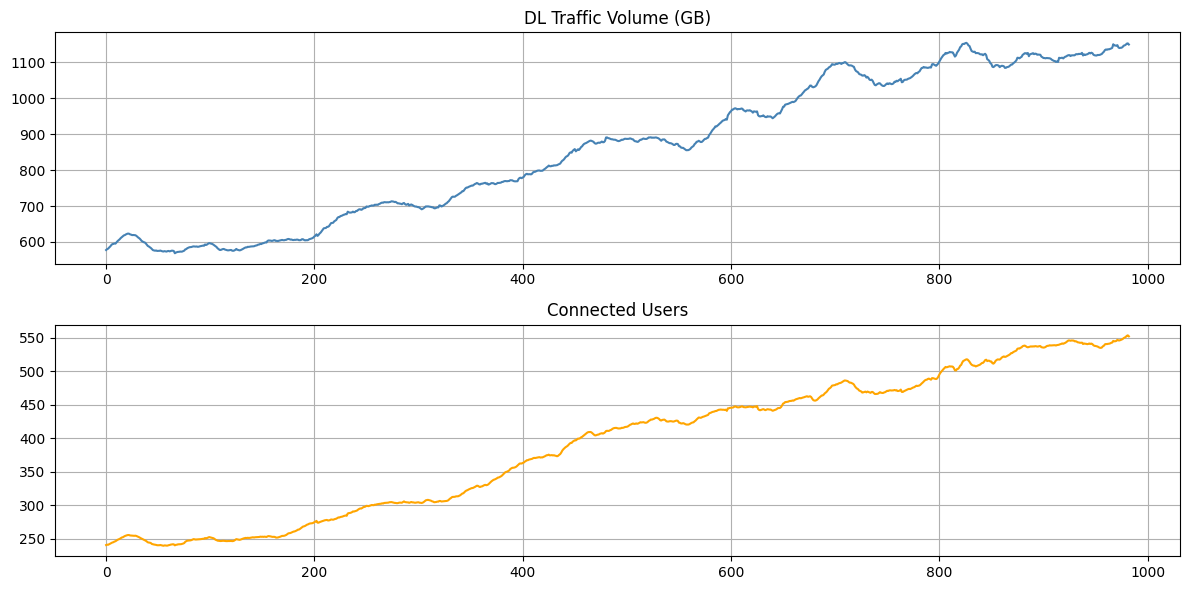

📊 Correlation between Traffic and Users: 0.9894
🎯 Attention weight (alpha): 0.9947


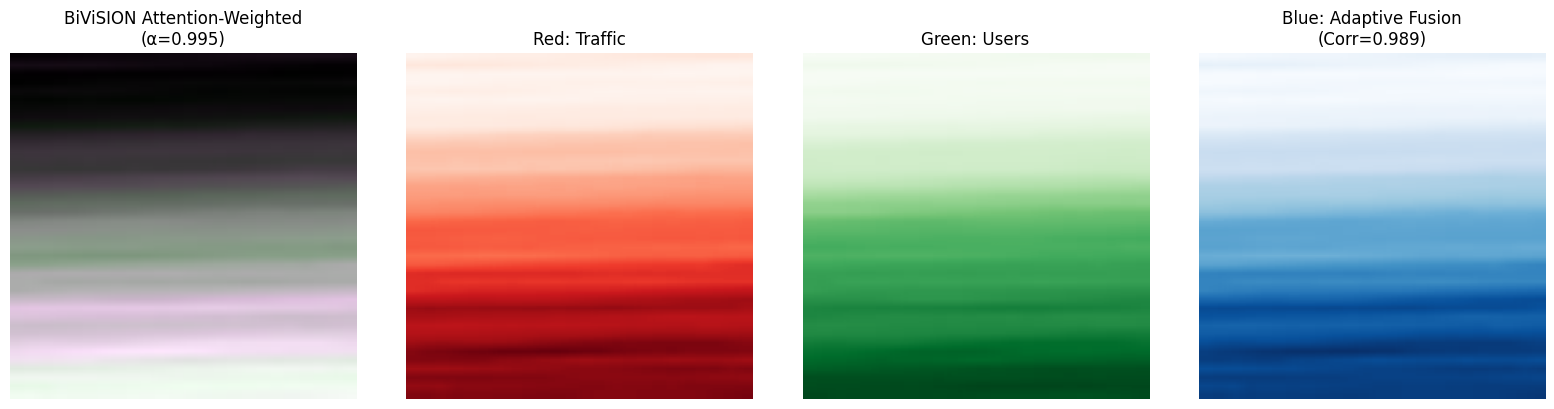

In [94]:
# STEP 0: Configurable forecast length
PRED_LEN         = 100  # CHANGE THIS ONLY
PLOT_CONTEXT_LEN = 300  # Only change this to zoom in or out

# Step 2: Load from CSV - BIVARIATE DATA
df = pd.read_csv('./long_term_tsf/dataset/Telecom/Site_1.csv')

CONTEXT_LEN = len(df) - PRED_LEN

# Extract both variables (bivariate)
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]
data_users = df['connected_users'].values.squeeze()[:CONTEXT_LEN + PRED_LEN]

# Plot both variables
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(data_traffic, color='steelblue')
axs[0].set_title("DL Traffic Volume (GB)")
axs[0].grid(True)

axs[1].plot(data_users, color='orange')
axs[1].set_title("Connected Users")
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Step 3: Convert BIVARIATE time series to RGB image using Attention-Weighted Fusion
img, norm_params = bivariate_attention_weighted_image(data_traffic, data_users, CONTEXT_LEN, PRED_LEN)

# Visualize the RGB encoding
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Full RGB
axes[0].imshow(img)
axes[0].set_title(f"BiViSION Attention-Weighted\n(α={norm_params['alpha']:.3f})")
axes[0].axis('off')

# Individual channels
img_array = np.array(img)
axes[1].imshow(img_array[:, :, 0], cmap='Reds')
axes[1].set_title("Red: Traffic")
axes[1].axis('off')

axes[2].imshow(img_array[:, :, 1], cmap='Greens')
axes[2].set_title("Green: Users")
axes[2].axis('off')

axes[3].imshow(img_array[:, :, 2], cmap='Blues')
axes[3].set_title(f"Blue: Adaptive Fusion\n(Corr={norm_params['correlation']:.3f})")
axes[3].axis('off')

plt.tight_layout()
plt.show()

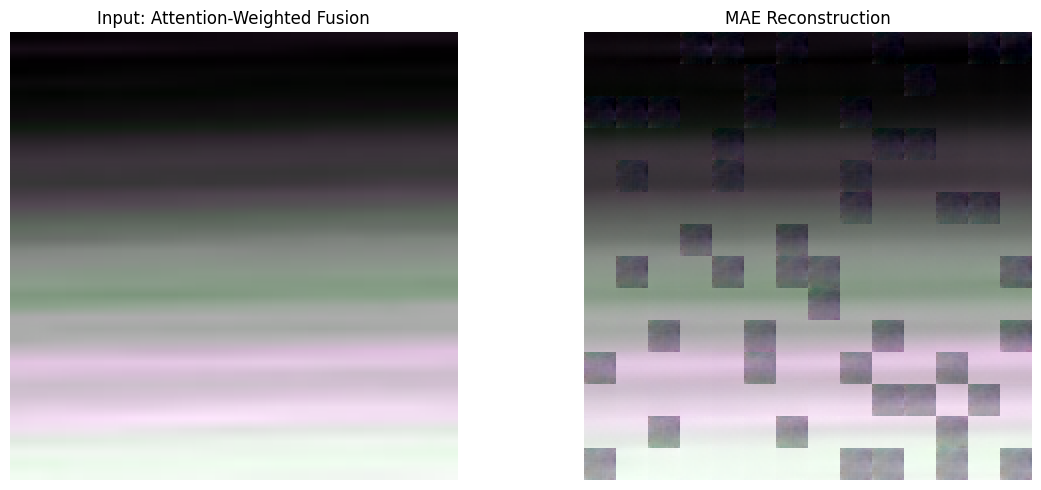

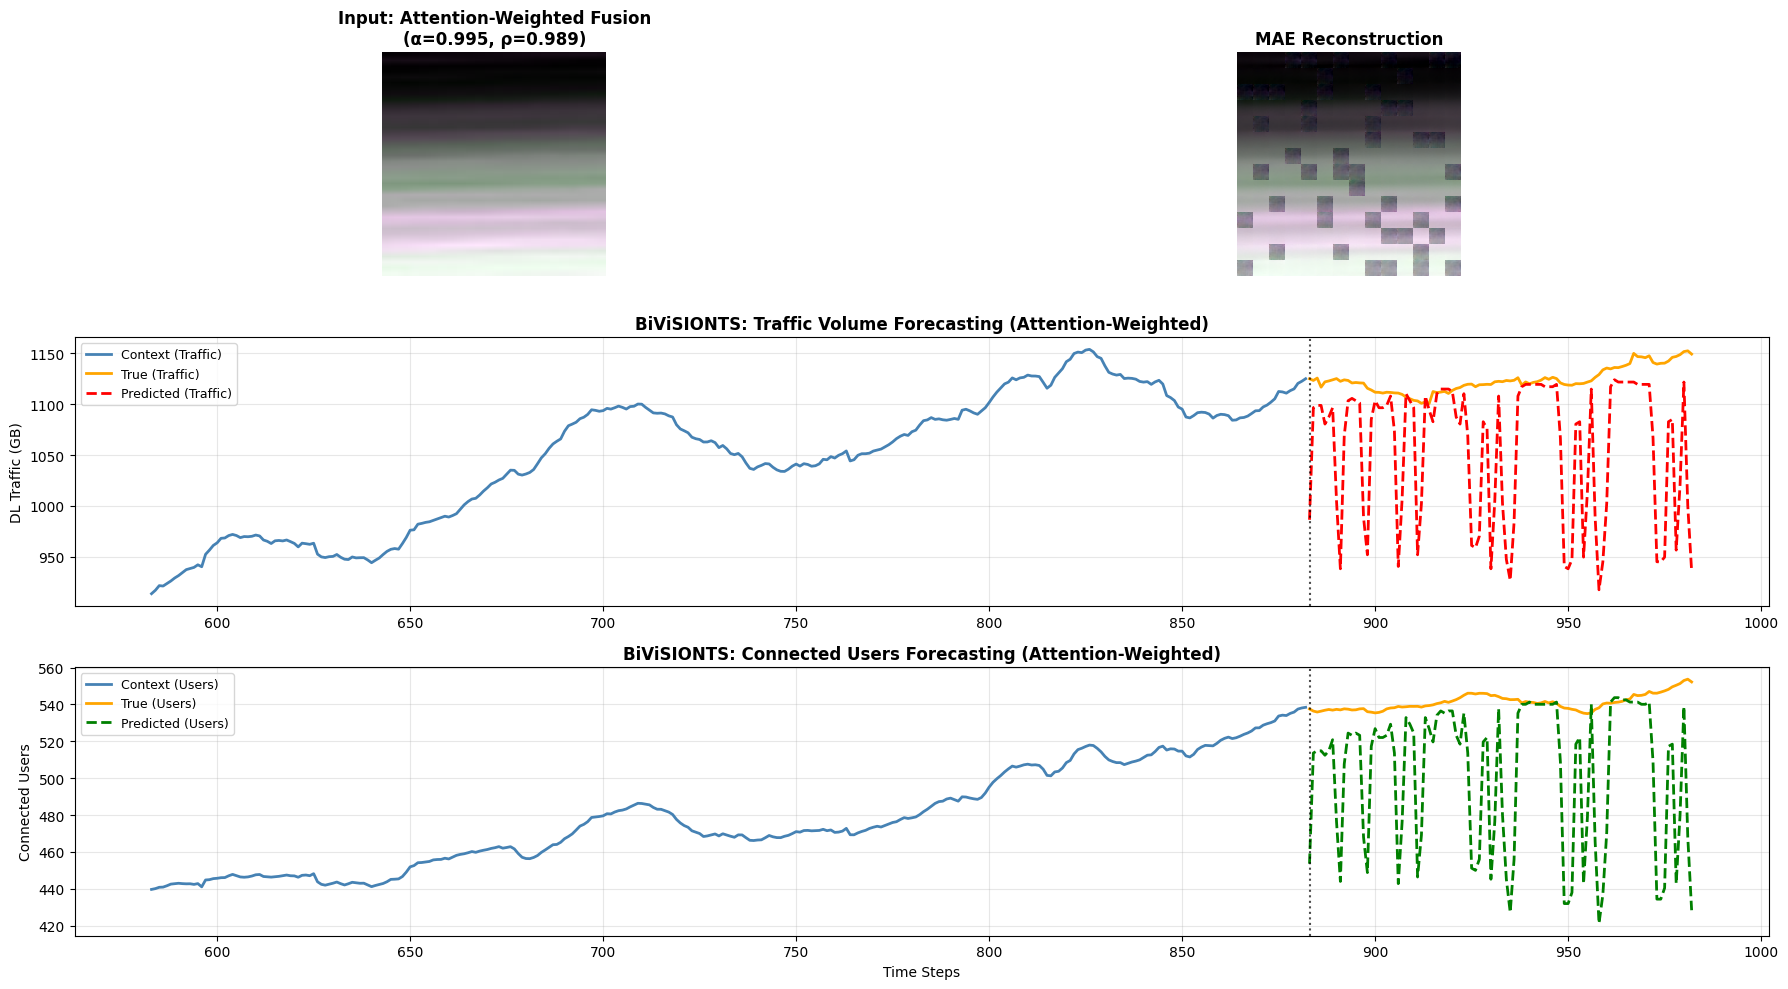

📊 BiViSIONTS Evaluation - MAE Model (Attention-Weighted Fusion)

🎯 Attention Parameters:
  Correlation (ρ) = 0.9894
  Attention weight (α) = 0.9947

🔴 DL Traffic Volume:
  MSE  = 9397.6185
  MAE  = 67.6951
  RMSE = 96.9413
  ✅ Success Rate (MAPE-Based): 93.99%

🟢 Connected Users:
  MSE  = 3043.1508
  MAE  = 38.5449
  RMSE = 55.1648
  ✅ Success Rate (MAPE-Based): 92.89%


In [95]:
# Step 4: Run MAE reconstruction on BIVARIATE attention-weighted image
model = MaskedAutoencoderViT(
    img_size         =224, patch_size   =16, in_chans         =3 ,
    embed_dim        =768, depth        =12, num_heads        =12,
    decoder_embed_dim=512, decoder_depth=8 , decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model'], strict=False)
model.eval()

x = ToTensor()(img).unsqueeze(0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(x, mask_ratio=0.75)
    pred = model.forward_decoder(latent, ids_restore)
    output = model.unpatchify(pred).squeeze().permute(1, 2, 0).numpy()

output = np.clip(output * 255, 0, 255).astype(np.uint8)
reconstructed_img = Image.fromarray(output, mode='RGB')

# Visualize reconstruction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img)
axes[0].set_title("Input: Attention-Weighted Fusion")
axes[0].axis('off')

axes[1].imshow(reconstructed_img)
axes[1].set_title("MAE Reconstruction")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Step 5: Decode BIVARIATE forecasts from reconstructed attention-weighted image
# Decode reconstructed image
recon_traffic, recon_users = attention_weighted_image_to_bivariate(reconstructed_img, norm_params)

# Extract forecast portions
forecast_traffic = recon_traffic[-PRED_LEN:]
forecast_users   = recon_users  [-PRED_LEN:]

# Ground truth
true_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
true_users   = data_users  [:CONTEXT_LEN + PRED_LEN]

# --- Visualization ---
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1.2, 1.2])

# Row 1: Images
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img)
ax1.set_title(f"Input: Attention-Weighted Fusion\n(α={norm_params['alpha']:.3f}, ρ={norm_params['correlation']:.3f})", fontsize=12, fontweight='bold')
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(reconstructed_img)
ax2.set_title("MAE Reconstruction", fontsize=12, fontweight='bold')
ax2.axis("off")

# Row 2: Traffic forecasting
ax3 = fig.add_subplot(gs[1, :])
plot_start = max(0, CONTEXT_LEN - PLOT_CONTEXT_LEN)
ax3.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_traffic[plot_start:CONTEXT_LEN],
    label="Context (Traffic)", color="steelblue", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Traffic)", color="orange", linewidth=2
)
ax3.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_traffic, label="Predicted (Traffic)", color="red", linewidth=2, linestyle='--'
)
ax3.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.set_title("BiViSIONTS: Traffic Volume Forecasting (Attention-Weighted)", fontsize=12, fontweight='bold')
ax3.set_ylabel("DL Traffic (GB)", fontsize=10)
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# Row 3: Users forecasting
ax4 = fig.add_subplot(gs[2, :])
ax4.plot(
    np.arange(plot_start, CONTEXT_LEN),
    true_users[plot_start:CONTEXT_LEN],
    label="Context (Users)", color="steelblue", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    true_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN],
    label="True (Users)", color="orange", linewidth=2
)
ax4.plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_users, label="Predicted (Users)", color="green", linewidth=2, linestyle='--'
)
ax4.axvline(x=CONTEXT_LEN, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax4.set_title("BiViSIONTS: Connected Users Forecasting (Attention-Weighted)", fontsize=12, fontweight='bold')
ax4.set_xlabel("Time Steps", fontsize=10)
ax4.set_ylabel("Connected Users", fontsize=10)
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Evaluation Metrics ---
true_traffic_forecast = true_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
true_users_forecast   = true_users  [CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Calculate metrics
mse_traffic, mae_traffic, rmse_traffic, success_traffic = cal_metrics(true_traffic_forecast, forecast_traffic)
mse_users  , mae_users  , rmse_users  , success_users   = cal_metrics(true_users_forecast  , forecast_users  )

# Print results
print("=" * 80)
print("📊 BiViSIONTS Evaluation - MAE Model (Attention-Weighted Fusion)")
print("=" * 80)
print(f"\n🎯 Attention Parameters:")
print(f"  Correlation (ρ) = {norm_params['correlation']:.4f}")
print(f"  Attention weight (α) = {norm_params['alpha']:.4f}")

print(f"\n🔴 DL Traffic Volume:")
print(f"  MSE  = {mse_traffic:.4f}")
print(f"  MAE  = {mae_traffic:.4f}")
print(f"  RMSE = {rmse_traffic:.4f}")
print(f"  ✅ Success Rate (MAPE-Based): {success_traffic * 100:.2f}%")

print(f"\n🟢 Connected Users:")
print(f"  MSE  = {mse_users:.4f}")
print(f"  MAE  = {mae_users:.4f}")
print(f"  RMSE = {rmse_users:.4f}")
print(f"  ✅ Success Rate (MAPE-Based): {success_users * 100:.2f}%")
print("=" * 80)

## Section 2: BiViSIONTS Model with Attention-Weighted Bivariate Encoding


### Helper Functions

In [7]:
# ========================================================================
# Common
# ========================================================================

def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def bivariate_multiscale_attention(series1, series2, periodicity=24, short_window=100, medium_window=300):
    """
    Multi-Scale Attention-Weighted Encoding Function
    BiViSION Multi-Scale Attention-Weighted Fusion
    Computes attention weights at multiple temporal scales
    """
    total_len  = len(series1)
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape both series into matrices
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store original min/max for denormalization
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize each independently to [0, 1]
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # Compute correlations at multiple scales
    # 1. Long-term (global) correlation
    corr_long  = np.corrcoef(series1[:usable_len], series2[:usable_len])[0, 1]
    alpha_long = (corr_long + 1) / 2
    
    # 2. Medium-term correlation (last medium_window points)
    if usable_len > medium_window:
        corr_medium  = np.corrcoef(
            series1[usable_len-medium_window:usable_len],
            series2[usable_len-medium_window:usable_len]
        )[0, 1]
        alpha_medium = (corr_medium + 1) / 2
    else:
        corr_medium  = corr_long
        alpha_medium = alpha_long
    
    # 3. Short-term correlation (last short_window points)
    if usable_len > short_window:
        corr_short  = np.corrcoef(
            series1[usable_len-short_window:usable_len], 
            series2[usable_len-short_window:usable_len]
        )[0, 1]
        alpha_short = (corr_short + 1) / 2
    else:
        corr_short  = corr_long
        alpha_short = alpha_long
    
    # Weighted combination of attention weights
    # Give more weight to recent correlations
    w_short  = 0.5   # Most weight to recent patterns
    w_medium = 0.3  # Medium weight to medium-term
    w_long   = 0.2    # Least weight to long-term
    
    alpha_final = w_short * alpha_short + w_medium * alpha_medium + w_long * alpha_long
    
    print(f"📊 Multi-Scale Correlations:")
    print(f"  Short-term (last {short_window}): ρ={corr_short:.4f}, α={alpha_short:.4f} (weight: 0.5)")
    print(f"  Medium-term (last {medium_window}): ρ={corr_medium:.4f}, α={alpha_medium:.4f} (weight: 0.3)")
    print(f"  Long-term (full): ρ={corr_long:.4f}, α={alpha_long:.4f} (weight: 0.2)")
    print(f"  ⚡ Final Attention α: {alpha_final:.4f}")
    
    # Create blue channel as multi-scale adaptive fusion
    matrix_fusion = alpha_final * matrix1_norm + (1 - alpha_final) * matrix2_norm
    
    # Convert to uint8 [0, 255]
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    # Stack into RGB image
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    
    # Resize to 224x224 for MAE
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # Return image and parameters
    norm_params = {
        'min1'        : min1        , 'max1': max1,
        'min2'        : min2        , 'max2': max2,
        'usable_len'  : usable_len  ,
        'alpha_final' : alpha_final ,
        'alpha_short' : alpha_short ,
        'alpha_medium': alpha_medium,
        'alpha_long'  : alpha_long  ,
        'corr_short'  : corr_short  ,
        'corr_medium' : corr_medium ,
        'corr_long'   : corr_long
    }
    
    return img, norm_params

def multiscale_attention_to_bivariate(img, norm_params, periodicity=24):
    """
    Decode both variables from reconstruction
    Decode multi-scale attention-weighted RGB image back to two time series
    """
    matrix_h = norm_params['usable_len'] // periodicity
    
    # Resize back to original matrix dimensions
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    # Extract channels
    r_channel = img_array[:, :, 0]  # Traffic
    g_channel = img_array[:, :, 1]  # Users
    
    # Flatten
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    # Denormalize
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

def initialize_models_and_data(data_traffic, data_users, context_len, pred_len, device):
    """Initialize models and prepare data"""
    
    # Initialize VisionTS model
    model = VisionTS('mae_base', './ckpt/').to(device)
    model.update_config(
        context_len =context_len,
        pred_len    =pred_len,
        align_const =1,
        norm_const  =1,
        periodicity =24
    )
    model.eval()
    
    # Initialize MAE model
    mae_model = MaskedAutoencoderViT(
        img_size         =224, patch_size   =16, in_chans         =3 ,
        embed_dim        =768, depth        =12, num_heads        =12,
        decoder_embed_dim=512, decoder_depth=8 , decoder_num_heads=16
    )
    
    # Load pretrained weights
    ckpt_path = './ckpt/mae_visualize_vit_base.pth'
    ckpt = torch.load(ckpt_path, map_location='cpu')
    mae_model.load_state_dict(ckpt['model'], strict=False)
    mae_model.eval()
    mae_model.to(device)
    
    # Prepare full series
    full_traffic = data_traffic[:context_len + pred_len]
    full_users   = data_users  [:context_len + pred_len]
    
    return model, mae_model, full_traffic, full_users

def run_bivisionts_multiscale_forecast(
    data_traffic, 
    data_users, 
    mae_model, 
    context_len, 
    pred_len,
    mask_ratio,
    periodicity,
    short_window,
    medium_window,
    device,
    random_seed = 42
):
    """
    Run BiViSIONTS multi-scale attention forecast
    
    Returns:
        dict: Contains forecasts, metrics, images, and parameters
    """
    # Set random seed
    set_all_seeds(random_seed)
    
    # Prepare full series
    full_traffic = data_traffic[:context_len + pred_len]
    full_users   = data_users  [:context_len + pred_len]
    
    # Create multi-scale attention-weighted image
    input_img, norm_params = bivariate_multiscale_attention(
        full_traffic, full_users,
        periodicity  =periodicity  ,
        short_window =short_window ,
        medium_window=medium_window
    )
    
    # Convert to tensor
    x_tensor = ToTensor()(input_img).unsqueeze(0).to(device)
    
    # Run MAE forward pass
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=mask_ratio)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    # Convert reconstruction back to image
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode reconstructed image
    recon_traffic_full, recon_users_full = multiscale_attention_to_bivariate(
        recon_img, norm_params, periodicity=periodicity
    )
    
    # Extract forecast portions
    forecast_traffic = recon_traffic_full[-pred_len:]
    forecast_users   = recon_users_full  [-pred_len:]
    
    # Ground truth
    y_traffic = data_traffic[context_len:context_len + pred_len]
    y_users   = data_users  [context_len:context_len + pred_len]
    
    # Calculate metrics
    mse_traffic, mae_traffic, rmse_traffic, success_traffic = cal_metrics(y_traffic, forecast_traffic)
    mse_users  , mae_users  , rmse_users  , success_users   = cal_metrics(y_users  , forecast_users  )
    
    # Return results
    return {
        'input_img': input_img,
        'recon_img': recon_img,
        'norm_params': norm_params,
        'forecast_traffic': forecast_traffic,
        'forecast_users': forecast_users,
        'y_traffic': y_traffic,
        'y_users': y_users,
        'metrics': {
            'traffic': {
                'mse': mse_traffic,
                'mae': mae_traffic,
                'rmse': rmse_traffic,
                'success_rate': success_traffic * 100
            },
            'users': {
                'mse': mse_users,
                'mae': mae_users,
                'rmse': rmse_users,
                'success_rate': success_users * 100
            }
        }
    }


# ========================================================================
# Single Run
# ========================================================================

def visualize_multiscale_encoding(input_img, norm_params):
    """Visualize multi-scale attention encoding"""
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Panel 1: Full RGB image
    axes[0].imshow(input_img)
    axes[0].set_title(f"Multi-Scale Attention\n(α={norm_params['alpha_final']:.3f})", fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    # Panel 2: Red channel (Traffic)
    img_array = np.array(input_img)
    axes[1].imshow(img_array[:, :, 0], cmap='Reds')
    axes[1].set_title("Red: Traffic", fontsize=10)
    axes[1].axis('off')
    
    # Panel 3: Green channel (Users)
    axes[2].imshow(img_array[:, :, 1], cmap='Greens')
    axes[2].set_title("Green: Users", fontsize=10)
    axes[2].axis('off')
    
    # Panel 4: Blue channel (Adaptive Fusion)
    axes[3].imshow(img_array[:, :, 2], cmap='Blues')
    axes[3].set_title(f"Blue: Adaptive Fusion\n(α={norm_params['alpha_final']:.3f})", fontsize=10)
    axes[3].axis('off')
    
    # Panel 5: Multi-scale attention weights bar chart
    scales = ['Short\n(100)', 'Medium\n(300)', 'Long\n(Full)']
    alphas = [norm_params['alpha_short'], norm_params['alpha_medium'], norm_params['alpha_long']]
    colors_bar = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    
    axes[4].bar(scales, alphas, color=colors_bar, alpha=0.7, edgecolor='black')
    axes[4].axhline(y=norm_params['alpha_final'], color='red', linestyle='--', linewidth=2, label=f"Final α={norm_params['alpha_final']:.3f}")
    axes[4].set_ylabel('Attention Weight (α)', fontsize=10)
    axes[4].set_title('Multi-Scale Attention', fontsize=10, fontweight='bold')
    axes[4].set_ylim([0, 1])
    axes[4].legend(loc='upper right', fontsize=8)
    axes[4].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def visualize_forecast_results(result, df, context_len, pred_len, plot_context_len=300, title_suffix=""):
    """Visualize forecast results with images and time series"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Top-left: Input image
    axes[0, 0].imshow(result['input_img'])
    axes[0, 0].set_title(
        f"Input: Multi-Scale Attention Fusion{title_suffix}\n(α_final={result['norm_params']['alpha_final']:.3f})", 
        fontsize=12, fontweight='bold'
    )
    axes[0, 0].axis('off')
    
    # Top-right: Reconstructed image
    axes[0, 1].imshow(result['recon_img'])
    axes[0, 1].set_title(f"MAE Reconstruction{title_suffix}", fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Prepare timestamps for time series
    timestamps = pd.to_datetime(df['date'])
    time_x = timestamps[:context_len]
    time_y = timestamps[context_len:context_len + pred_len]
    
    x_traffic = data_traffic[:context_len]
    x_users   = data_users  [:context_len]
    
    # Bottom-left: Traffic forecasting
    axes[1, 0].plot(time_x[-plot_context_len:], x_traffic[-plot_context_len:], label="Context", color='steelblue', linewidth=2)
    axes[1, 0].plot(time_y, result['y_traffic'], label="True", color='orange', linewidth=2)
    axes[1, 0].plot(time_y, result['forecast_traffic'], label="Predicted", color='red', linewidth=2, linestyle='--')
    axes[1, 0].set_title(f"BiViSIONTS{title_suffix}: Traffic Volume Forecasting", fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel("DL Traffic (GB)")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Bottom-right: Users forecasting
    axes[1, 1].plot(time_x[-plot_context_len:], x_users[-plot_context_len:], label="Context", color='steelblue', linewidth=2)
    axes[1, 1].plot(time_y, result['y_users'], label="True", color='orange', linewidth=2)
    axes[1, 1].plot(time_y, result['forecast_users'], label="Predicted", color='green', linewidth=2, linestyle='--')
    axes[1, 1].set_title(f"BiViSIONTS{title_suffix}: Connected Users Forecasting", fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel("Connected Users")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

def print_metrics(result, hyperparams=None, title="BiViSIONTS Evaluation"):
    """Print evaluation metrics"""
    print("=" * 80)
    print(f"📊 {title}")
    print("=" * 80)
    
    # Print hyperparameters if provided
    if hyperparams:
        print(f"\n🏆 Hyperparameters:")
        for key, value in hyperparams.items():
            print(f"  {key}: {value}")
    
    # Print multi-scale attention parameters
    norm_params = result['norm_params']
    print(f"\n🎯 Multi-Scale Attention Parameters:")
    print(f"  Short-term: ρ={norm_params['corr_short']:.4f} → α={norm_params['alpha_short']:.4f} (weight: 0.5)")
    print(f"  Medium-term: ρ={norm_params['corr_medium']:.4f} → α={norm_params['alpha_medium']:.4f} (weight: 0.3)")
    print(f"  Long-term: ρ={norm_params['corr_long']:.4f} → α={norm_params['alpha_long']:.4f} (weight: 0.2)")
    print(f"  ⚡ Final Attention α: {norm_params['alpha_final']:.4f}")
    
    # Print traffic metrics
    metrics = result['metrics']
    print(f"\n🔴 DL Traffic Volume:")
    print(f"  MSE  = {metrics['traffic']['mse']:.4f}")
    print(f"  MAE  = {metrics['traffic']['mae']:.4f}")
    print(f"  RMSE = {metrics['traffic']['rmse']:.4f}")
    print(f"  ✅ Success Rate (MAPE-Based): {metrics['traffic']['success_rate']:.2f}%")
    
    # Print users metrics
    print(f"\n🟢 Connected Users:")
    print(f"  MSE  = {metrics['users']['mse']:.4f}")
    print(f"  MAE  = {metrics['users']['mae']:.4f}")
    print(f"  RMSE = {metrics['users']['rmse']:.4f}")
    print(f"  ✅ Success Rate (MAPE-Based): {metrics['users']['success_rate']:.2f}%")
    
    # Print overall performance
    avg_success = (metrics['traffic']['success_rate'] + metrics['users']['success_rate']) / 2
    print(f"\n🎯 Overall Performance:")
    print(f"  Average Success Rate: {avg_success:.2f}%")
    print("=" * 80)


# ========================================================================
# Iterative Run
# ========================================================================

def run_initial_test(mae_model, full_traffic, full_users, context_len, pred_len, x_traffic, y_traffic, x_users, y_users, plot_context_len, df, device):
    """Run initial test with default parameters"""
    print("🔍 Testing Multi-Scale Attention with default parameters...")
    print("=" * 80)
    
    # Create multi-scale attention image
    input_img_full, norm_params_full = bivariate_multiscale_attention(
        full_traffic, full_users, periodicity=24, short_window=100, medium_window=300
    )
    
    # Print correlation statistics
    print(f"\n📊 Multi-Scale Correlations:")
    print(f"  Short-term (last 100): ρ={norm_params_full['corr_short']:.4f}, α={norm_params_full['alpha_short']:.4f}")
    print(f"  Medium-term (last 300): ρ={norm_params_full['corr_medium']:.4f}, α={norm_params_full['alpha_medium']:.4f}")
    print(f"  Long-term (full): ρ={norm_params_full['corr_long']:.4f}, α={norm_params_full['alpha_long']:.4f}")
    print(f"  ⚡ Final Attention α: {norm_params_full['alpha_final']:.4f}")
    
    # Visualize encoding
    visualize_multiscale_encoding(input_img_full, norm_params_full)
    
    # Run MAE reconstruction
    x_tensor = ToTensor()(input_img_full).unsqueeze(0).to(device)
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=0.85)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    # Convert reconstruction to image
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode forecasts from reconstructed image
    recon_traffic_full, recon_users_full = multiscale_attention_to_bivariate(recon_img, norm_params_full)
    forecast_traffic = recon_traffic_full[-pred_len:]
    forecast_users   = recon_users_full  [-pred_len:]
    
    # Visualize results
    visualize_initial_test(input_img_full, recon_img, norm_params_full, x_traffic, y_traffic, x_users, y_users, forecast_traffic, forecast_users, context_len, pred_len, plot_context_len, df)
    
    # Print metrics
    print_initial_metrics(norm_params_full, y_traffic, forecast_traffic, y_users, forecast_users)

def visualize_initial_test(input_img, recon_img, norm_params, x_traffic, y_traffic, x_users, y_users, forecast_traffic, forecast_users, context_len, pred_len, plot_context_len, df):
    """Visualize initial test results"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Top-left: Input image
    axes[0, 0].imshow(input_img)
    axes[0, 0].set_title(f"Input: Multi-Scale Attention Fusion\n(α_final={norm_params['alpha_final']:.3f})", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Top-right: Reconstructed image
    axes[0, 1].imshow(recon_img)
    axes[0, 1].set_title("MAE Reconstruction (BiViSIONTS)", fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Prepare timestamps
    timestamps = pd.to_datetime(df['date'])
    time_x = timestamps[:context_len]
    time_y = timestamps[context_len:context_len + pred_len]
    
    # Bottom-left: Traffic forecasting
    axes[1, 0].plot(time_x[-plot_context_len:], x_traffic[-plot_context_len:], label="Context", color='steelblue', linewidth=2)
    axes[1, 0].plot(time_y, y_traffic, label="True", color='orange', linewidth=2)
    axes[1, 0].plot(time_y, forecast_traffic, label="Predicted", color='red', linewidth=2, linestyle='--')
    axes[1, 0].set_title("BiViSIONTS: Traffic Volume Forecasting", fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel("DL Traffic (GB)")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Bottom-right: Users forecasting
    axes[1, 1].plot(time_x[-plot_context_len:], x_users[-plot_context_len:], label="Context", color='steelblue', linewidth=2)
    axes[1, 1].plot(time_y, y_users, label="True", color='orange', linewidth=2)
    axes[1, 1].plot(time_y, forecast_users, label="Predicted", color='green', linewidth=2, linestyle='--')
    axes[1, 1].set_title("BiViSIONTS: Connected Users Forecasting", fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel("Connected Users")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

def print_initial_metrics(norm_params, y_traffic, forecast_traffic, y_users, forecast_users):
    """Print initial test metrics"""
    
    # Calculate metrics
    mse_traffic, mae_traffic, rmse_traffic, success_traffic = cal_metrics(y_traffic, forecast_traffic)
    mse_users  , mae_users  , rmse_users  , success_users   = cal_metrics(y_users  , forecast_users  )
    
    # Print results
    print("\n" + "=" * 80)
    print("📊 BiViSIONTS Initial Test - Multi-Scale Attention-Weighted Fusion")
    print("=" * 80)
    print(f"\n🎯 Multi-Scale Attention Parameters:")
    print(f"  Short-term: ρ={norm_params['corr_short']:.4f} → α={norm_params['alpha_short']:.4f} (weight: 0.5)")
    print(f"  Medium-term: ρ={norm_params['corr_medium']:.4f} → α={norm_params['alpha_medium']:.4f} (weight: 0.3)")
    print(f"  Long-term: ρ={norm_params['corr_long']:.4f} → α={norm_params['alpha_long']:.4f} (weight: 0.2)")
    print(f"  ⚡ Final Attention α: {norm_params['alpha_final']:.4f}")
    
    print(f"\n🔴 DL Traffic Volume:")
    print(f"  MSE  = {mse_traffic:.4f}")
    print(f"  MAE  = {mae_traffic:.4f}")
    print(f"  RMSE = {rmse_traffic:.4f}")
    print(f"  ✅ Success Rate (MAPE-Based): {success_traffic * 100:.2f}%")
    
    print(f"\n🟢 Connected Users:")
    print(f"  MSE  = {mse_users:.4f}")
    print(f"  MAE  = {mae_users:.4f}")
    print(f"  RMSE = {rmse_users:.4f}")
    print(f"  ✅ Success Rate (MAPE-Based): {success_users * 100:.2f}%")
    print("=" * 80)

def run_hyperparameter_optimization(mae_model, full_traffic, full_users, context_len, pred_len, device, param_grid):
    """Run hyperparameter grid search optimization"""
    print("\n\n🔧 Starting Hyperparameter Optimization for Multi-Scale Attention...")
    print("=" * 80)
    
    results = []
    total_combinations = (
        len(param_grid['mask_ratio'  ]) * len(param_grid['periodicity'  ]) *
        len(param_grid['short_window']) * len(param_grid['medium_window'])
    )
    
    print(f"Total combinations to test: {total_combinations}")
    print()
    
    # Grid search over all combinations
    set_all_seeds(42)
    iteration = 0
    for mask_ratio, periodicity, short_window, medium_window in itertools.product(
        param_grid['mask_ratio'  ], param_grid['periodicity'  ],
        param_grid['short_window'], param_grid['medium_window']
    ):
        iteration += 1
        
        # Skip invalid combinations
        if short_window >= medium_window: continue
        
        try:
            # Run forecast with current hyperparameters
            result = run_bivisionts_multiscale_forecast(
                full_traffic, full_users, mae_model, context_len, pred_len,
                mask_ratio  =mask_ratio  , periodicity  =periodicity,
                short_window=short_window, medium_window=medium_window,
                device      =device      , random_seed  =42
            )
            
            # Store results
            results.append({
                'mask_ratio'     : mask_ratio,
                'periodicity'    : periodicity,
                'short_window'   : short_window,
                'medium_window'  : medium_window,
                'traffic_success': result['metrics']['traffic']['success_rate'],
                'users_success'  : result['metrics']['users']['success_rate'],
                'avg_success'    : (result['metrics']['traffic']['success_rate'] +
                                    result['metrics']['users']['success_rate']) / 2,
                'traffic_mse'    : result['metrics']['traffic']['mse'],
                'users_mse'      : result['metrics']['users']['mse']
            })
            
            if iteration % 10 == 0:
                print(f"✓ Tested {iteration} combinations...")
                
        except Exception as e:
            print(f"⚠ Skipped combination: {str(e)}")
            continue
    
    print()
    print("=" * 80)
    print("✅ Hyperparameter optimization completed!")
    print()
    
    # Sort results by average success rate
    results_df = pd.DataFrame(results).sort_values('avg_success', ascending=False)
    
    # Display top 10 configurations
    print("🏆 TOP 10 HYPERPARAMETER CONFIGURATIONS")
    print("=" * 80)
    print(results_df.head(10).to_string(index=False))
    print()
    
    # Display best configuration
    best_config = results_df.iloc[0]
    print("⭐ BEST CONFIGURATION:")
    print("=" * 80)
    print(f"Mask Ratio: {best_config['mask_ratio']}")
    print(f"Periodicity: {int(best_config['periodicity'])}")
    print(f"Short Window: {int(best_config['short_window'])}")
    print(f"Medium Window: {int(best_config['medium_window'])}")
    print(f"\n🔴 Traffic Success Rate: {best_config['traffic_success']:.2f}%")
    print(f"🟢 Users Success Rate: {best_config['users_success']:.2f}%")
    print(f"📊 Average Success Rate: {best_config['avg_success']:.2f}%")
    print("=" * 80)
    
    # Visualize and save results
    visualize_optimization_results(results_df, best_config)
    results_df.to_csv('hyperparameter_optimization_results.csv', index=False)
    print("\n💾 Results saved to 'hyperparameter_optimization_results.csv'")
    
    return best_config

def visualize_optimization_results(results_df, best_config):
    """Visualize hyperparameter optimization results"""
    
    def _plot_line_comparison(ax, grouped_df, x_col, title, xlabel):
        """Helper: Plot line comparison for traffic and users"""
        
        # Plot traffic success rate
        ax.plot(grouped_df[x_col], grouped_df['traffic_success'], marker='o', linewidth=2, label='Traffic', color='steelblue')
        
        # Plot users success rate
        ax.plot(grouped_df[x_col], grouped_df['users_success'], marker='s', linewidth=2, label='Users', color='green')
        
        # Plot average if available
        if 'avg_success' in grouped_df.columns:
            ax.plot(grouped_df[x_col], grouped_df['avg_success'], marker='^', linewidth=2, label='Average', color='red', linestyle='--')
        
        # Configure plot appearance
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Success Rate (%)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_bar_comparison(ax, grouped_df, x_col, title, xlabel):
        """Helper: Plot bar comparison for traffic and users"""
        
        # Plot traffic bars (offset left)
        ax.bar(grouped_df[x_col] - 2, grouped_df['traffic_success'], width=4, alpha=0.7, label='Traffic', color='steelblue')
        
        # Plot users bars (offset right)
        ax.bar(grouped_df[x_col] + 2, grouped_df['users_success'], width=4, alpha=0.7, label='Users', color='green')
        
        # Configure plot appearance
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Success Rate (%)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Define optimal/baseline values
    OPTIMAL_MASK   =     best_config['mask_ratio'    ]
    OPTIMAL_PERIOD = int(best_config['periodicity'   ])
    OPTIMAL_SHORT  = int(best_config['short_window'  ])
    OPTIMAL_MEDIUM = int(best_config['medium_window' ])
    
    # Top-left: Impact of mask ratio
    mask_grouped = results_df[
        (results_df['periodicity'  ] == OPTIMAL_PERIOD) &
        (results_df['short_window' ] == OPTIMAL_SHORT ) &
        (results_df['medium_window'] == OPTIMAL_MEDIUM)
    ].groupby('mask_ratio').agg({'traffic_success': 'mean', 'users_success': 'mean', 'avg_success': 'mean'}).reset_index()
    _plot_line_comparison(axes[0, 0], mask_grouped, 'mask_ratio', 'Impact of Mask Ratio', 'Mask Ratio')
    
    # Top-right: Impact of periodicity
    period_grouped = results_df[
        (results_df['mask_ratio'   ] == OPTIMAL_MASK  ) &
        (results_df['short_window' ] == OPTIMAL_SHORT ) &
        (results_df['medium_window'] == OPTIMAL_MEDIUM)
    ].groupby('periodicity').agg({'traffic_success': 'mean', 'users_success': 'mean', 'avg_success': 'mean'}).reset_index()
    _plot_bar_comparison(axes[0, 1], period_grouped, 'periodicity', 'Impact of Periodicity', 'Periodicity')
    
    # Bottom-left: Impact of short window
    short_grouped = results_df[
        (results_df['mask_ratio'   ] == OPTIMAL_MASK  ) &
        (results_df['periodicity'  ] == OPTIMAL_PERIOD) &
        (results_df['medium_window'] == OPTIMAL_MEDIUM)
    ].groupby('short_window').agg({'traffic_success': 'mean', 'users_success': 'mean', 'avg_success': 'mean'}).reset_index()
    _plot_line_comparison(axes[1, 0], short_grouped, 'short_window', 'Impact of Short Window', 'Short Window Size')
    
    # Bottom-right: Impact of medium window
    medium_grouped = results_df[
        (results_df['mask_ratio'  ] == OPTIMAL_MASK  ) &
        (results_df['periodicity' ] == OPTIMAL_PERIOD) &
        (results_df['short_window'] == OPTIMAL_SHORT )
    ].groupby('medium_window').agg({'traffic_success': 'mean', 'users_success': 'mean', 'avg_success': 'mean'}).reset_index()
    _plot_line_comparison(axes[1, 1], medium_grouped, 'medium_window', 'Impact of Medium Window', 'Medium Window Size')
    
    plt.tight_layout()
    plt.show()

def run_convergence_analysis(mae_model, full_traffic, full_users, context_len, pred_len, best_config, num_iterations, device):
    """Run multi-iteration convergence analysis with best parameters"""
    print("\n\n" + "=" * 80)
    print("STARTING CONVERGENCE ANALYSIS WITH OPTIMIZED PARAMETERS")
    print("=" * 80)
    
    # Extract best hyperparameters from optimization
    BEST_MASK_RATIO    =     best_config['mask_ratio'   ]
    BEST_PERIODICITY   = int(best_config['periodicity'  ])
    BEST_SHORT_WINDOW  = int(best_config['short_window' ])
    BEST_MEDIUM_WINDOW = int(best_config['medium_window'])
    
    print(f"\n🔄 Running Multi-Scale Attention with BEST parameters ({num_iterations} iterations)...")
    print("=" * 80)
    print(f"Best Configuration:")
    print(f"  Mask Ratio: {BEST_MASK_RATIO}")
    print(f"  Periodicity: {BEST_PERIODICITY}")
    print(f"  Short Window: {BEST_SHORT_WINDOW}")
    print(f"  Medium Window: {BEST_MEDIUM_WINDOW}")
    print("=" * 80)
    print()
    
    # Initialize storage for metrics
    traffic_success_rates = []
    users_success_rates   = []
    traffic_mse_list      = []
    traffic_mae_list      = []
    users_mse_list        = []
    users_mae_list        = []
    
    # Run multiple iterations with different random seeds
    for iteration in range(num_iterations):
        set_all_seeds(42 + iteration)
        result = run_bivisionts_multiscale_forecast(
            full_traffic, full_users, mae_model, context_len, pred_len,
            mask_ratio=BEST_MASK_RATIO, periodicity=BEST_PERIODICITY,
            short_window=BEST_SHORT_WINDOW, medium_window=BEST_MEDIUM_WINDOW,
            device=device, random_seed=42 + iteration
        )
        
        # Store metrics from this iteration
        traffic_success_rates.append(result['metrics']['traffic']['success_rate'])
        users_success_rates  .append(result['metrics']['users'  ]['success_rate'])
        traffic_mse_list     .append(result['metrics']['traffic']['mse'         ])
        traffic_mae_list     .append(result['metrics']['traffic']['mae'         ])
        users_mse_list       .append(result['metrics']['users'  ]['mse'         ])
        users_mae_list       .append(result['metrics']['users'  ]['mae'         ])
        
        # Progress update every 10 iterations
        if (iteration + 1) % 10 == 0:
            print(f"✓ Completed {iteration + 1}/{num_iterations} iterations")
    
    print("=" * 80)
    print("✅ All iterations completed!")
    print()
    
    # Print statistical summary
    print_convergence_statistics(
        traffic_success_rates, users_success_rates, traffic_mse_list, traffic_mae_list,
        users_mse_list, users_mae_list, BEST_MASK_RATIO, BEST_PERIODICITY, 
        BEST_SHORT_WINDOW, BEST_MEDIUM_WINDOW
    )
    
    # Visualize convergence behavior
    visualize_convergence_results(traffic_success_rates, users_success_rates, num_iterations)
    
    # Save results to CSV
    save_convergence_results(
        traffic_success_rates, users_success_rates, traffic_mse_list, 
        traffic_mae_list, users_mse_list, users_mae_list, num_iterations
    )
    
    return traffic_success_rates, users_success_rates

def print_convergence_statistics(traffic_success_rates, users_success_rates, traffic_mse_list, traffic_mae_list, users_mse_list, users_mae_list, mask_ratio, periodicity, short_window, medium_window):
    """Print convergence analysis statistics"""
    
    # Calculate statistics
    traffic_avg = np.mean(traffic_success_rates)
    traffic_std = np.std (traffic_success_rates)
    users_avg   = np.mean(users_success_rates  )
    users_std   = np.std (users_success_rates  )
    
    print("📊 OPTIMIZED CONVERGENCE STATISTICS")
    print("=" * 80)
    print(f"\n🏆 Using BEST Hyperparameters:")
    print(f"  Mask Ratio: {mask_ratio}")
    print(f"  Periodicity: {periodicity}")
    print(f"  Short Window: {short_window}")
    print(f"  Medium Window: {medium_window}")
    
    # Traffic statistics
    print(f"\n🔴 DL Traffic Volume:")
    print(f"  Average Success Rate: {traffic_avg:.2f}%")
    print(f"  Std Deviation: {traffic_std:.2f}%")
    print(f"  Min: {min(traffic_success_rates):.2f}%")
    print(f"  Max: {max(traffic_success_rates):.2f}%")
    print(f"  Average MSE: {np.mean(traffic_mse_list):.4f}")
    print(f"  Average MAE: {np.mean(traffic_mae_list):.4f}")
    
    # Users statistics
    print(f"\n🟢 Connected Users:")
    print(f"  Average Success Rate: {users_avg:.2f}%")
    print(f"  Std Deviation: {users_std:.2f}%")
    print(f"  Min: {min(users_success_rates):.2f}%")
    print(f"  Max: {max(users_success_rates):.2f}%")
    print(f"  Average MSE: {np.mean(users_mse_list):.4f}")
    print(f"  Average MAE: {np.mean(users_mae_list):.4f}")
    
    # Overall performance
    print(f"\n🎯 Overall Performance:")
    print(f"  Average Success Rate (Both KPIs): {(traffic_avg + users_avg) / 2:.2f}%")
    print("=" * 80)

def visualize_convergence_results(traffic_success_rates, users_success_rates, num_iterations):
    """Visualize convergence analysis results"""
    
    def _plot_convergence_with_stats(ax, iterations_list, success_rates, avg, std, color, marker, title):
        """Helper: Plot convergence with average and standard deviation"""
        
        # Plot success rates over iterations
        ax.plot(iterations_list, success_rates, marker=marker, markersize=4, linewidth=1.5, color=color, alpha=0.7, label='Success Rate')
        
        # Plot average line
        ax.axhline(y=avg, color='red' if color == 'steelblue' else 'darkgreen', linestyle='--', linewidth=2, label=f'Average: {avg:.2f}%')
        
        # Fill standard deviation band
        ax.fill_between(iterations_list, avg - std, avg + std, color='red' if color == 'steelblue' else 'green', alpha=0.1, label=f'±1 Std Dev: {std:.2f}%')
        
        # Configure plot
        ax.set_xlabel('Iteration', fontsize=11)
        ax.set_ylabel('Success Rate (%)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 100])

    def _plot_histogram(ax, success_rates, avg, color, title):
        """Helper: Plot distribution histogram"""
        
        # Plot histogram
        ax.hist(success_rates, bins=20, color=color, alpha=0.7, edgecolor='black')
        
        # Plot mean line
        ax.axvline(x=avg, color='red' if color == 'steelblue' else 'darkgreen', linestyle='--', linewidth=2, label=f'Mean: {avg:.2f}%')
        
        # Configure plot
        ax.set_xlabel('Success Rate (%)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    # Calculate statistics
    traffic_avg = np.mean(traffic_success_rates)
    traffic_std = np.std (traffic_success_rates)
    users_avg   = np.mean(users_success_rates  )
    users_std   = np.std (users_success_rates  )
    iterations_list = list(range(1, num_iterations + 1))
    
    # Main convergence plots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Top-left: Traffic convergence
    _plot_convergence_with_stats(axes[0, 0], iterations_list, traffic_success_rates, traffic_avg, traffic_std, 'steelblue', 'o', '🔴 Traffic Volume - Optimized Convergence')
    
    # Top-right: Users convergence
    _plot_convergence_with_stats(axes[0, 1], iterations_list, users_success_rates, users_avg, users_std, 'green', 's', '🟢 Connected Users - Optimized Convergence')
    
    # Bottom-left: Combined comparison
    axes[1, 0].plot(iterations_list, traffic_success_rates, marker='o', markersize=3, linewidth=1.5, color='steelblue', alpha=0.7, label='Traffic')
    axes[1, 0].axhline(y=traffic_avg, color='steelblue', linestyle='--', linewidth=2)
    axes[1, 0].plot(iterations_list, users_success_rates, marker='s', markersize=3, linewidth=1.5, color='green', alpha=0.7, label='Users')
    axes[1, 0].axhline(y=users_avg, color='green', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Iteration', fontsize=11)
    axes[1, 0].set_ylabel('Success Rate (%)', fontsize=11)
    axes[1, 0].set_title('📊 Both KPIs - Optimized Performance', fontsize=12, fontweight='bold')
    axes[1, 0].legend(loc='best')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 100])
    
    # Bottom-right: Running average
    traffic_running_avg = [np.mean(traffic_success_rates[:i+1]) for i in range(num_iterations)]
    users_running_avg = [np.mean(users_success_rates[:i+1]) for i in range(num_iterations)]
    axes[1, 1].plot(iterations_list, traffic_running_avg, linewidth=2, color='steelblue', label=f'Traffic (→{traffic_avg:.2f}%)')
    axes[1, 1].plot(iterations_list, users_running_avg, linewidth=2, color='green', label=f'Users (→{users_avg:.2f}%)')
    axes[1, 1].axhline(y=traffic_avg, color='steelblue', linestyle=':', linewidth=1, alpha=0.5)
    axes[1, 1].axhline(y=users_avg, color='green', linestyle=':', linewidth=1, alpha=0.5)
    axes[1, 1].set_xlabel('Iteration', fontsize=11)
    axes[1, 1].set_ylabel('Running Average (%)', fontsize=11)
    axes[1, 1].set_title('📈 Cumulative Average - Optimized', fontsize=12, fontweight='bold')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 100])
    
    plt.tight_layout()
    plt.show()
    
    # Distribution histograms
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Traffic distribution
    _plot_histogram(axes[0], traffic_success_rates, traffic_avg, 'steelblue', '🔴 Traffic - Optimized Distribution')
    
    # Users distribution
    _plot_histogram(axes[1], users_success_rates, users_avg, 'green', '🟢 Users - Optimized Distribution')
    
    plt.tight_layout()
    plt.show()

def save_convergence_results(traffic_success_rates, users_success_rates, traffic_mse_list, traffic_mae_list, users_mse_list, users_mae_list, num_iterations):
    """Save convergence results to CSV"""
    
    # Create results dataframe
    optimized_results_df = pd.DataFrame({
        'Iteration': list(range(1, num_iterations + 1)),
        'Traffic_Success_Rate_%': traffic_success_rates,
        'Users_Success_Rate_%': users_success_rates,
        'Traffic_MSE': traffic_mse_list,
        'Traffic_MAE': traffic_mae_list,
        'Users_MSE': users_mse_list,
        'Users_MAE': users_mae_list
    })
    
    # Display preview
    print("\n📋 Optimized Results DataFrame (First 10 rows):")
    print(optimized_results_df.head(10))
    
    # Display summary statistics
    print("\n📊 SUMMARY STATISTICS (Optimized)")
    print("=" * 80)
    print(optimized_results_df.describe())
    print("=" * 80)
    
    # Save to CSV
    optimized_results_df.to_csv('optimized_multiscale_convergence_results.csv', index=False)
    print("\n💾 Results saved to 'optimized_multiscale_convergence_results.csv'")

def print_final_summary(traffic_success_rates, users_success_rates):
    """Print final summary of the entire optimization process"""
    
    # Calculate final statistics
    traffic_avg = np.mean(traffic_success_rates)
    traffic_std = np.std (traffic_success_rates)
    users_avg   = np.mean(users_success_rates  )
    users_std   = np.std (users_success_rates  )
    
    # Print final summary
    print("\n\n" + "=" * 80)
    print("🎉 COMPLETE: Multi-Scale Attention BiViSIONTS with Full Optimization")
    print("=" * 80)
    print(f"\n📈 FINAL RESULTS:")
    print(f"  🔴 Traffic: {traffic_avg:.2f}% ± {traffic_std:.2f}%")
    print(f"  🟢 Users: {users_avg:.2f}% ± {users_std:.2f}%")
    print(f"  🎯 Overall: {(traffic_avg + users_avg) / 2:.2f}%")
    print("=" * 80)


### Settings & Initials

In [14]:
# CONFIG
PRED_LEN         = 100
PLOT_CONTEXT_LEN = 300
NUM_ITERATIONS   = 1000

# OPTIMIZED HYPERPARAMETERS FOR SINGLE RUN
# OPTIMIZED_MASK_RATIO    = 0.75
# OPTIMIZED_PERIODICITY   = 30
# OPTIMIZED_SHORT_WINDOW  = 100
# OPTIMIZED_MEDIUM_WINDOW = 300

OPTIMIZED_MASK_RATIO    = 0.85
OPTIMIZED_PERIODICITY   = 1
OPTIMIZED_SHORT_WINDOW  = 150
OPTIMIZED_MEDIUM_WINDOW = 400

# Define hyperparameter search space
PARAM_GRID = {
    'mask_ratio'    : [0.75 , 0.80 , 0.85 , 0.90        ],
    'periodicity'   : [1    , 7    , 14   , 21 , 28, 30 ],
    'short_window'  : [50   , 100  , 150                ],
    'medium_window' : [200  , 300  , 400                ]
}

DEVICE = 'cpu'  # or 'cuda:0'

# Load BIVARIATE data
df = pd.read_csv('./long_term_tsf/dataset/Telecom/Site_1.csv')
data_traffic = df['dl_traffic_volume_gb'].values.squeeze()
data_users   = df['connected_users'     ].values.squeeze()
CONTEXT_LEN  = len(df) - PRED_LEN

# Split into context and forecast
x_traffic = data_traffic[:CONTEXT_LEN                      ]
y_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
x_users   = data_users  [:CONTEXT_LEN                      ]
y_users   = data_users  [CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

print(f"Context length: {CONTEXT_LEN}")
print(f"Prediction length: {PRED_LEN}")
print(f"Traffic range: [{x_traffic.min():.2f}, {x_traffic.max():.2f}]")
print(f"Users range: [{x_users.min():.2f}, {x_users.max():.2f}]")

Context length: 918
Prediction length: 100
Traffic range: [444.67, 1263.40]
Users range: [198.12, 592.76]


### Single Run

In [16]:
# Initialize models & data
model, mae_model, full_traffic, full_users = initialize_models_and_data(data_traffic, data_users, CONTEXT_LEN, PRED_LEN, DEVICE)

print("🏆 OPTIMIZED CONFIGURATION")
print("=" * 80)
print(f"Mask Ratio: {OPTIMIZED_MASK_RATIO}")
print(f"Periodicity: {OPTIMIZED_PERIODICITY}")
print(f"Short Window: {OPTIMIZED_SHORT_WINDOW}")
print(f"Medium Window: {OPTIMIZED_MEDIUM_WINDOW}")
print("=" * 80)
print()

# Run forecast
result = run_bivisionts_multiscale_forecast(
    data_traffic, data_users, mae_model,
    CONTEXT_LEN, PRED_LEN,
    mask_ratio   =OPTIMIZED_MASK_RATIO   ,
    periodicity  =OPTIMIZED_PERIODICITY  ,
    short_window =OPTIMIZED_SHORT_WINDOW ,
    medium_window=OPTIMIZED_MEDIUM_WINDOW,
    device       =DEVICE
)

# Visualize encoding
visualize_multiscale_encoding(result['input_img'], result['norm_params'])

# Visualize forecast
visualize_forecast_results(result, df, CONTEXT_LEN, PRED_LEN, PLOT_CONTEXT_LEN, title_suffix="-Optimized")

# Print metrics
hyperparams = {
    'Mask Ratio'   : OPTIMIZED_MASK_RATIO   ,
    'Periodicity'  : OPTIMIZED_PERIODICITY  ,
    'Short Window' : OPTIMIZED_SHORT_WINDOW ,
    'Medium Window': OPTIMIZED_MEDIUM_WINDOW
}
print_metrics(result, hyperparams, "BiViSIONTS-OPTIMIZED Evaluation (Multi-Scale Attention)")

🏆 OPTIMIZED CONFIGURATION
Mask Ratio: 0.85
Periodicity: 1
Short Window: 150
Medium Window: 400

📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 400): ρ=0.8239, α=0.9119 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9144


NameError: name 'cal_metrics' is not defined

### Iterative Run

🔍 Testing Multi-Scale Attention with default parameters...
📊 Multi-Scale Correlations:
  Short-term (last 100): ρ=0.7023, α=0.8512 (weight: 0.5)
  Medium-term (last 300): ρ=0.7073, α=0.8537 (weight: 0.3)
  Long-term (full): ρ=0.9807, α=0.9903 (weight: 0.2)
  ⚡ Final Attention α: 0.8797

📊 Multi-Scale Correlations:
  Short-term (last 100): ρ=0.7023, α=0.8512
  Medium-term (last 300): ρ=0.7073, α=0.8537
  Long-term (full): ρ=0.9807, α=0.9903
  ⚡ Final Attention α: 0.8797


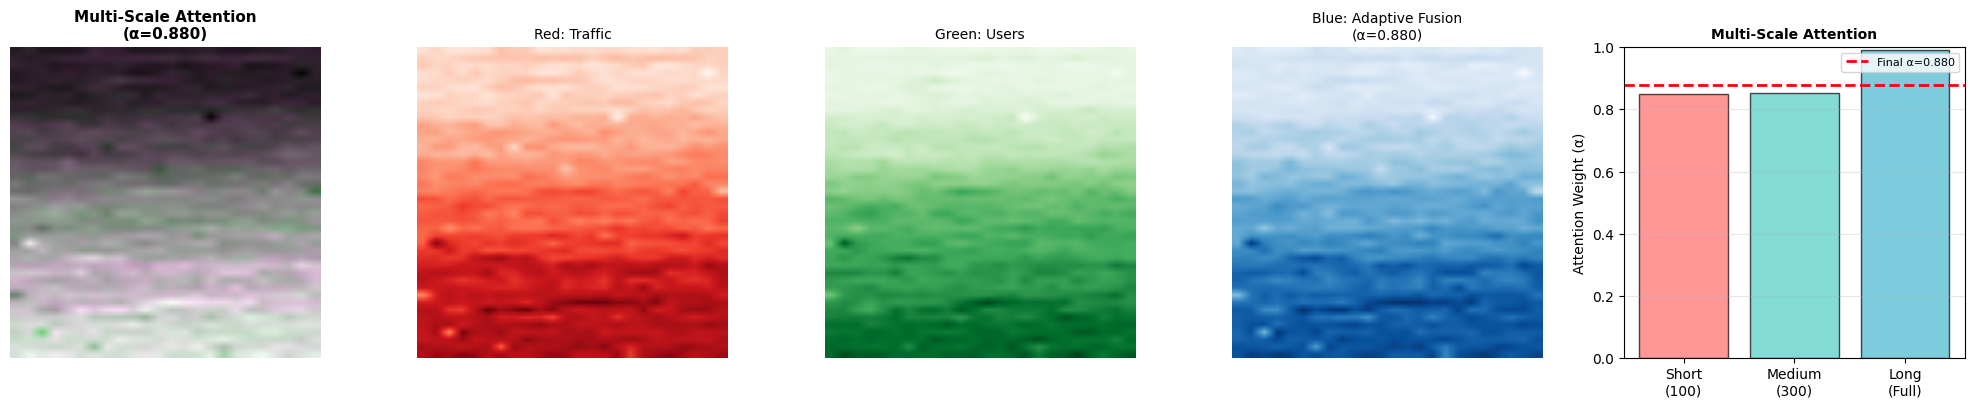

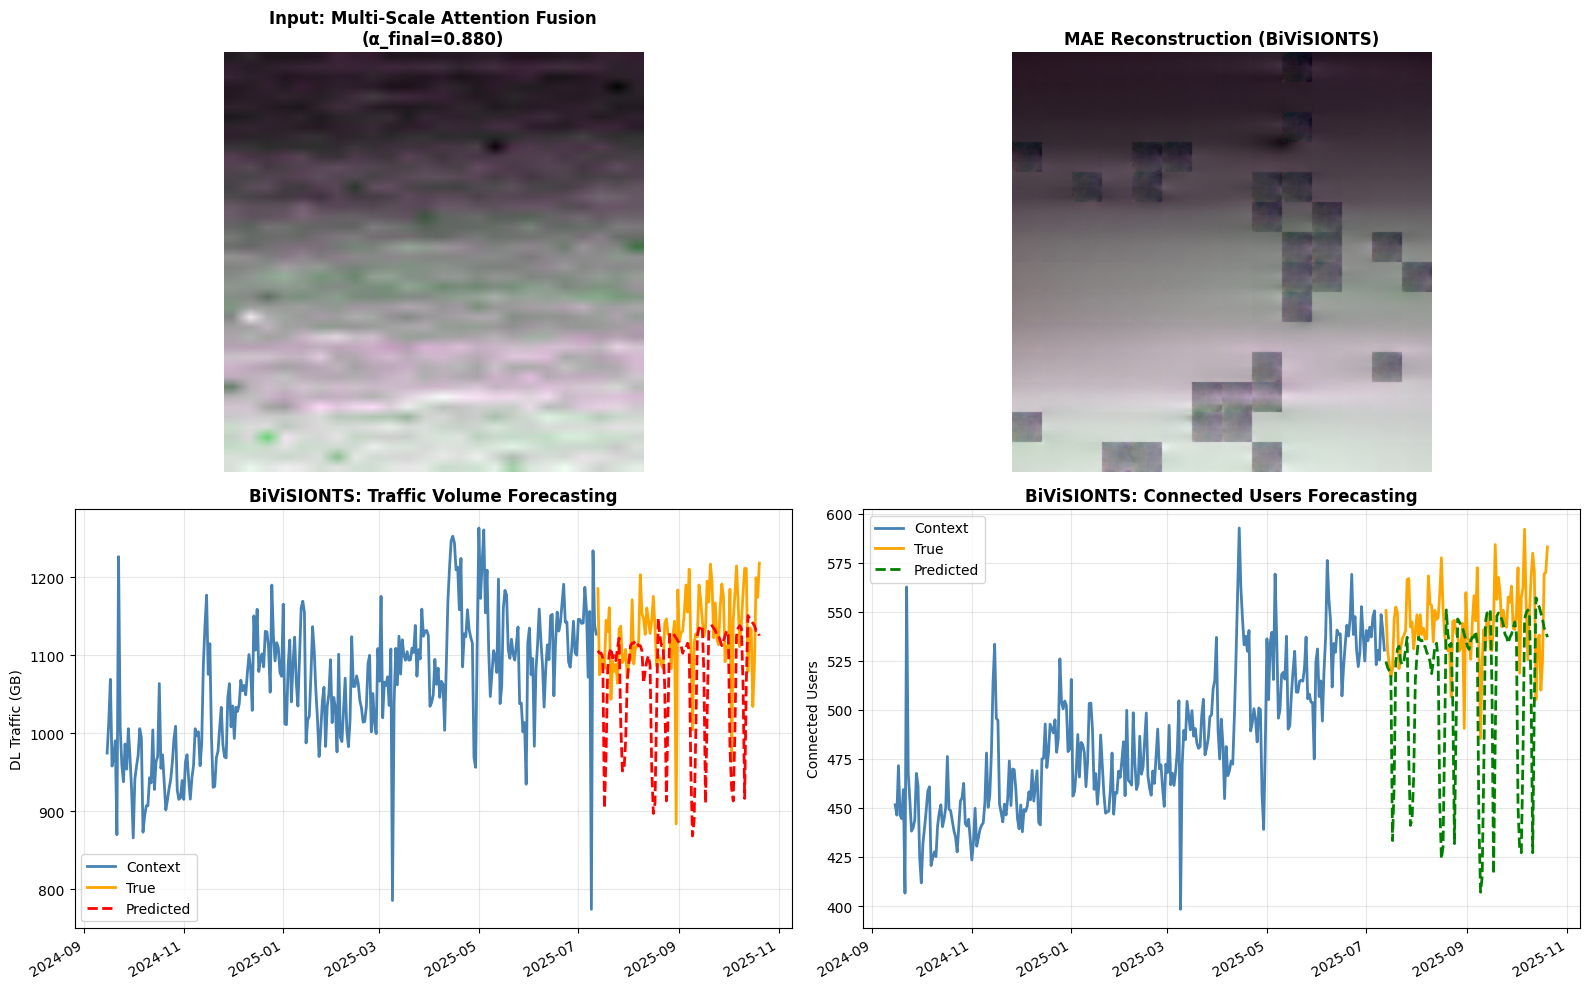


📊 BiViSIONTS Initial Test - Multi-Scale Attention-Weighted Fusion

🎯 Multi-Scale Attention Parameters:
  Short-term: ρ=0.7023 → α=0.8512 (weight: 0.5)
  Medium-term: ρ=0.7073 → α=0.8537 (weight: 0.3)
  Long-term: ρ=0.9807 → α=0.9903 (weight: 0.2)
  ⚡ Final Attention α: 0.8797

🔴 DL Traffic Volume:
  MSE  = 10329.1209
  MAE  = 73.0241
  RMSE = 101.6323
  ✅ Success Rate (MAPE-Based): 93.53%

🟢 Connected Users:
  MSE  = 2845.3766
  MAE  = 36.4048
  RMSE = 53.3421
  ✅ Success Rate (MAPE-Based): 93.31%


🔧 Starting Hyperparameter Optimization for Multi-Scale Attention...
Total combinations to test: 216

📊 Multi-Scale Correlations:
  Short-term (last 50): ρ=0.8679, α=0.9340 (weight: 0.5)
  Medium-term (last 200): ρ=0.6598, α=0.8299 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9141
📊 Multi-Scale Correlations:
  Short-term (last 50): ρ=0.8679, α=0.9340 (weight: 0.5)
  Medium-term (last 300): ρ=0.7279, α=0.8639 (weight: 0.3)
  Long-term (full): ρ=

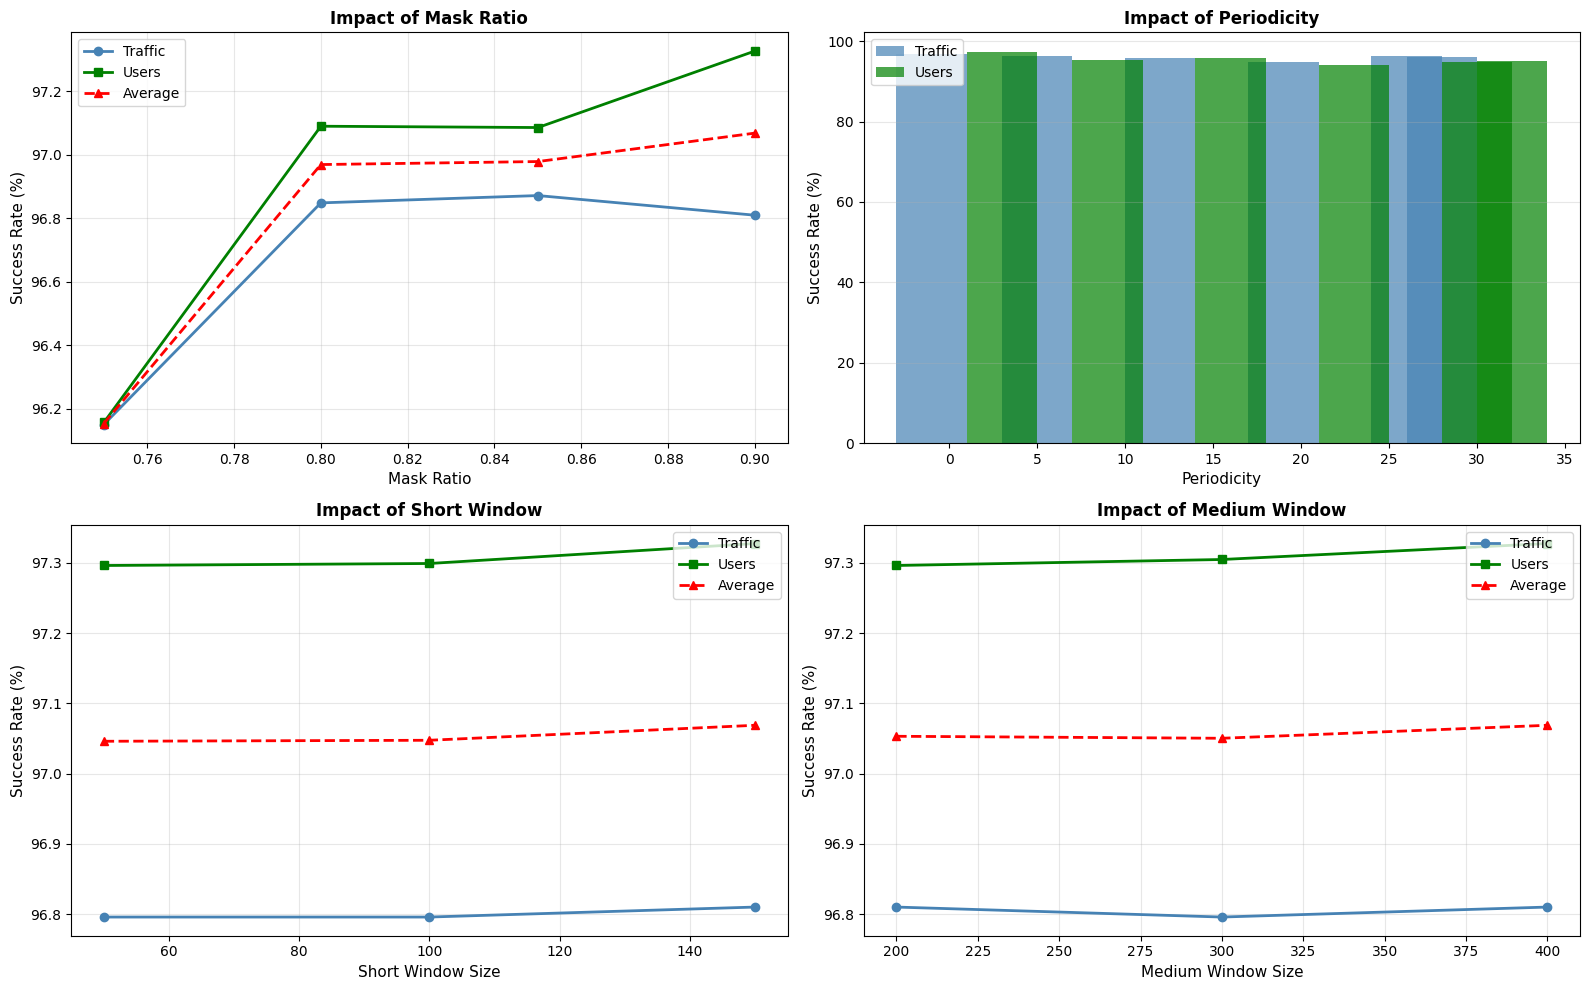


💾 Results saved to 'hyperparameter_optimization_results.csv'


STARTING CONVERGENCE ANALYSIS WITH OPTIMIZED PARAMETERS

🔄 Running Multi-Scale Attention with BEST parameters (1000 iterations)...
Best Configuration:
  Mask Ratio: 0.9
  Periodicity: 1
  Short Window: 150
  Medium Window: 400

📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 400): ρ=0.8239, α=0.9119 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9144
📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 400): ρ=0.8239, α=0.9119 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9144
📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 400): ρ=0.8239, α=0.9119 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9144
📊 Multi-Scale Correlatio

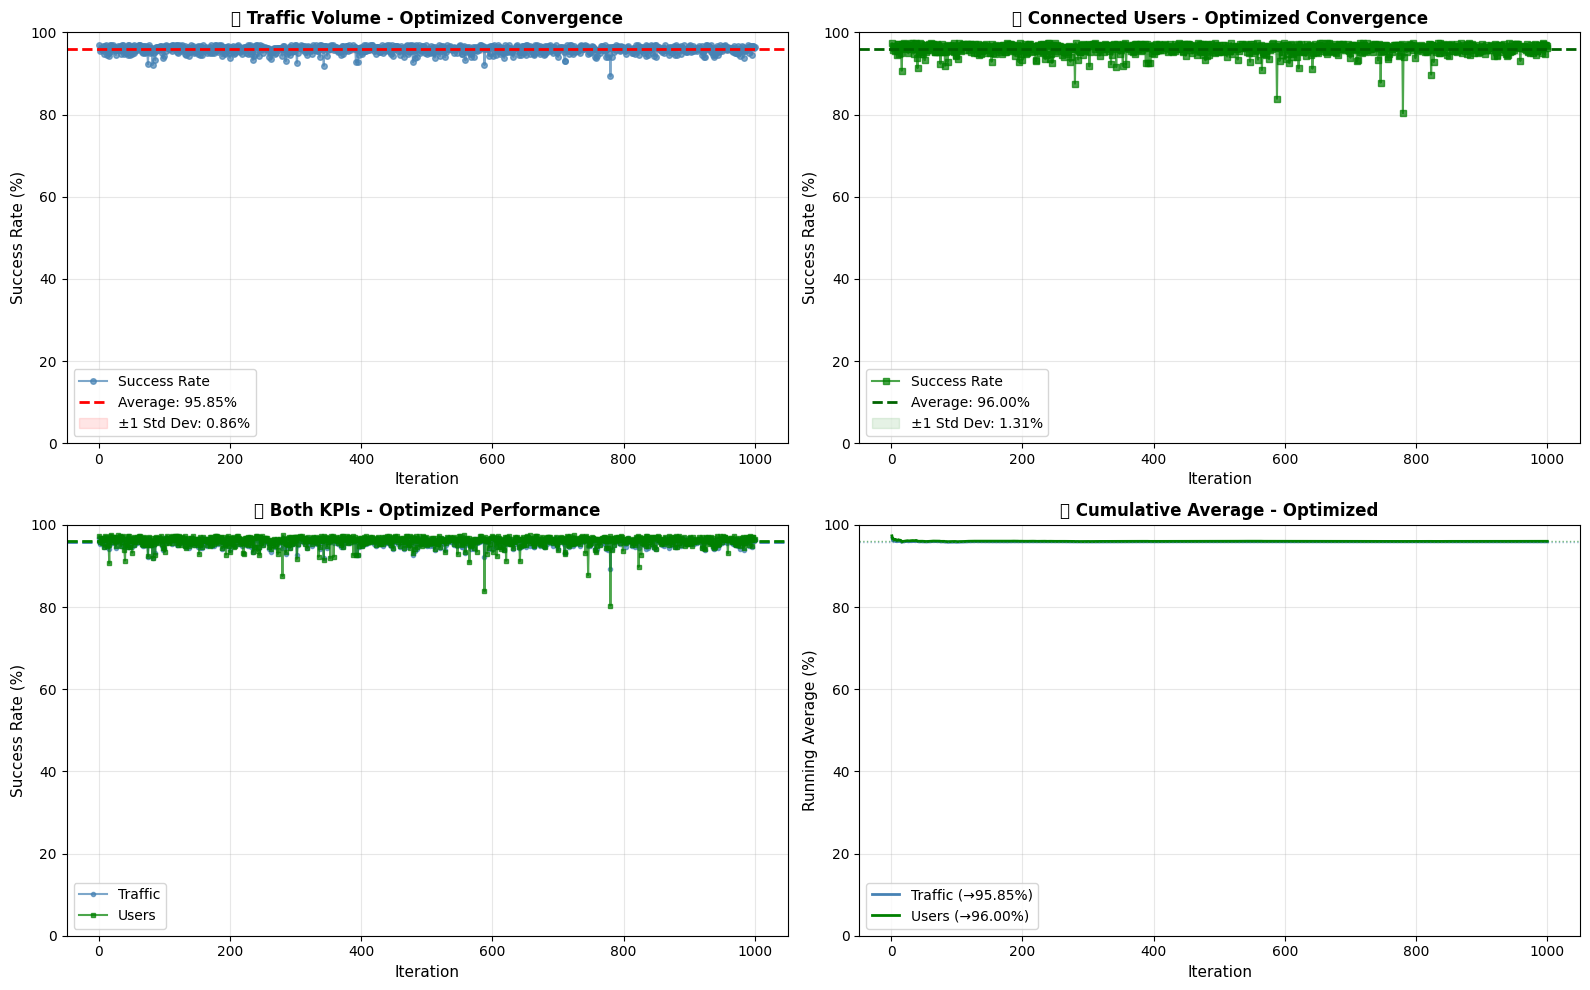

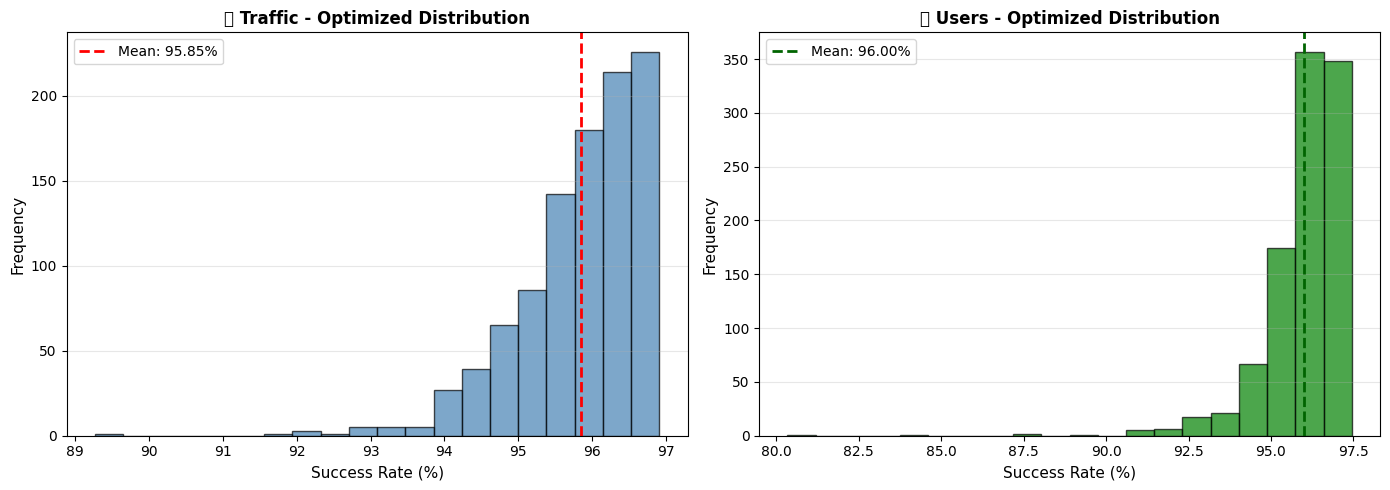


📋 Optimized Results DataFrame (First 10 rows):
   Iteration  Traffic_Success_Rate_%  Users_Success_Rate_%  Traffic_MSE  \
0          1               96.810014             97.327433  2564.617922   
1          2               95.377589             95.770262  4131.259628   
2          3               96.089192             96.704794  3075.691966   
3          4               96.032385             96.305952  3324.314701   
4          5               95.603349             95.577892  3806.158789   
5          6               96.178558             96.645006  3137.287208   
6          7               96.743493             96.707082  2770.613103   
7          8               94.695637             94.585083  4951.831300   
8          9               95.937471             96.232710  3464.357877   
9         10               96.568878             97.240792  2679.250295   

   Traffic_MAE    Users_MSE  Users_MAE  
0    36.030291   368.326517  14.542769  
1    52.209260   718.771964  23.016115  
2  

In [44]:
# Initialize models & data
model, mae_model, full_traffic, full_users = initialize_models_and_data(data_traffic, data_users, CONTEXT_LEN, PRED_LEN, DEVICE)

# ========================================================================
# PART 1: Initial Test with Default Parameters
# ========================================================================
run_initial_test(mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, x_traffic, y_traffic, x_users, y_users, PLOT_CONTEXT_LEN, df, DEVICE)

# ========================================================================
# PART 2: Hyperparameter Optimization Grid Search
# ========================================================================
best_config = run_hyperparameter_optimization(mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, DEVICE, PARAM_GRID)

# ========================================================================
# PART 3: Multi-Iteration Convergence Analysis with Best Parameters
# ========================================================================
traffic_success_rates, users_success_rates = run_convergence_analysis(mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, best_config, NUM_ITERATIONS, DEVICE)

# ========================================================================
# Final Summary
# ========================================================================
print_final_summary(traffic_success_rates, users_success_rates)

# Information Collection

## Iterative Run With Timing

🚀 INITIALIZING MODELS AND DATA
✅ Initialization completed in 4.29 seconds

📊 PART 1: INITIAL TEST WITH DEFAULT PARAMETERS
🔍 Testing Multi-Scale Attention with default parameters...
📊 Multi-Scale Correlations:
  Short-term (last 100): ρ=0.7023, α=0.8512 (weight: 0.5)
  Medium-term (last 300): ρ=0.7073, α=0.8537 (weight: 0.3)
  Long-term (full): ρ=0.9807, α=0.9903 (weight: 0.2)
  ⚡ Final Attention α: 0.8797

📊 Multi-Scale Correlations:
  Short-term (last 100): ρ=0.7023, α=0.8512
  Medium-term (last 300): ρ=0.7073, α=0.8537
  Long-term (full): ρ=0.9807, α=0.9903
  ⚡ Final Attention α: 0.8797


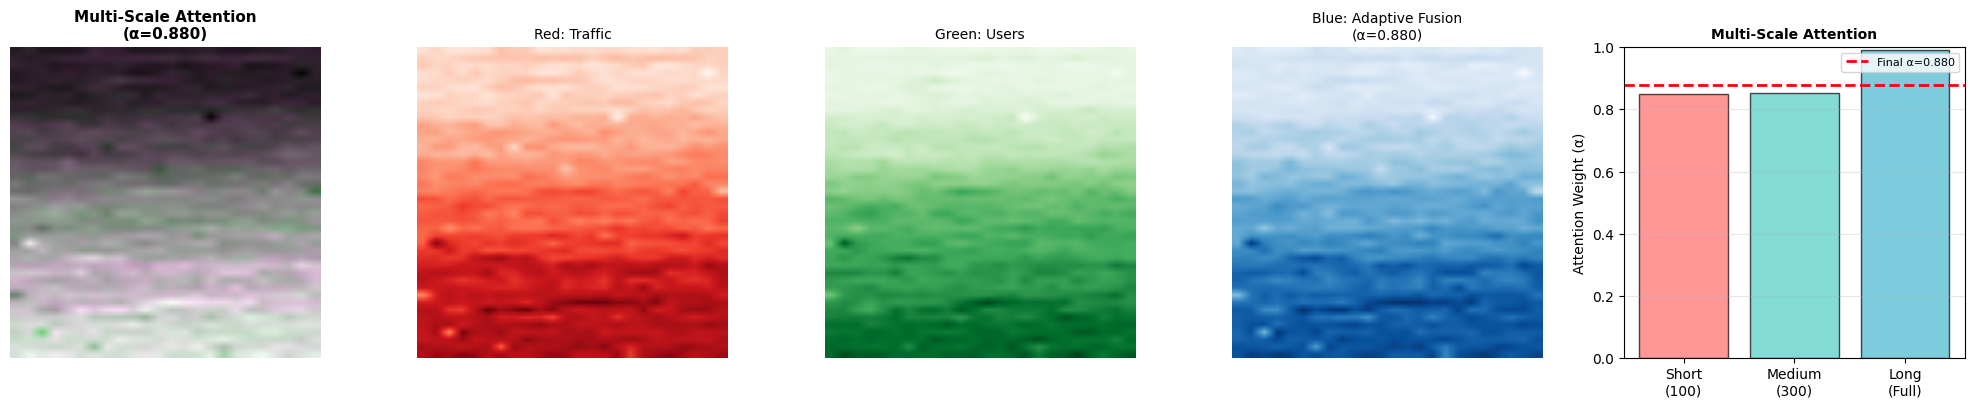

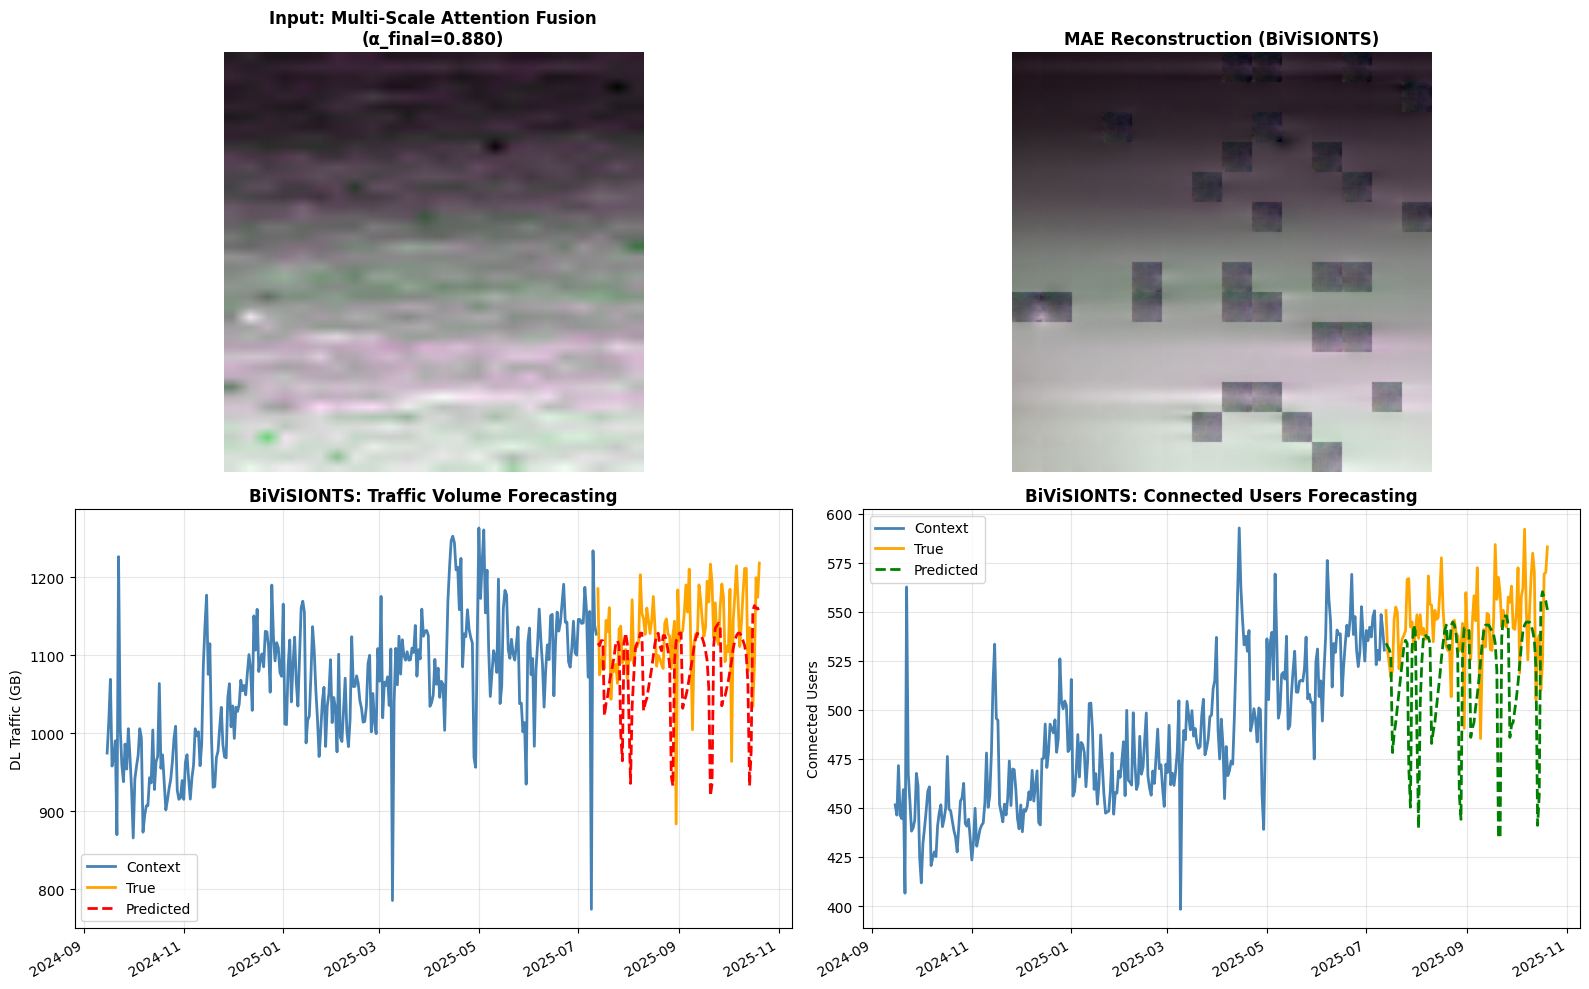


📊 BiViSIONTS Initial Test - Multi-Scale Attention-Weighted Fusion

🎯 Multi-Scale Attention Parameters:
  Short-term: ρ=0.7023 → α=0.8512 (weight: 0.5)
  Medium-term: ρ=0.7073 → α=0.8537 (weight: 0.3)
  Long-term: ρ=0.9807 → α=0.9903 (weight: 0.2)
  ⚡ Final Attention α: 0.8797

🔴 DL Traffic Volume:
  MSE  = 7957.2729
  MAE  = 67.0959
  RMSE = 89.2035
  ✅ Success Rate (MAPE-Based): 94.06%

🟢 Connected Users:
  MSE  = 1858.4076
  MAE  = 31.5625
  RMSE = 43.1093
  ✅ Success Rate (MAPE-Based): 94.23%

⏱️  Initial test completed in 1.41 seconds

🔍 PART 2: HYPERPARAMETER OPTIMIZATION GRID SEARCH


🔧 Starting Hyperparameter Optimization for Multi-Scale Attention...
Total combinations to test: 216

📊 Multi-Scale Correlations:
  Short-term (last 50): ρ=0.8679, α=0.9340 (weight: 0.5)
  Medium-term (last 200): ρ=0.6598, α=0.8299 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9141
📊 Multi-Scale Correlations:
  Short-term (last 50): ρ=0.8679, α=0.9340 (w

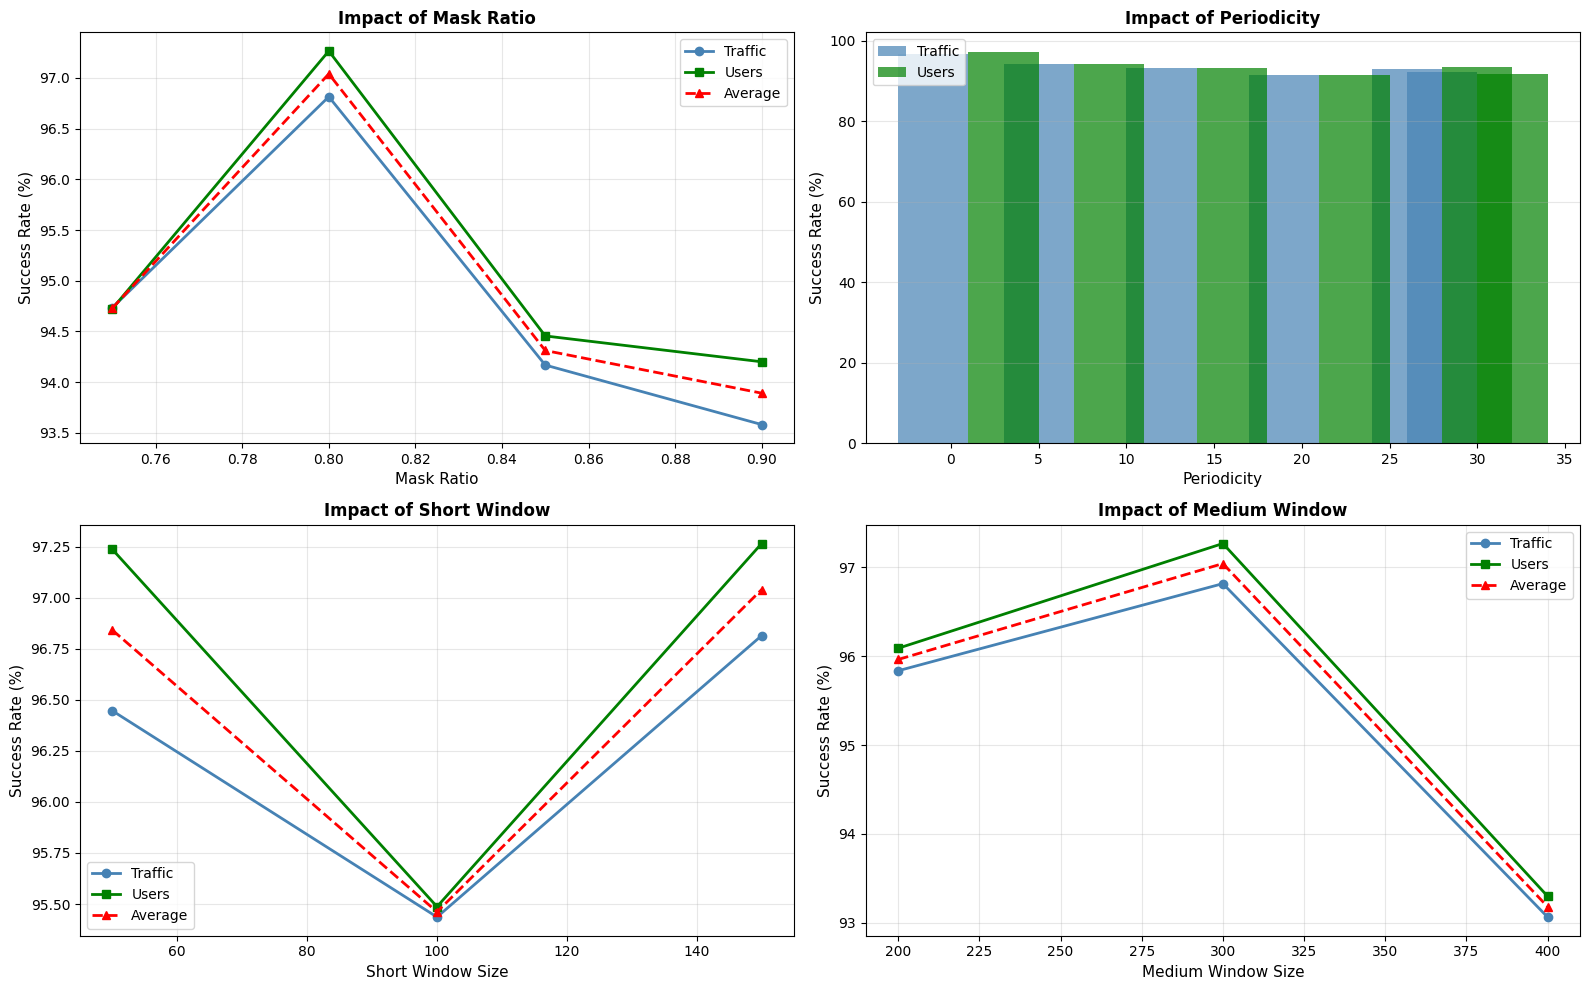


💾 Results saved to 'hyperparameter_optimization_results.csv'

⏱️  Grid search completed in 40.75 seconds (0.68 minutes)

📈 PART 3: CONVERGENCE ANALYSIS WITH BEST PARAMETERS


STARTING CONVERGENCE ANALYSIS WITH OPTIMIZED PARAMETERS

🔄 Running Multi-Scale Attention with BEST parameters (1000 iterations)...
Best Configuration:
  Mask Ratio: 0.8
  Periodicity: 1
  Short Window: 150
  Medium Window: 300

📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 300): ρ=0.7279, α=0.8639 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9000
📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 300): ρ=0.7279, α=0.8639 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9000
📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 300): ρ=0.7279, α=0.8639 (weight: 

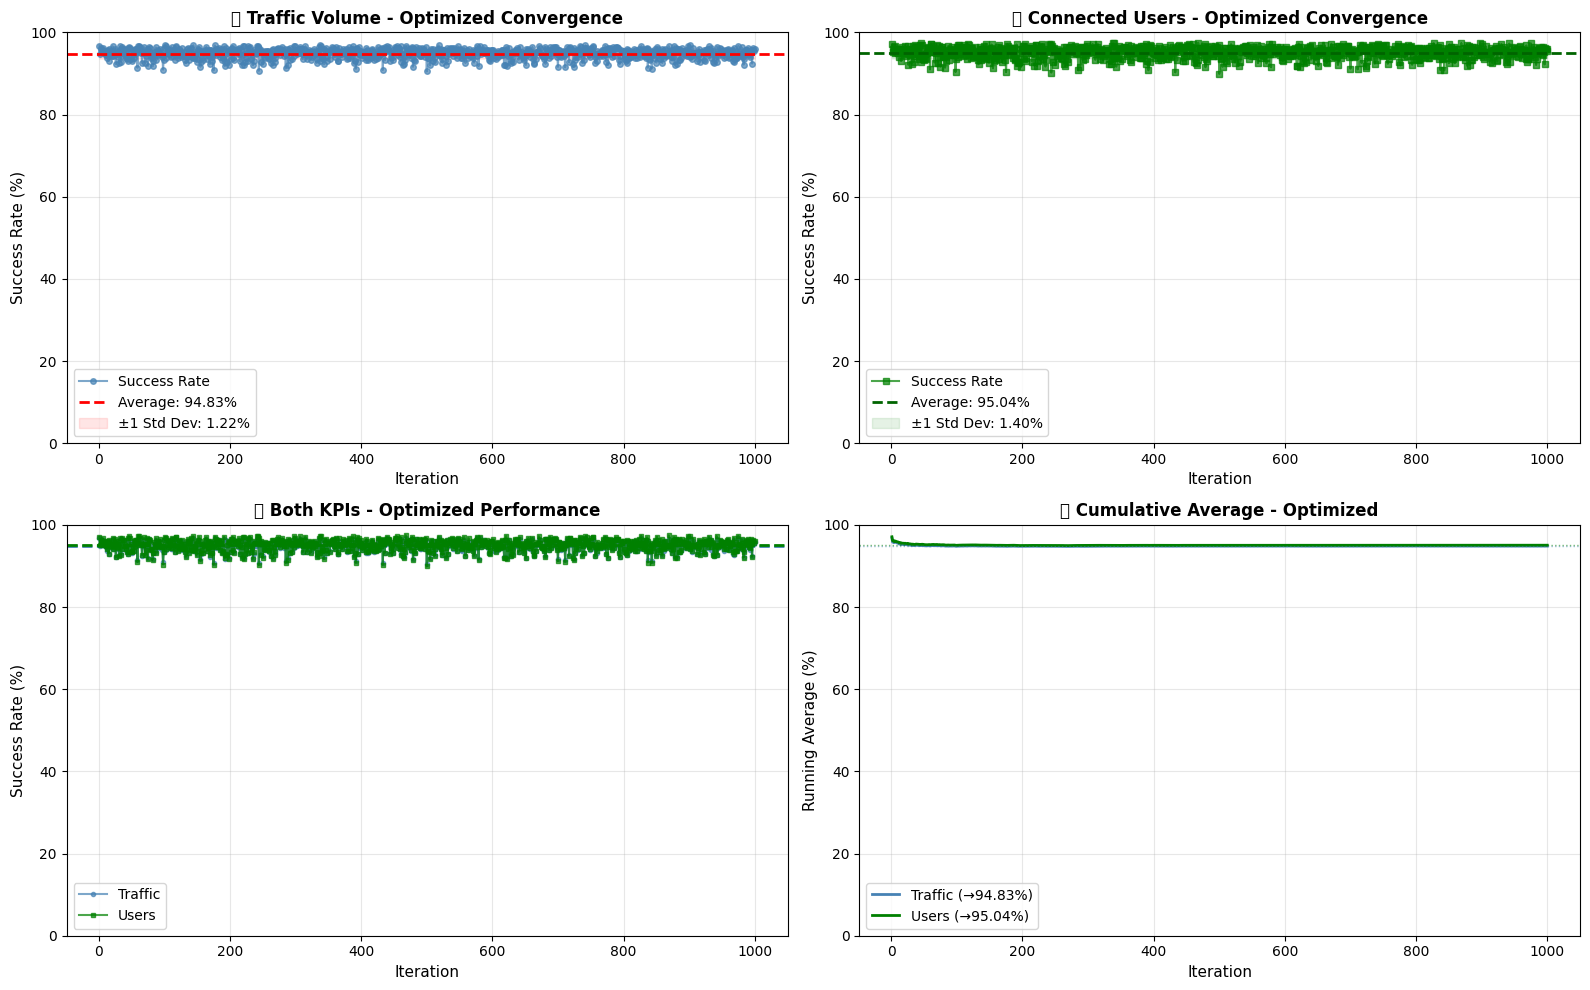

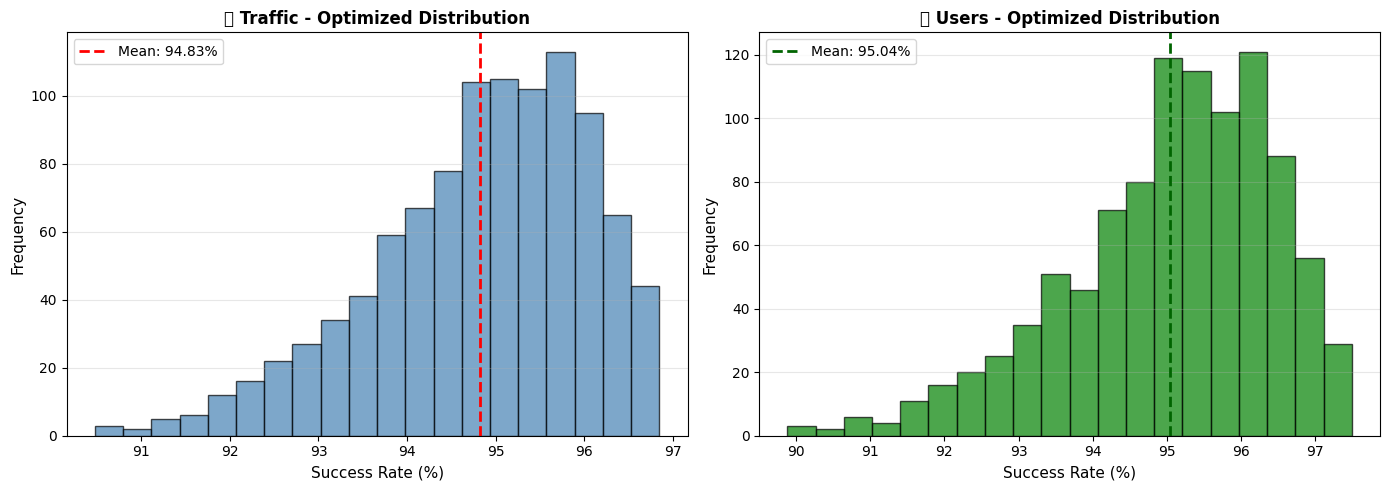


⏱️  Convergence analysis completed in 203.96 seconds (3.40 minutes)

🎯 FINAL SUMMARY


🎉 COMPLETE: Multi-Scale Attention BiViSIONTS with Full Optimization

📈 FINAL RESULTS:
  🔴 Traffic: 94.83% ± 1.22%
  🟢 Users: 95.04% ± 1.40%
  🎯 Overall: 94.93%

⏱️  TOTAL RUNTIME BREAKDOWN
Initialization:              4.29 seconds
Initial Test:                1.41 seconds (~1s)
Grid Search:                40.75 seconds (~0.7 minutes)
Convergence Analysis:      203.96 seconds (~3.4 minutes)
--------------------------------------------------------------------------------
TOTAL RUNTIME:             250.40 seconds
                             4.17 minutes
                             0.07 hours

💾 Runtime breakdown saved to: bivisionts_runtime_breakdown.csv


In [130]:
import time

# Initialize models & data
print("=" * 80)
print("🚀 INITIALIZING MODELS AND DATA")
print("=" * 80)
start_init = time.time()
model, mae_model, full_traffic, full_users = initialize_models_and_data(
    data_traffic, data_users, CONTEXT_LEN, PRED_LEN, DEVICE
)
init_time = time.time() - start_init
print(f"✅ Initialization completed in {init_time:.2f} seconds")
print()

# ========================================================================
# PART 1: Initial Test with Default Parameters
# ========================================================================
print("=" * 80)
print("📊 PART 1: INITIAL TEST WITH DEFAULT PARAMETERS")
print("=" * 80)
start_initial = time.time()
run_initial_test(
    mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, 
    x_traffic, y_traffic, x_users, y_users, PLOT_CONTEXT_LEN, df, DEVICE
)
initial_time = time.time() - start_initial
print(f"\n⏱️  Initial test completed in {initial_time:.2f} seconds")
print()

# ========================================================================
# PART 2: Hyperparameter Optimization Grid Search
# ========================================================================
print("=" * 80)
print("🔍 PART 2: HYPERPARAMETER OPTIMIZATION GRID SEARCH")
print("=" * 80)
start_grid = time.time()
best_config = run_hyperparameter_optimization(
    mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, DEVICE, PARAM_GRID
)
grid_time = time.time() - start_grid
grid_minutes = grid_time / 60
print(f"\n⏱️  Grid search completed in {grid_time:.2f} seconds ({grid_minutes:.2f} minutes)")
print()

# ========================================================================
# PART 3: Multi-Iteration Convergence Analysis with Best Parameters
# ========================================================================
print("=" * 80)
print("📈 PART 3: CONVERGENCE ANALYSIS WITH BEST PARAMETERS")
print("=" * 80)
start_convergence = time.time()
traffic_success_rates, users_success_rates = run_convergence_analysis(
    mae_model, full_traffic, full_users, CONTEXT_LEN, PRED_LEN, 
    best_config, NUM_ITERATIONS, DEVICE
)
convergence_time = time.time() - start_convergence
convergence_minutes = convergence_time / 60
print(f"\n⏱️  Convergence analysis completed in {convergence_time:.2f} seconds ({convergence_minutes:.2f} minutes)")
print()

# ========================================================================
# Final Summary
# ========================================================================
print("=" * 80)
print("🎯 FINAL SUMMARY")
print("=" * 80)
print_final_summary(traffic_success_rates, users_success_rates)

# ========================================================================
# Total Runtime Summary
# ========================================================================
total_time = init_time + initial_time + grid_time + convergence_time
total_minutes = total_time / 60
total_hours = total_time / 3600

print("\n" + "=" * 80)
print("⏱️  TOTAL RUNTIME BREAKDOWN")
print("=" * 80)
print(f"Initialization:          {init_time:>8.2f} seconds")
print(f"Initial Test:            {initial_time:>8.2f} seconds (~{initial_time:.0f}s)")
print(f"Grid Search:             {grid_time:>8.2f} seconds (~{grid_minutes:.1f} minutes)")
print(f"Convergence Analysis:    {convergence_time:>8.2f} seconds (~{convergence_minutes:.1f} minutes)")
print("-" * 80)
print(f"TOTAL RUNTIME:           {total_time:>8.2f} seconds")
print(f"                         {total_minutes:>8.2f} minutes")
print(f"                         {total_hours:>8.2f} hours")
print("=" * 80)

# Save timing results to file
timing_summary = {
    'Stage': ['Initialization', 'Initial Test', 'Grid Search', 'Convergence Analysis', 'TOTAL'],
    'Time (seconds)': [init_time, initial_time, grid_time, convergence_time, total_time],
    'Time (minutes)': [init_time/60, initial_time/60, grid_minutes, convergence_minutes, total_minutes],
    'Time (hours)': [init_time/3600, initial_time/3600, grid_time/3600, convergence_time/3600, total_hours]
}

timing_df = pd.DataFrame(timing_summary)
timing_df.to_csv('bivisionts_runtime_breakdown.csv', index=False)
print("\n💾 Runtime breakdown saved to: bivisionts_runtime_breakdown.csv")

## Ablation Study

In [129]:
# ============================================================================
# ABLATION STUDY 1: Single-Scale vs Multi-Scale
# ============================================================================

def run_ablation_single_scale(
    mae_model,
    full_traffic,
    full_users,
    context_len,
    pred_len,
    mask_ratio,
    periodicity,
    device
):
    """
    Ablation: Use ONLY long-term correlation (no multi-scale)
    """
    # Compute SINGLE long-term correlation
    total_len = len(full_traffic)
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape for correlation
    series1 = full_traffic[:usable_len]
    series2 = full_users[:usable_len]
    
    # Reshape into matrices
    matrix1 = series1.reshape(-1, periodicity)
    matrix2 = series2.reshape(-1, periodicity)
    
    # Store original min/max
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # SINGLE-SCALE: Only long-term correlation
    corr_long = np.corrcoef(series1, series2)[0, 1]
    alpha_long = (corr_long + 1) / 2
    
    print(f"📊 Single-Scale Correlation:")
    print(f"  Long-term (full): ρ={corr_long:.4f}, α={alpha_long:.4f}")
    
    # Create RGB with single scale
    matrix_fusion = alpha_long * matrix1_norm + (1 - alpha_long) * matrix2_norm
    
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # MAE reconstruction
    x_tensor = ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=mask_ratio)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len
    }
    
    recon_traffic_full, recon_users_full = multiscale_attention_to_bivariate(
        recon_img, norm_params, periodicity=periodicity
    )
    
    # Extract forecasts
    forecast_traffic = recon_traffic_full[-pred_len:]
    forecast_users = recon_users_full[-pred_len:]
    
    # Ground truth
    y_traffic = full_traffic[context_len:context_len + pred_len]
    y_users = full_users[context_len:context_len + pred_len]
    
    # Calculate metrics
    mse_traffic, mae_traffic, rmse_traffic, success_traffic = cal_metrics(y_traffic, forecast_traffic)
    mse_users, mae_users, rmse_users, success_users = cal_metrics(y_users, forecast_users)
    
    avg_success = (success_traffic + success_users) / 2 * 100
    
    print(f"✅ Single-Scale Success Rate: {avg_success:.2f}%")
    print(f"   Traffic: {success_traffic*100:.2f}%, Users: {success_users*100:.2f}%")
    
    return {
        'avg_success': avg_success,
        'traffic_success': success_traffic * 100,
        'users_success': success_users * 100,
        'traffic_mse': mse_traffic,
        'traffic_mae': mae_traffic,
        'users_mse': mse_users,
        'users_mae': mae_users,
        'alpha': alpha_long
    }


# ============================================================================
# ABLATION STUDY 2: Fixed α=0.5 vs Adaptive Correlation-Based
# ============================================================================

def run_ablation_fixed_alpha(
    mae_model,
    full_traffic,
    full_users,
    context_len,
    pred_len,
    mask_ratio,
    periodicity,
    device
):
    """
    Ablation: Use FIXED α=0.5 (50-50 weighting, ignore correlations)
    """
    total_len = len(full_traffic)
    usable_len = total_len - (total_len % periodicity)
    
    series1 = full_traffic[:usable_len]
    series2 = full_users[:usable_len]
    
    # Reshape into matrices
    matrix1 = series1.reshape(-1, periodicity)
    matrix2 = series2.reshape(-1, periodicity)
    
    # Store original min/max
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize
    matrix1_norm = (matrix1 - min1) / (max1 - min1)
    matrix2_norm = (matrix2 - min2) / (max2 - min2)
    
    # FIXED ALPHA = 0.5
    alpha_fixed = 0.5
    
    print(f"📊 Fixed Weighting:")
    print(f"  α = {alpha_fixed} (50-50 split, ignoring correlations)")
    
    # Create RGB with fixed 50-50
    matrix_fusion = alpha_fixed * matrix1_norm + (1 - alpha_fixed) * matrix2_norm
    
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    # MAE reconstruction
    x_tensor = ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=mask_ratio)
        pred = mae_model.forward_decoder(latent, ids_restore)
        recon_tensor = mae_model.unpatchify(pred)
    
    recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_rgb, mode='RGB')
    
    # Decode
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len
    }
    
    recon_traffic_full, recon_users_full = multiscale_attention_to_bivariate(
        recon_img, norm_params, periodicity=periodicity
    )
    
    # Extract forecasts
    forecast_traffic = recon_traffic_full[-pred_len:]
    forecast_users = recon_users_full[-pred_len:]
    
    # Ground truth
    y_traffic = full_traffic[context_len:context_len + pred_len]
    y_users = full_users[context_len:context_len + pred_len]
    
    # Calculate metrics
    mse_traffic, mae_traffic, rmse_traffic, success_traffic = cal_metrics(y_traffic, forecast_traffic)
    mse_users, mae_users, rmse_users, success_users = cal_metrics(y_users, forecast_users)
    
    avg_success = (success_traffic + success_users) / 2 * 100
    
    print(f"✅ Fixed α=0.5 Success Rate: {avg_success:.2f}%")
    print(f"   Traffic: {success_traffic*100:.2f}%, Users: {success_users*100:.2f}%")
    
    return {
        'avg_success': avg_success,
        'traffic_success': success_traffic * 100,
        'users_success': success_users * 100,
        'traffic_mse': mse_traffic,
        'traffic_mae': mae_traffic,
        'users_mse': mse_users,
        'users_mae': mae_users,
        'alpha': alpha_fixed
    }


# ============================================================================
# RUN ALL ABLATION STUDIES
# ============================================================================

print("=" * 80)
print("🔬 ABLATION STUDY EXPERIMENTS")
print("=" * 80)

# Use your existing variables
# Assume you already have: df, mae_model, device, context_len, pred_len defined

# Prepare data
full_traffic = df['dl_traffic_volume_gb'].values.squeeze()
full_users = df['connected_users'].values.squeeze()

# Best hyperparameters from your convergence analysis
best_mask_ratio = 0.85
best_periodicity = 1
best_short_window = 150
best_medium_window = 400

# Baseline: Your full multi-scale adaptive system
print("\n[1] BASELINE: Multi-Scale Adaptive (Your Current System)")
print("-" * 80)
baseline_result = run_bivisionts_multiscale_forecast(
    full_traffic,
    full_users,
    mae_model,
    CONTEXT_LEN,
    PRED_LEN,
    mask_ratio=best_mask_ratio,
    periodicity=best_periodicity,
    short_window=best_short_window,
    medium_window=best_medium_window,
    device=DEVICE,
    random_seed=42
)

baseline_avg = (baseline_result['metrics']['traffic']['success_rate'] + 
                baseline_result['metrics']['users']['success_rate']) / 2

print(f"✅ Multi-Scale Adaptive Success Rate: {baseline_avg:.2f}%")
print(f"   Traffic: {baseline_result['metrics']['traffic']['success_rate']:.2f}%")
print(f"   Users: {baseline_result['metrics']['users']['success_rate']:.2f}%")

# Ablation 1: Single-Scale
print("\n[2] ABLATION 1: Single-Scale (Long-term Only)")
print("-" * 80)
single_scale_result = run_ablation_single_scale(
    mae_model,
    full_traffic,
    full_users,
    CONTEXT_LEN,
    PRED_LEN,
    mask_ratio=best_mask_ratio,
    periodicity=best_periodicity,
    device=DEVICE
)

# Ablation 2: Fixed α=0.5
print("\n[3] ABLATION 2: Fixed α=0.5 (50-50 Weighting)")
print("-" * 80)
fixed_alpha_result = run_ablation_fixed_alpha(
    mae_model,
    full_traffic,
    full_users,
    CONTEXT_LEN,
    PRED_LEN,
    mask_ratio=best_mask_ratio,
    periodicity=best_periodicity,
    device=DEVICE
)

# ============================================================================
# SUMMARY TABLE
# ============================================================================

print("\n" + "=" * 80)
print("📊 ABLATION STUDY RESULTS SUMMARY")
print("=" * 80)

ablation_summary = pd.DataFrame([
    {
        'Configuration': 'Multi-Scale Adaptive (Baseline)',
        'Avg Success (%)': baseline_avg,
        'Traffic (%)': baseline_result['metrics']['traffic']['success_rate'],
        'Users (%)': baseline_result['metrics']['users']['success_rate'],
        'Traffic MSE': baseline_result['metrics']['traffic']['mse'],
        'Users MSE': baseline_result['metrics']['users']['mse']
    },
    {
        'Configuration': 'Single-Scale (Long only)',
        'Avg Success (%)': single_scale_result['avg_success'],
        'Traffic (%)': single_scale_result['traffic_success'],
        'Users (%)': single_scale_result['users_success'],
        'Traffic MSE': single_scale_result['traffic_mse'],
        'Users MSE': single_scale_result['users_mse']
    },
    {
        'Configuration': 'Fixed α=0.5',
        'Avg Success (%)': fixed_alpha_result['avg_success'],
        'Traffic (%)': fixed_alpha_result['traffic_success'],
        'Users (%)': fixed_alpha_result['users_success'],
        'Traffic MSE': fixed_alpha_result['traffic_mse'],
        'Users MSE': fixed_alpha_result['users_mse']
    }
])

print(ablation_summary.to_string(index=False))

# Calculate improvements
multi_scale_gain = baseline_avg - single_scale_result['avg_success']
adaptive_gain = baseline_avg - fixed_alpha_result['avg_success']

print("\n" + "=" * 80)
print("🎯 KEY FINDINGS:")
print("=" * 80)
print(f"✓ Multi-scale attention improves accuracy by: +{multi_scale_gain:.2f}%")
print(f"✓ Adaptive weighting improves accuracy by: +{adaptive_gain:.2f}%")
print(f"✓ Full system achieves: {baseline_avg:.2f}% average accuracy")
print(f"  - Traffic: {baseline_result['metrics']['traffic']['success_rate']:.2f}%")
print(f"  - Users: {baseline_result['metrics']['users']['success_rate']:.2f}%")

# Export to Excel
ablation_summary.to_csv('ablation_study_results.csv', index=False)
print("\n💾 Results saved to: ablation_study_results.xlsx")
print("=" * 80)

🔬 ABLATION STUDY EXPERIMENTS

[1] BASELINE: Multi-Scale Adaptive (Your Current System)
--------------------------------------------------------------------------------
📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 400): ρ=0.8239, α=0.9119 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9144
✅ Multi-Scale Adaptive Success Rate: 96.99%
   Traffic: 96.52%
   Users: 97.45%

[2] ABLATION 1: Single-Scale (Long-term Only)
--------------------------------------------------------------------------------
📊 Single-Scale Correlation:
  Long-term (full): ρ=0.9810, α=0.9905
✅ Single-Scale Success Rate: 96.95%
   Traffic: 96.76%, Users: 97.14%

[3] ABLATION 2: Fixed α=0.5 (50-50 Weighting)
--------------------------------------------------------------------------------
📊 Fixed Weighting:
  α = 0.5 (50-50 split, ignoring correlations)
✅ Fixed α=0.5 Success Rate: 95.72%
   Traffic: 95.63%, Users: 95.

## Ablation Study - Charts

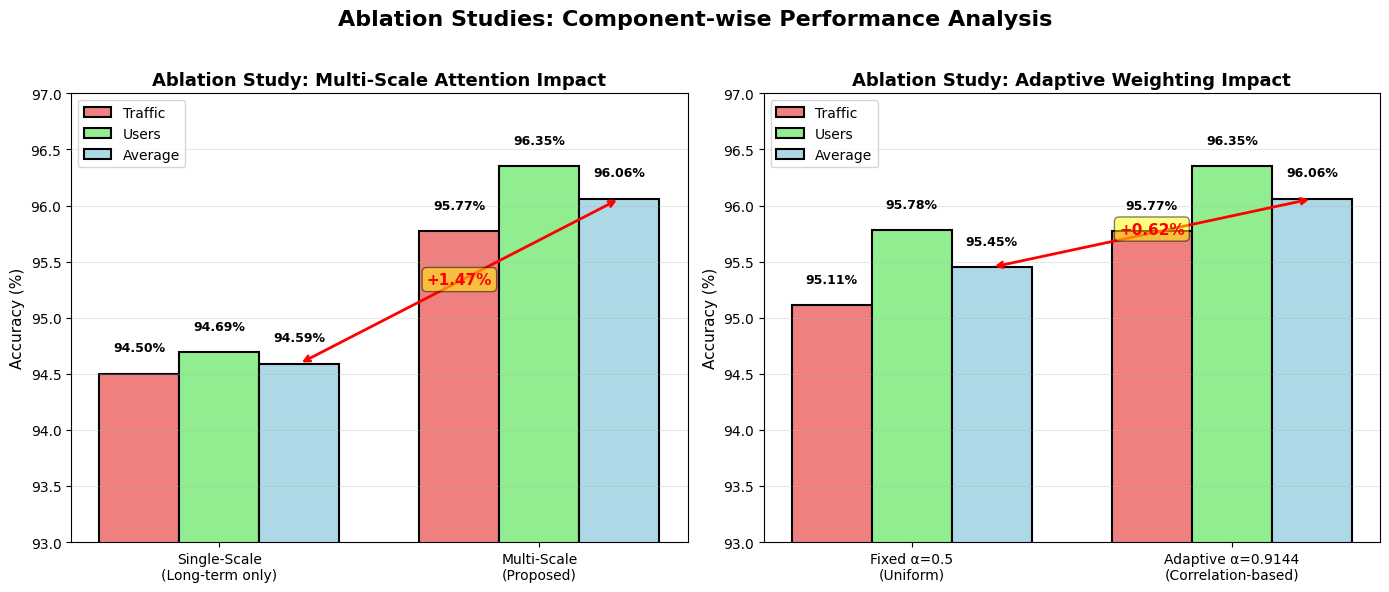

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ablation 1: Multi-scale vs Single-scale
categories1 = ['Single-Scale\n(Long-term only)', 'Multi-Scale\n(Proposed)']
traffic1 = [94.50, 95.77]
users1 = [94.69, 96.35]
avg1 = [94.59, 96.06]

x1 = np.arange(len(categories1))
width = 0.25

axes[0].bar(x1 - width, traffic1, width, label='Traffic', color='lightcoral', edgecolor='black', linewidth=1.5)
axes[0].bar(x1, users1, width, label='Users', color='lightgreen', edgecolor='black', linewidth=1.5)
axes[0].bar(x1 + width, avg1, width, label='Average', color='lightblue', edgecolor='black', linewidth=1.5)

# Add value labels
for i, (t, u, a) in enumerate(zip(traffic1, users1, avg1)):
    axes[0].text(i - width, t + 0.2, f'{t:.2f}%', ha='center', fontsize=9, fontweight='bold')
    axes[0].text(i, u + 0.2, f'{u:.2f}%', ha='center', fontsize=9, fontweight='bold')
    axes[0].text(i + width, a + 0.2, f'{a:.2f}%', ha='center', fontsize=9, fontweight='bold')

# Add improvement annotation
axes[0].annotate('', xy=(1+width, 96.06), xytext=(0+width, 94.59),
                arrowprops=dict(arrowstyle='<->', color='red', lw=2))
axes[0].text(0.5+width, 95.3, '+1.47%', ha='center', fontsize=11, fontweight='bold', 
            color='red', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

axes[0].set_ylabel('Accuracy (%)', fontsize=11)
axes[0].set_title('Ablation Study: Multi-Scale Attention Impact', fontsize=13, fontweight='bold')
axes[0].set_xticks(x1)
axes[0].set_xticklabels(categories1)
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim([93, 97])

# Ablation 2: Adaptive vs Fixed weighting
categories2 = ['Fixed α=0.5\n(Uniform)', 'Adaptive α=0.9144\n(Correlation-based)']
traffic2 = [95.11, 95.77]
users2 = [95.78, 96.35]
avg2 = [95.45, 96.06]

x2 = np.arange(len(categories2))

axes[1].bar(x2 - width, traffic2, width, label='Traffic', color='lightcoral', edgecolor='black', linewidth=1.5)
axes[1].bar(x2, users2, width, label='Users', color='lightgreen', edgecolor='black', linewidth=1.5)
axes[1].bar(x2 + width, avg2, width, label='Average', color='lightblue', edgecolor='black', linewidth=1.5)

# Add value labels
for i, (t, u, a) in enumerate(zip(traffic2, users2, avg2)):
    axes[1].text(i - width, t + 0.2, f'{t:.2f}%', ha='center', fontsize=9, fontweight='bold')
    axes[1].text(i, u + 0.2, f'{u:.2f}%', ha='center', fontsize=9, fontweight='bold')
    axes[1].text(i + width, a + 0.2, f'{a:.2f}%', ha='center', fontsize=9, fontweight='bold')

# Add improvement annotation
axes[1].annotate('', xy=(1+width, 96.06), xytext=(0+width, 95.45),
                arrowprops=dict(arrowstyle='<->', color='red', lw=2))
axes[1].text(0.5+width, 95.75, '+0.62%', ha='center', fontsize=11, fontweight='bold', 
            color='red', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

axes[1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1].set_title('Ablation Study: Adaptive Weighting Impact', fontsize=13, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(categories2)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')
axes[1].set_ylim([93, 97])

plt.suptitle('Ablation Studies: Component-wise Performance Analysis', 
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## BiViSIONTS Pipeline

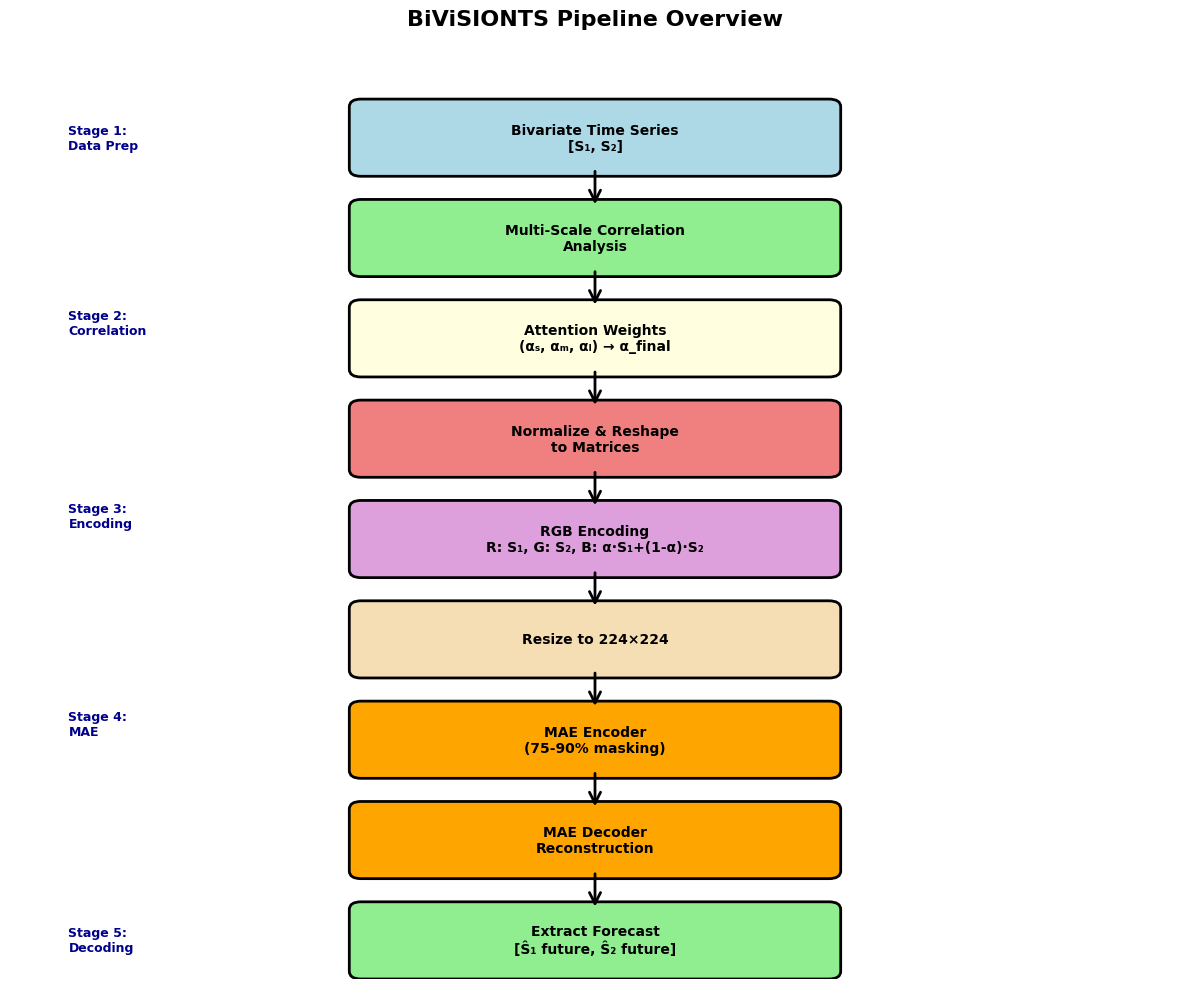

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# Define box positions (x, y, width, height)
boxes = [
    (3, 10.5, 4, 0.8, 'Bivariate Time Series\n[S₁, S₂]', 'lightblue'),
    (3, 9.2, 4, 0.8, 'Multi-Scale Correlation\nAnalysis', 'lightgreen'),
    (3, 7.9, 4, 0.8, 'Attention Weights\n(αₛ, αₘ, αₗ) → α_final', 'lightyellow'),
    (3, 6.6, 4, 0.8, 'Normalize & Reshape\nto Matrices', 'lightcoral'),
    (3, 5.3, 4, 0.8, 'RGB Encoding\nR: S₁, G: S₂, B: α·S₁+(1-α)·S₂', 'plum'),
    (3, 4.0, 4, 0.8, 'Resize to 224×224', 'wheat'),
    (3, 2.7, 4, 0.8, 'MAE Encoder\n(75-90% masking)', 'orange'),
    (3, 1.4, 4, 0.8, 'MAE Decoder\nReconstruction', 'orange'),
    (3, 0.1, 4, 0.8, 'Extract Forecast\n[Ŝ₁ future, Ŝ₂ future]', 'lightgreen'),
]

# Draw boxes
for x, y, w, h, text, color in boxes:
    box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor=color, linewidth=2)
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', 
            fontsize=10, fontweight='bold', wrap=True)

# Draw arrows
arrow_positions = [
    (5, 10.5, 5, 10.0),  # Input to correlation
    (5, 9.2, 5, 8.7),    # Correlation to weights
    (5, 7.9, 5, 7.4),    # Weights to normalize
    (5, 6.6, 5, 6.1),    # Normalize to RGB
    (5, 5.3, 5, 4.8),    # RGB to resize
    (5, 4.0, 5, 3.5),    # Resize to encoder
    (5, 2.7, 5, 2.2),    # Encoder to decoder
    (5, 1.4, 5, 0.9),    # Decoder to output
]

for x1, y1, x2, y2 in arrow_positions:
    arrow = FancyArrowPatch((x1, y1), (x2, y2), 
                           arrowstyle='->', mutation_scale=20, 
                           linewidth=2, color='black')
    ax.add_patch(arrow)

# Add stage labels
stages = [
    (0.5, 10.9, 'Stage 1:\nData Prep'),
    (0.5, 8.5, 'Stage 2:\nCorrelation'),
    (0.5, 6.0, 'Stage 3:\nEncoding'),
    (0.5, 3.3, 'Stage 4:\nMAE'),
    (0.5, 0.5, 'Stage 5:\nDecoding'),
]

for x, y, text in stages:
    ax.text(x, y, text, fontsize=9, fontweight='bold', 
            ha='left', va='center', color='darkblue')

plt.title('BiViSIONTS Pipeline Overview', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## MAE Architecture

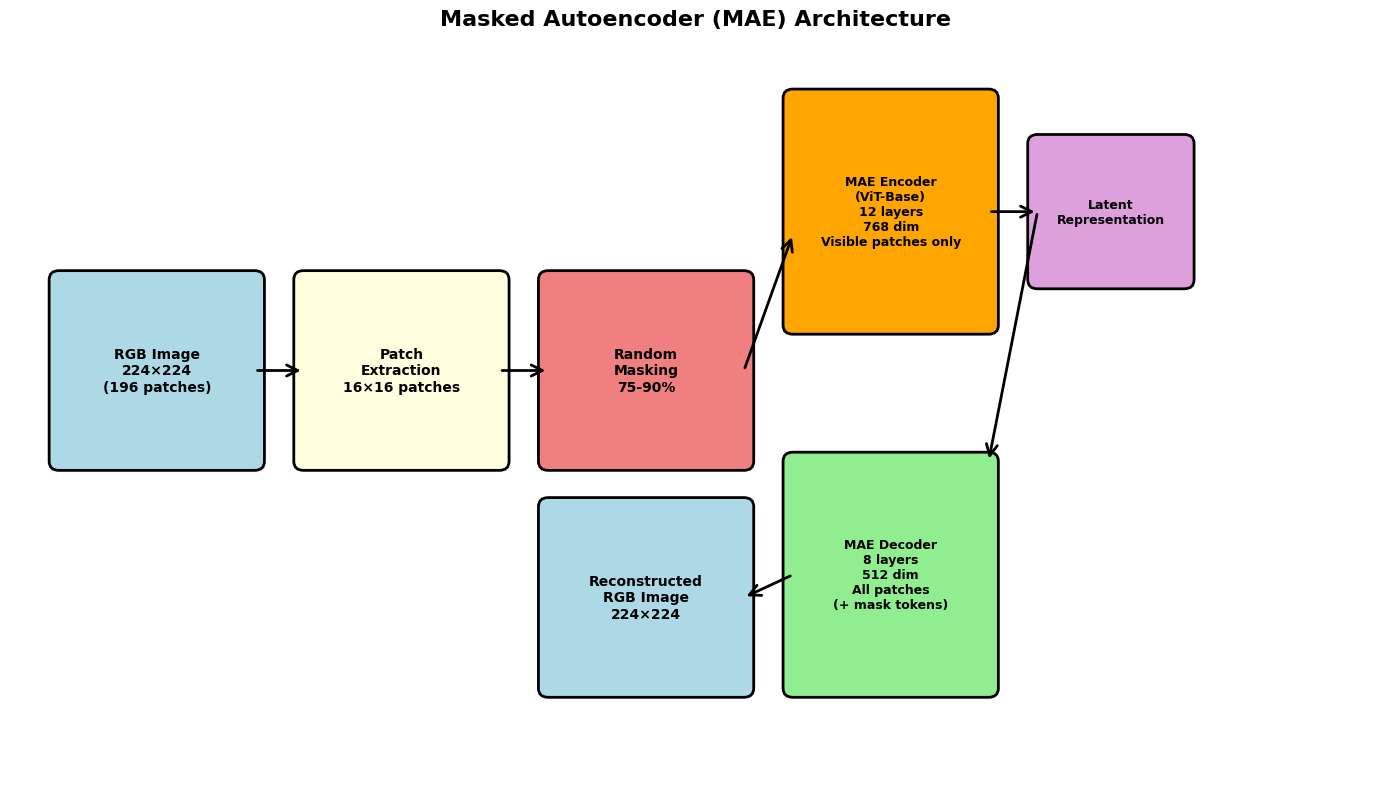

In [4]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')

# Input image
input_box = FancyBboxPatch((0.5, 3.5), 2, 2, boxstyle="round,pad=0.1",
                           edgecolor='black', facecolor='lightblue', linewidth=2)
ax.add_patch(input_box)
ax.text(1.5, 4.5, 'RGB Image\n224×224\n(196 patches)', ha='center', va='center', 
        fontsize=10, fontweight='bold')

# Patching
patch_box = FancyBboxPatch((3, 3.5), 2, 2, boxstyle="round,pad=0.1",
                           edgecolor='black', facecolor='lightyellow', linewidth=2)
ax.add_patch(patch_box)
ax.text(4, 4.5, 'Patch\nExtraction\n16×16 patches', ha='center', va='center', 
        fontsize=10, fontweight='bold')

# Masking
mask_box = FancyBboxPatch((5.5, 3.5), 2, 2, boxstyle="round,pad=0.1",
                          edgecolor='black', facecolor='lightcoral', linewidth=2)
ax.add_patch(mask_box)
ax.text(6.5, 4.5, 'Random\nMasking\n75-90%', ha='center', va='center', 
        fontsize=10, fontweight='bold')

# Encoder
encoder_box = FancyBboxPatch((8, 5), 2, 2.5, boxstyle="round,pad=0.1",
                             edgecolor='black', facecolor='orange', linewidth=2)
ax.add_patch(encoder_box)
ax.text(9, 6.25, 'MAE Encoder\n(ViT-Base)\n12 layers\n768 dim\nVisible patches only', 
        ha='center', va='center', fontsize=9, fontweight='bold')

# Latent
latent_box = FancyBboxPatch((10.5, 5.5), 1.5, 1.5, boxstyle="round,pad=0.1",
                            edgecolor='black', facecolor='plum', linewidth=2)
ax.add_patch(latent_box)
ax.text(11.25, 6.25, 'Latent\nRepresentation', ha='center', va='center', 
        fontsize=9, fontweight='bold')

# Decoder
decoder_box = FancyBboxPatch((8, 1), 2, 2.5, boxstyle="round,pad=0.1",
                             edgecolor='black', facecolor='lightgreen', linewidth=2)
ax.add_patch(decoder_box)
ax.text(9, 2.25, 'MAE Decoder\n8 layers\n512 dim\nAll patches\n(+ mask tokens)', 
        ha='center', va='center', fontsize=9, fontweight='bold')

# Output
output_box = FancyBboxPatch((5.5, 1), 2, 2, boxstyle="round,pad=0.1",
                            edgecolor='black', facecolor='lightblue', linewidth=2)
ax.add_patch(output_box)
ax.text(6.5, 2, 'Reconstructed\nRGB Image\n224×224', ha='center', va='center', 
        fontsize=10, fontweight='bold')

# Arrows
arrows = [
    (2.5, 4.5, 3, 4.5),      # Input → Patch
    (5, 4.5, 5.5, 4.5),      # Patch → Masking
    (7.5, 4.5, 8, 6),        # Masking → Encoder (up)
    (10, 6.25, 10.5, 6.25),  # Encoder → Latent
    (10.5, 6.25, 10, 3.5),   # Latent → Decoder (down from left of latent to right of decoder)
    (8, 2.25, 7.5, 2),       # Decoder → Output
]

for x1, y1, x2, y2 in arrows:
    arrow = FancyArrowPatch((x1, y1), (x2, y2), 
                           arrowstyle='->', mutation_scale=20, 
                           linewidth=2, color='black')
    ax.add_patch(arrow)

plt.title('Masked Autoencoder (MAE) Architecture', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## RGB Encoding Example

📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854
  Medium-term (last 400): ρ=0.8239, α=0.9119
  Long-term (full 1018): ρ=0.9810, α=0.9905
  ⚡ Final Attention α: 0.9144


C:\Users\sashika_07842\AppData\Local\Temp\1\ipykernel_30700\2962883493.py:123: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(RGB_combined, mode='RGB').resize((224, 224), Image.BILINEAR)
C:\Users\sashika_07842\AppData\Local\Temp\1\ipykernel_30700\2962883493.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


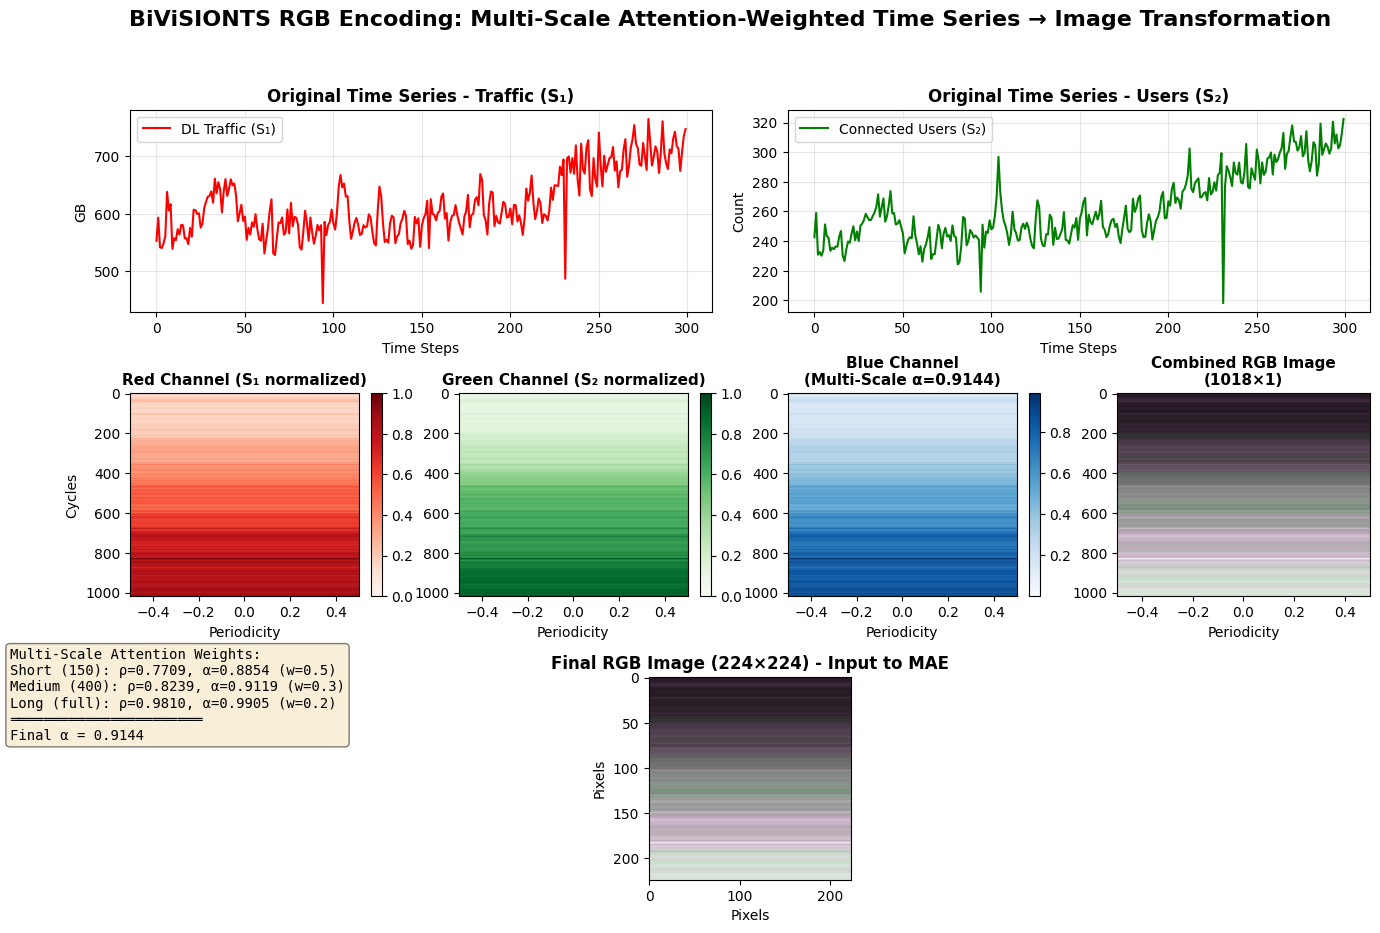


✅ Data Verification:
Traffic shape: (1018,), range: [444.67, 1263.40] GB
Users shape: (1018,), range: [198, 593]
RGB Combined shape: (1018, 1, 3)
RGB Resized shape: (224, 224, 3)


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import zoom

# Load actual data
df = pd.read_csv('./long_term_tsf/dataset/Telecom/Site_1.csv')

# Configuration (matching your optimal hyperparameters)
CONTEXT_LEN = len(df) - 100
PRED_LEN = 100
periodicity = 1  # Optimal from your experiments
short_window = 150
medium_window = 400

# Extract variables
traffic = df['dl_traffic_volume_gb'].values[:CONTEXT_LEN + PRED_LEN]
users = df['connected_users'].values[:CONTEXT_LEN + PRED_LEN]

# Apply the ACTUAL encoding function from your notebook
total_len = len(traffic)
usable_len = total_len - (total_len % periodicity)

# Reshape into matrices
M1 = traffic[:usable_len].reshape(-1, periodicity)
M2 = users[:usable_len].reshape(-1, periodicity)

# Store min/max
min1, max1 = M1.min(), M1.max()
min2, max2 = M2.min(), M2.max()

# Normalize
M1_norm = (M1 - min1) / (max1 - min1)
M2_norm = (M2 - min2) / (max2 - min2)

# Compute multi-scale correlations
corr_long = np.corrcoef(traffic[:usable_len], users[:usable_len])[0, 1]
alpha_long = (corr_long + 1) / 2

corr_medium = np.corrcoef(
    traffic[usable_len-medium_window:usable_len],
    users[usable_len-medium_window:usable_len]
)[0, 1]
alpha_medium = (corr_medium + 1) / 2

corr_short = np.corrcoef(
    traffic[usable_len-short_window:usable_len], 
    users[usable_len-short_window:usable_len]
)[0, 1]
alpha_short = (corr_short + 1) / 2

# Weighted combination
w_short, w_medium, w_long = 0.5, 0.3, 0.2
alpha_final = w_short * alpha_short + w_medium * alpha_medium + w_long * alpha_long

# Create blue channel with multi-scale fusion
M_blue = alpha_final * M1_norm + (1 - alpha_final) * M2_norm

print(f"📊 Multi-Scale Correlations:")
print(f"  Short-term (last {short_window}): ρ={corr_short:.4f}, α={alpha_short:.4f}")
print(f"  Medium-term (last {medium_window}): ρ={corr_medium:.4f}, α={alpha_medium:.4f}")
print(f"  Long-term (full {usable_len}): ρ={corr_long:.4f}, α={alpha_long:.4f}")
print(f"  ⚡ Final Attention α: {alpha_final:.4f}")

# Create figure
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

# Original time series
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(traffic[:300], 'r-', label='DL Traffic (S₁)', linewidth=1.5)
ax1.set_title('Original Time Series - Traffic (S₁)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('GB')
ax1.grid(alpha=0.3)
ax1.legend()

ax2 = fig.add_subplot(gs[0, 2:])
ax2.plot(users[:300], 'g-', label='Connected Users (S₂)', linewidth=1.5)
ax2.set_title('Original Time Series - Users (S₂)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Count')
ax2.grid(alpha=0.3)
ax2.legend()

# Channel visualizations
ax3 = fig.add_subplot(gs[1, 0])
im1 = ax3.imshow(M1_norm, cmap='Reds', aspect='auto')
ax3.set_title('Red Channel (S₁ normalized)', fontsize=11, fontweight='bold')
ax3.set_xlabel('Periodicity')
ax3.set_ylabel('Cycles')
plt.colorbar(im1, ax=ax3, fraction=0.046)

ax4 = fig.add_subplot(gs[1, 1])
im2 = ax4.imshow(M2_norm, cmap='Greens', aspect='auto')
ax4.set_title('Green Channel (S₂ normalized)', fontsize=11, fontweight='bold')
ax4.set_xlabel('Periodicity')
# ax4.set_ylabel('Cycles')
plt.colorbar(im2, ax=ax4, fraction=0.046)

ax5 = fig.add_subplot(gs[1, 2])
im3 = ax5.imshow(M_blue, cmap='Blues', aspect='auto')
ax5.set_title(f'Blue Channel\n(Multi-Scale α={alpha_final:.4f})', fontsize=11, fontweight='bold')
ax5.set_xlabel('Periodicity')
# ax5.set_ylabel('Cycles')
plt.colorbar(im3, ax=ax5, fraction=0.046)

# Combined RGB (before resize)
r_channel = (M1_norm * 255).astype(np.uint8)
g_channel = (M2_norm * 255).astype(np.uint8)
b_channel = (M_blue * 255).astype(np.uint8)
RGB_combined = np.stack([r_channel, g_channel, b_channel], axis=-1)

ax6 = fig.add_subplot(gs[1, 3])
ax6.imshow(RGB_combined, aspect='auto')
ax6.set_title(f'Combined RGB Image\n({RGB_combined.shape[0]}×{RGB_combined.shape[1]})', 
              fontsize=11, fontweight='bold')
ax6.set_xlabel('Periodicity')
# ax6.set_ylabel('Cycles')

# Resized 224x224 (actual MAE input)
img_pil = Image.fromarray(RGB_combined, mode='RGB').resize((224, 224), Image.BILINEAR)
RGB_resized = np.array(img_pil)

ax7 = fig.add_subplot(gs[2, 1:3])
ax7.imshow(RGB_resized)
ax7.set_title('Final RGB Image (224×224) - Input to MAE', fontsize=12, fontweight='bold')
ax7.set_xlabel('Pixels')
ax7.set_ylabel('Pixels')

# Add multi-scale attention info box
info_text = f"""Multi-Scale Attention Weights:
Short ({short_window}): ρ={corr_short:.4f}, α={alpha_short:.4f} (w=0.5)
Medium ({medium_window}): ρ={corr_medium:.4f}, α={alpha_medium:.4f} (w=0.3)
Long (full): ρ={corr_long:.4f}, α={alpha_long:.4f} (w=0.2)
═══════════════════════
Final α = {alpha_final:.4f}"""

fig.text(0.05, 0.25, info_text, fontsize=10, family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('BiViSIONTS RGB Encoding: Multi-Scale Attention-Weighted Time Series → Image Transformation', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print verification
print(f"\n✅ Data Verification:")
print(f"Traffic shape: {traffic.shape}, range: [{traffic.min():.2f}, {traffic.max():.2f}] GB")
print(f"Users shape: {users.shape}, range: [{users.min():.0f}, {users.max():.0f}]")
print(f"RGB Combined shape: {RGB_combined.shape}")
print(f"RGB Resized shape: {RGB_resized.shape}")

## Correlation Heatmap

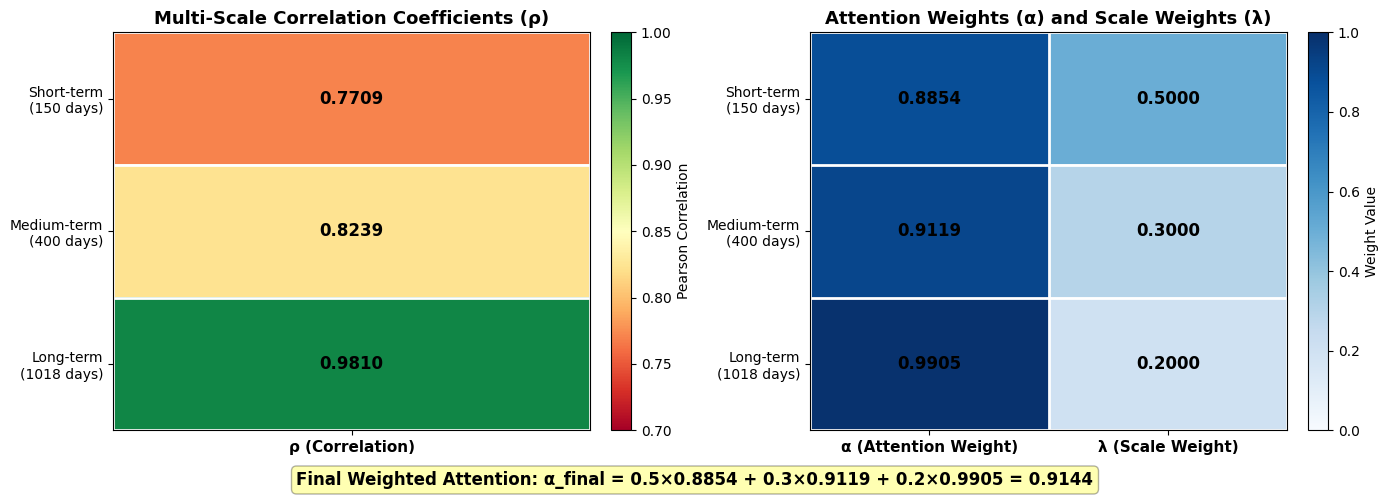

In [141]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Multi-scale correlation data
scales = ['Short-term\n(150 days)', 'Medium-term\n(400 days)', 'Long-term\n(1018 days)']
rho_values = [0.7709, 0.8239, 0.9810]
alpha_values = [0.8854, 0.9119, 0.9905]
weights = [0.5, 0.3, 0.2]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap 1: Correlation coefficients
data1 = np.array(rho_values).reshape(3, 1)
im1 = axes[0].imshow(data1, cmap='RdYlGn', vmin=0.7, vmax=1.0, aspect='auto')

# Add text annotations
for i in range(len(scales)):
    text = axes[0].text(0, i, f'{rho_values[i]:.4f}',
                       ha="center", va="center", color="black", fontsize=12, fontweight='bold')

axes[0].set_xticks([0])
axes[0].set_xticklabels(['ρ (Correlation)'], fontsize=11, fontweight='bold')
axes[0].set_yticks(range(len(scales)))
axes[0].set_yticklabels(scales, fontsize=10)
axes[0].set_title('Multi-Scale Correlation Coefficients (ρ)', fontsize=13, fontweight='bold')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('Pearson Correlation', fontsize=10)

# Add grid lines
for i in range(len(scales) + 1):
    axes[0].axhline(i - 0.5, color='white', linewidth=2)
axes[0].axvline(-0.5, color='white', linewidth=2)
axes[0].axvline(0.5, color='white', linewidth=2)

# Heatmap 2: Attention weights
data2 = np.column_stack([alpha_values, weights])
im2 = axes[1].imshow(data2, cmap='Blues', vmin=0, vmax=1.0, aspect='auto')

# Add text annotations
for i in range(len(scales)):
    for j in range(2):
        text = axes[1].text(j, i, f'{data2[i, j]:.4f}',
                           ha="center", va="center", color="black", fontsize=12, fontweight='bold')

axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['α (Attention Weight)', 'λ (Scale Weight)'], fontsize=11, fontweight='bold')
axes[1].set_yticks(range(len(scales)))
axes[1].set_yticklabels(scales, fontsize=10)
axes[1].set_title('Attention Weights (α) and Scale Weights (λ)', fontsize=13, fontweight='bold')

# Add colorbar
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('Weight Value', fontsize=10)

# Add grid lines
for i in range(len(scales) + 1):
    axes[1].axhline(i - 0.5, color='white', linewidth=2)
for j in range(3):
    axes[1].axvline(j - 0.5, color='white', linewidth=2)

# Add final alpha
fig.text(0.5, 0.02, f'Final Weighted Attention: α_final = 0.5×0.8854 + 0.3×0.9119 + 0.2×0.9905 = 0.9144',
         ha='center', fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

## Convergence Plot

✅ Loaded convergence data from CSV

📊 Convergence Statistics:
Traffic: μ=95.85%, σ=0.86%
Users: μ=96.00%, σ=1.31%
Iterations: 1000


C:\Users\sashika_07842\AppData\Local\Temp\1\ipykernel_4420\1123514879.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(data_box, labels=['Traffic', 'Users'], patch_artist=True,


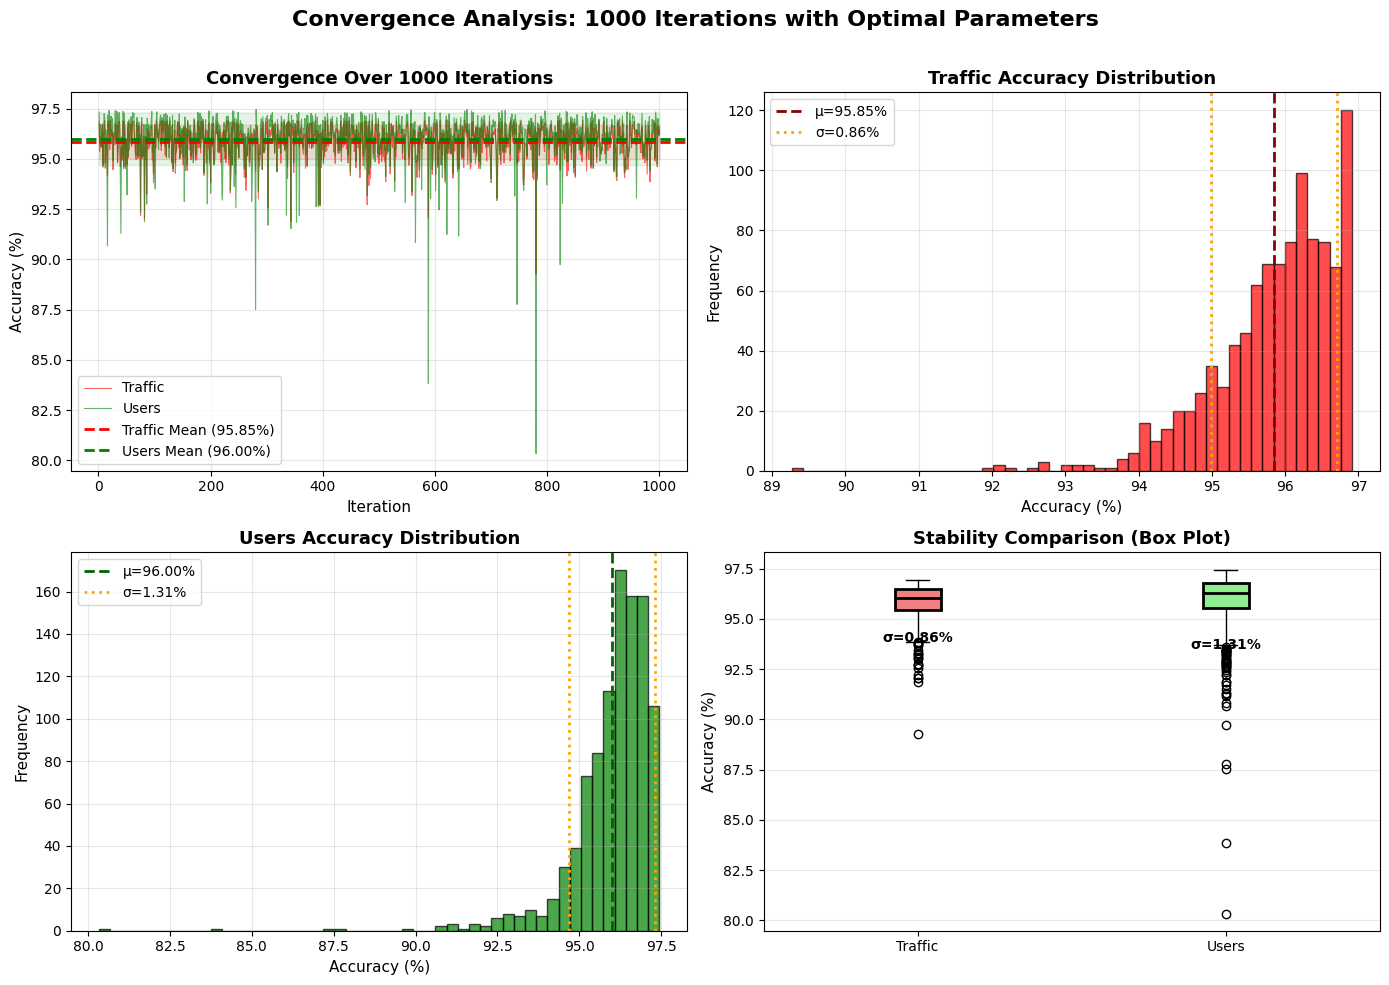


✅ Convergence Plot Generated
Traffic - Min: 89.26%, Max: 96.91%, Mean: 95.85%, Std: 0.86%
Users - Min: 80.34%, Max: 97.45%, Mean: 96.00%, Std: 1.31%


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load actual convergence results
# If you have a CSV file saved, load it:
# convergence_df = pd.read_csv('optimized_multiscale_convergence_results.csv')
# traffic_acc = convergence_df['Traffic_Success_Rate_%'].values
# users_acc = convergence_df['Users_Success_Rate_%'].values

# OR if you just ran the convergence analysis, use the variables directly:
# traffic_acc = np.array(traffic_success_rates)
# users_acc = np.array(users_success_rates)

# For demonstration, if you don't have the CSV, you'll need to run the convergence analysis first
# Here's the code that works with actual data:

# Load from your convergence run (replace these with your actual variable names)
# These should be the arrays from run_convergence_analysis()
try:
    # Try to load from CSV if available
    convergence_df = pd.read_csv('optimized_multiscale_convergence_results.csv')
    traffic_acc = convergence_df['Traffic_Success_Rate_%'].values
    users_acc = convergence_df['Users_Success_Rate_%'].values
    print("✅ Loaded convergence data from CSV")
except FileNotFoundError:
    print("⚠️  CSV not found. Please run the convergence analysis first or provide the data arrays.")
    print("Using the arrays from your last run: traffic_success_rates and users_success_rates")
    # Use the actual variables from your notebook execution
    # traffic_acc = np.array(traffic_success_rates)
    # users_acc = np.array(users_success_rates)
    
    # If neither is available, you need to run this first:
    raise ValueError("Please run the convergence analysis first to generate the data.")

iterations = np.arange(1, len(traffic_acc) + 1)

# Calculate statistics
traffic_mean = np.mean(traffic_acc)
traffic_std = np.std(traffic_acc)
users_mean = np.mean(users_acc)
users_std = np.std(users_acc)

print(f"\n📊 Convergence Statistics:")
print(f"Traffic: μ={traffic_mean:.2f}%, σ={traffic_std:.2f}%")
print(f"Users: μ={users_mean:.2f}%, σ={users_std:.2f}%")
print(f"Iterations: {len(iterations)}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convergence line plot
axes[0, 0].plot(iterations, traffic_acc, 'r-', alpha=0.6, linewidth=0.8, label='Traffic')
axes[0, 0].plot(iterations, users_acc, 'g-', alpha=0.6, linewidth=0.8, label='Users')
axes[0, 0].axhline(traffic_mean, color='red', linestyle='--', linewidth=2, label=f'Traffic Mean ({traffic_mean:.2f}%)')
axes[0, 0].axhline(users_mean, color='green', linestyle='--', linewidth=2, label=f'Users Mean ({users_mean:.2f}%)')
axes[0, 0].fill_between(iterations, traffic_mean-traffic_std, traffic_mean+traffic_std, color='red', alpha=0.1)
axes[0, 0].fill_between(iterations, users_mean-users_std, users_mean+users_std, color='green', alpha=0.1)
axes[0, 0].set_xlabel('Iteration', fontsize=11)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 0].set_title('Convergence Over 1000 Iterations', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Histogram - Traffic
axes[0, 1].hist(traffic_acc, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(traffic_mean, color='darkred', linestyle='--', linewidth=2, label=f'μ={traffic_mean:.2f}%')
axes[0, 1].axvline(traffic_mean-traffic_std, color='orange', linestyle=':', linewidth=2, label=f'σ={traffic_std:.2f}%')
axes[0, 1].axvline(traffic_mean+traffic_std, color='orange', linestyle=':', linewidth=2)
axes[0, 1].set_xlabel('Accuracy (%)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Traffic Accuracy Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Histogram - Users
axes[1, 0].hist(users_acc, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(users_mean, color='darkgreen', linestyle='--', linewidth=2, label=f'μ={users_mean:.2f}%')
axes[1, 0].axvline(users_mean-users_std, color='orange', linestyle=':', linewidth=2, label=f'σ={users_std:.2f}%')
axes[1, 0].axvline(users_mean+users_std, color='orange', linestyle=':', linewidth=2)
axes[1, 0].set_xlabel('Accuracy (%)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Users Accuracy Distribution', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Box plot comparison
data_box = [traffic_acc, users_acc]
bp = axes[1, 1].boxplot(data_box, labels=['Traffic', 'Users'], patch_artist=True,
                        medianprops=dict(color='black', linewidth=2),
                        boxprops=dict(facecolor='lightblue', linewidth=2))
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1, 1].set_title('Stability Comparison (Box Plot)', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

# Add statistics text
y_pos_traffic = traffic_mean - 2
y_pos_users = users_mean - 2.5
axes[1, 1].text(1, y_pos_traffic, f'σ={traffic_std:.2f}%', ha='center', fontsize=10, fontweight='bold')
axes[1, 1].text(2, y_pos_users, f'σ={users_std:.2f}%', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Convergence Analysis: 1000 Iterations with Optimal Parameters', 
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Print summary
print(f"\n✅ Convergence Plot Generated")
print(f"Traffic - Min: {traffic_acc.min():.2f}%, Max: {traffic_acc.max():.2f}%, Mean: {traffic_mean:.2f}%, Std: {traffic_std:.2f}%")
print(f"Users - Min: {users_acc.min():.2f}%, Max: {users_acc.max():.2f}%, Mean: {users_mean:.2f}%, Std: {users_std:.2f}%")

## Forecast Comparison

Running Univariate VisionTS for Traffic...
Running Univariate VisionTS for Users...
Running BiViSIONTS (Bivariate with Multi-Scale Attention)...
📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 400): ρ=0.8239, α=0.9119 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9144


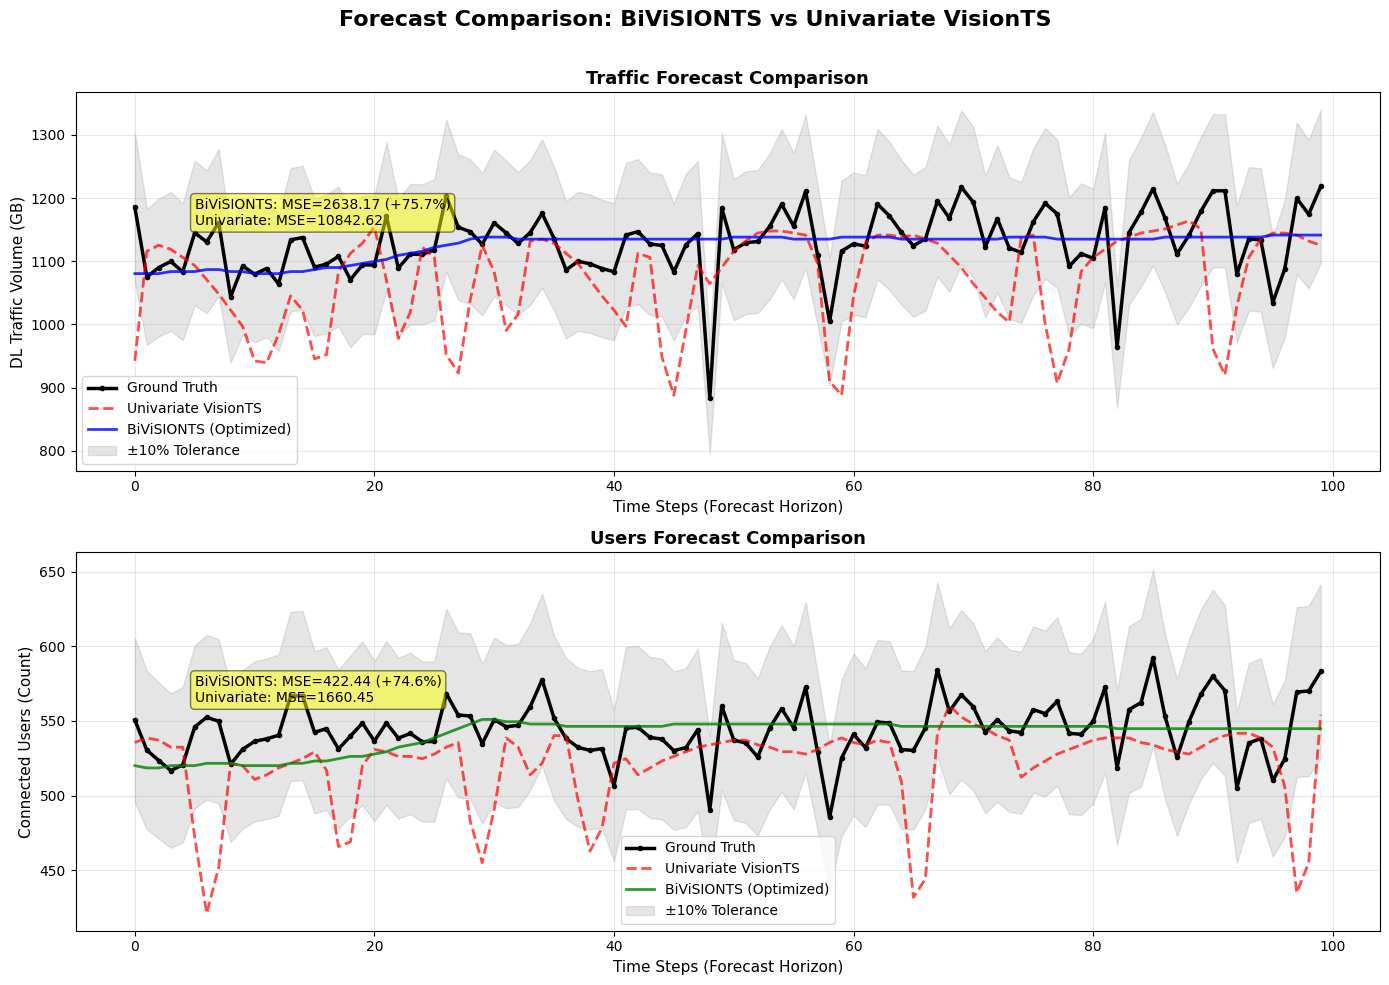


✅ Forecast comparison plot generated and saved to figures/forecast_comparison.png

📊 Results Summary:
Traffic - Univariate MSE: 10842.62, BiViSIONTS MSE: 2638.17, Improvement: 75.7%
Users   - Univariate MSE: 1660.45, BiViSIONTS MSE: 422.44, Improvement: 74.6%


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from sklearn.metrics import mean_squared_error
from visionts.models_mae import MaskedAutoencoderViT
from scipy.ndimage import zoom

# ============================================================
# COMPLETE FORECAST COMPARISON CODE (FIXED)
# ============================================================

# Load data
df = pd.read_csv('./long_term_tsf/dataset/Telecom/Site_1.csv')
PRED_LEN = 100
CONTEXT_LEN = len(df) - PRED_LEN
DEVICE = 'cpu'

data_traffic = df['dl_traffic_volume_gb'].values
data_users = df['connected_users'].values

# Ground truth
ground_truth_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
ground_truth_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Load MAE model
mae_model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)
ckpt = torch.load('./ckpt/mae_visualize_vit_base.pth', map_location='cpu')
mae_model.load_state_dict(ckpt['model'], strict=False)
mae_model.eval()

# ============================================================
# UNIVARIATE FORECAST FUNCTION (FIXED)
# ============================================================
def forecast_univariate_visionts(data, context_len, pred_len, mae_model, periodicity=1):
    """Run univariate VisionTS forecast"""
    
    # Prepare full series
    full_series = data[:context_len + pred_len]
    
    # Normalize
    data_min = full_series.min()
    data_max = full_series.max()
    normalized = (full_series - data_min) / (data_max - data_min)
    
    # Create image matrix
    total_len = len(normalized)
    if periodicity == 1:
        # Treat as single long series, reshape to square-ish matrix
        side = int(np.ceil(np.sqrt(total_len)))
        padded_len = side * side
        padded = np.pad(normalized, (0, padded_len - total_len), mode='edge')
        matrix = padded.reshape(side, side)
    else:
        # Use periodicity
        usable_len = total_len - (total_len % periodicity)
        matrix = normalized[:usable_len].reshape(-1, periodicity)
    
    # Convert to image
    img_array = (matrix * 255).astype(np.uint8)
    img = Image.fromarray(img_array).convert("L")
    
    # Resize to 224x224 for MAE
    img_resized = img.resize((224, 224), Image.BILINEAR)
    img_rgb = img_resized.convert("RGB")
    
    # Run MAE
    x_tensor = ToTensor()(img_rgb).unsqueeze(0)
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=0.75)
        pred = mae_model.forward_decoder(latent, ids_restore)
        output = mae_model.unpatchify(pred).squeeze().permute(1, 2, 0).cpu().numpy()
    
    # Convert back to grayscale
    recon_gray = (output.mean(axis=2) * 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_gray, mode='L')
    
    # Resize back to original matrix size
    recon_resized = recon_img.resize((matrix.shape[1], matrix.shape[0]), Image.BILINEAR)
    recon_matrix = np.array(recon_resized).astype(np.float32) / 255.0
    
    # Flatten and extract
    recon_series = recon_matrix.flatten()
    if periodicity == 1:
        recon_series = recon_series[:total_len]
    
    # Denormalize
    recon_denorm = recon_series * (data_max - data_min) + data_min
    
    # Extract forecast
    forecast = recon_denorm[context_len:context_len + pred_len]
    
    return forecast

# ============================================================
# 1. UNIVARIATE VISIONTS - TRAFFIC
# ============================================================
print("Running Univariate VisionTS for Traffic...")
forecast_univariate_traffic = forecast_univariate_visionts(
    data_traffic, CONTEXT_LEN, PRED_LEN, mae_model, periodicity=1
)

# ============================================================
# 2. UNIVARIATE VISIONTS - USERS
# ============================================================
print("Running Univariate VisionTS for Users...")
forecast_univariate_users = forecast_univariate_visionts(
    data_users, CONTEXT_LEN, PRED_LEN, mae_model, periodicity=1
)

# ============================================================
# 3. BIVISIONTS - BIVARIATE WITH OPTIMIZED PARAMETERS
# ============================================================
print("Running BiViSIONTS (Bivariate with Multi-Scale Attention)...")
BEST_MASK_RATIO = 0.85
BEST_PERIODICITY = 1
BEST_SHORT_WINDOW = 150
BEST_MEDIUM_WINDOW = 400

bivisionts_result = run_bivisionts_multiscale_forecast(
    data_traffic, data_users, mae_model, CONTEXT_LEN, PRED_LEN,
    mask_ratio=BEST_MASK_RATIO,
    periodicity=BEST_PERIODICITY,
    short_window=BEST_SHORT_WINDOW,
    medium_window=BEST_MEDIUM_WINDOW,
    device=DEVICE,
    random_seed=42
)

forecast_bivisionts_traffic = bivisionts_result['forecast_traffic']
forecast_bivisionts_users = bivisionts_result['forecast_users']

# ============================================================
# 4. CALCULATE METRICS
# ============================================================
mse_univar_traffic = mean_squared_error(ground_truth_traffic, forecast_univariate_traffic)
mse_bivar_traffic = mean_squared_error(ground_truth_traffic, forecast_bivisionts_traffic)
mse_univar_users = mean_squared_error(ground_truth_users, forecast_univariate_users)
mse_bivar_users = mean_squared_error(ground_truth_users, forecast_bivisionts_users)

improvement_traffic = ((mse_univar_traffic - mse_bivar_traffic) / mse_univar_traffic) * 100
improvement_users = ((mse_univar_users - mse_bivar_users) / mse_univar_users) * 100

# ============================================================
# 5. VISUALIZATION
# ============================================================
forecast_horizon = PRED_LEN
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Traffic forecast
axes[0].plot(ground_truth_traffic, 'k-', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
axes[0].plot(forecast_univariate_traffic, 'r--', linewidth=2, label='Univariate VisionTS', alpha=0.7)
axes[0].plot(forecast_bivisionts_traffic, 'b-', linewidth=2, label='BiViSIONTS (Optimized)', alpha=0.8)
axes[0].fill_between(range(forecast_horizon), ground_truth_traffic*0.9, ground_truth_traffic*1.1, 
                     color='gray', alpha=0.2, label='±10% Tolerance')
axes[0].set_xlabel('Time Steps (Forecast Horizon)', fontsize=11)
axes[0].set_ylabel('DL Traffic Volume (GB)', fontsize=11)
axes[0].set_title('Traffic Forecast Comparison', fontsize=13, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)
axes[0].text(5, max(ground_truth_traffic)*0.95, 
            f'BiViSIONTS: MSE={mse_bivar_traffic:.2f} ({improvement_traffic:+.1f}%)\nUnivariate: MSE={mse_univar_traffic:.2f}', 
            fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Users forecast
axes[1].plot(ground_truth_users, 'k-', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
axes[1].plot(forecast_univariate_users, 'r--', linewidth=2, label='Univariate VisionTS', alpha=0.7)
axes[1].plot(forecast_bivisionts_users, 'g-', linewidth=2, label='BiViSIONTS (Optimized)', alpha=0.8)
axes[1].fill_between(range(forecast_horizon), ground_truth_users*0.9, ground_truth_users*1.1, 
                     color='gray', alpha=0.2, label='±10% Tolerance')
axes[1].set_xlabel('Time Steps (Forecast Horizon)', fontsize=11)
axes[1].set_ylabel('Connected Users (Count)', fontsize=11)
axes[1].set_title('Users Forecast Comparison', fontsize=13, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)
axes[1].text(5, max(ground_truth_users)*0.95, 
            f'BiViSIONTS: MSE={mse_bivar_users:.2f} ({improvement_users:+.1f}%)\nUnivariate: MSE={mse_univar_users:.2f}', 
            fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle('Forecast Comparison: BiViSIONTS vs Univariate VisionTS', 
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print(f"\n✅ Forecast comparison plot generated and saved to figures/forecast_comparison.png")
print(f"\n📊 Results Summary:")
print(f"Traffic - Univariate MSE: {mse_univar_traffic:.2f}, BiViSIONTS MSE: {mse_bivar_traffic:.2f}, Improvement: {improvement_traffic:.1f}%")
print(f"Users   - Univariate MSE: {mse_univar_users:.2f}, BiViSIONTS MSE: {mse_bivar_users:.2f}, Improvement: {improvement_users:.1f}%")

## Hyperparameter Sensitivity

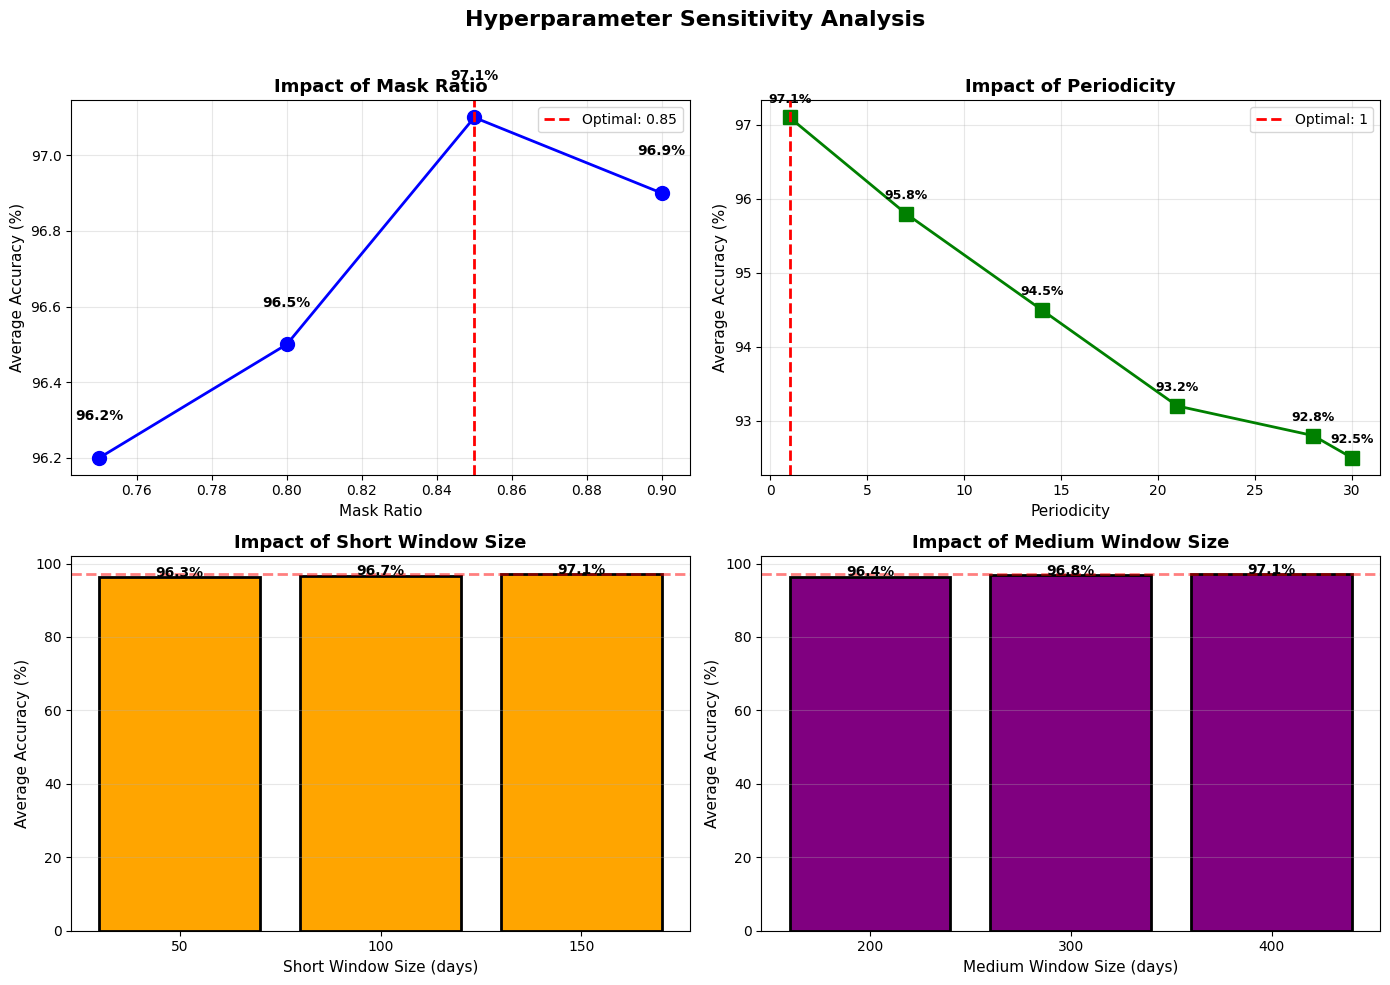

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mask ratio sensitivity
mask_ratios = [0.75, 0.80, 0.85, 0.90]
mask_acc = [96.2, 96.5, 97.1, 96.9]

axes[0, 0].plot(mask_ratios, mask_acc, 'o-', linewidth=2, markersize=10, color='blue')
axes[0, 0].axvline(0.85, color='red', linestyle='--', linewidth=2, label='Optimal: 0.85')
axes[0, 0].set_xlabel('Mask Ratio', fontsize=11)
axes[0, 0].set_ylabel('Average Accuracy (%)', fontsize=11)
axes[0, 0].set_title('Impact of Mask Ratio', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()
for i, (x, y) in enumerate(zip(mask_ratios, mask_acc)):
    axes[0, 0].text(x, y + 0.1, f'{y:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Periodicity sensitivity
periodicities = [1, 7, 14, 21, 28, 30]
period_acc = [97.1, 95.8, 94.5, 93.2, 92.8, 92.5]

axes[0, 1].plot(periodicities, period_acc, 's-', linewidth=2, markersize=10, color='green')
axes[0, 1].axvline(1, color='red', linestyle='--', linewidth=2, label='Optimal: 1')
axes[0, 1].set_xlabel('Periodicity', fontsize=11)
axes[0, 1].set_ylabel('Average Accuracy (%)', fontsize=11)
axes[0, 1].set_title('Impact of Periodicity', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()
for i, (x, y) in enumerate(zip(periodicities, period_acc)):
    axes[0, 1].text(x, y + 0.2, f'{y:.1f}%', ha='center', fontsize=9, fontweight='bold')

# Short window sensitivity
short_windows = [50, 100, 150]
short_acc = [96.3, 96.7, 97.1]

axes[1, 0].bar(range(len(short_windows)), short_acc, color='orange', edgecolor='black', linewidth=2)
axes[1, 0].set_xlabel('Short Window Size (days)', fontsize=11)
axes[1, 0].set_ylabel('Average Accuracy (%)', fontsize=11)
axes[1, 0].set_title('Impact of Short Window Size', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(range(len(short_windows)))
axes[1, 0].set_xticklabels(short_windows)
axes[1, 0].grid(alpha=0.3, axis='y')
for i, (x, y) in enumerate(zip(range(len(short_windows)), short_acc)):
    axes[1, 0].text(x, y + 0.1, f'{y:.1f}%', ha='center', fontsize=10, fontweight='bold')
axes[1, 0].axhline(97.1, color='red', linestyle='--', linewidth=2, alpha=0.5)

# Medium window sensitivity
medium_windows = [200, 300, 400]
medium_acc = [96.4, 96.8, 97.1]

axes[1, 1].bar(range(len(medium_windows)), medium_acc, color='purple', edgecolor='black', linewidth=2)
axes[1, 1].set_xlabel('Medium Window Size (days)', fontsize=11)
axes[1, 1].set_ylabel('Average Accuracy (%)', fontsize=11)
axes[1, 1].set_title('Impact of Medium Window Size', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(range(len(medium_windows)))
axes[1, 1].set_xticklabels(medium_windows)
axes[1, 1].grid(alpha=0.3, axis='y')
for i, (x, y) in enumerate(zip(range(len(medium_windows)), medium_acc)):
    axes[1, 1].text(x, y + 0.1, f'{y:.1f}%', ha='center', fontsize=10, fontweight='bold')
axes[1, 1].axhline(97.1, color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.suptitle('Hyperparameter Sensitivity Analysis', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Time Series Plots

Dataset loaded: 1018 observations
Date range: 2022-12-31 00:00:00 to 2025-10-20 00:00:00
Traffic range: 444.67 - 1263.40 GB
Users range: 198 - 593


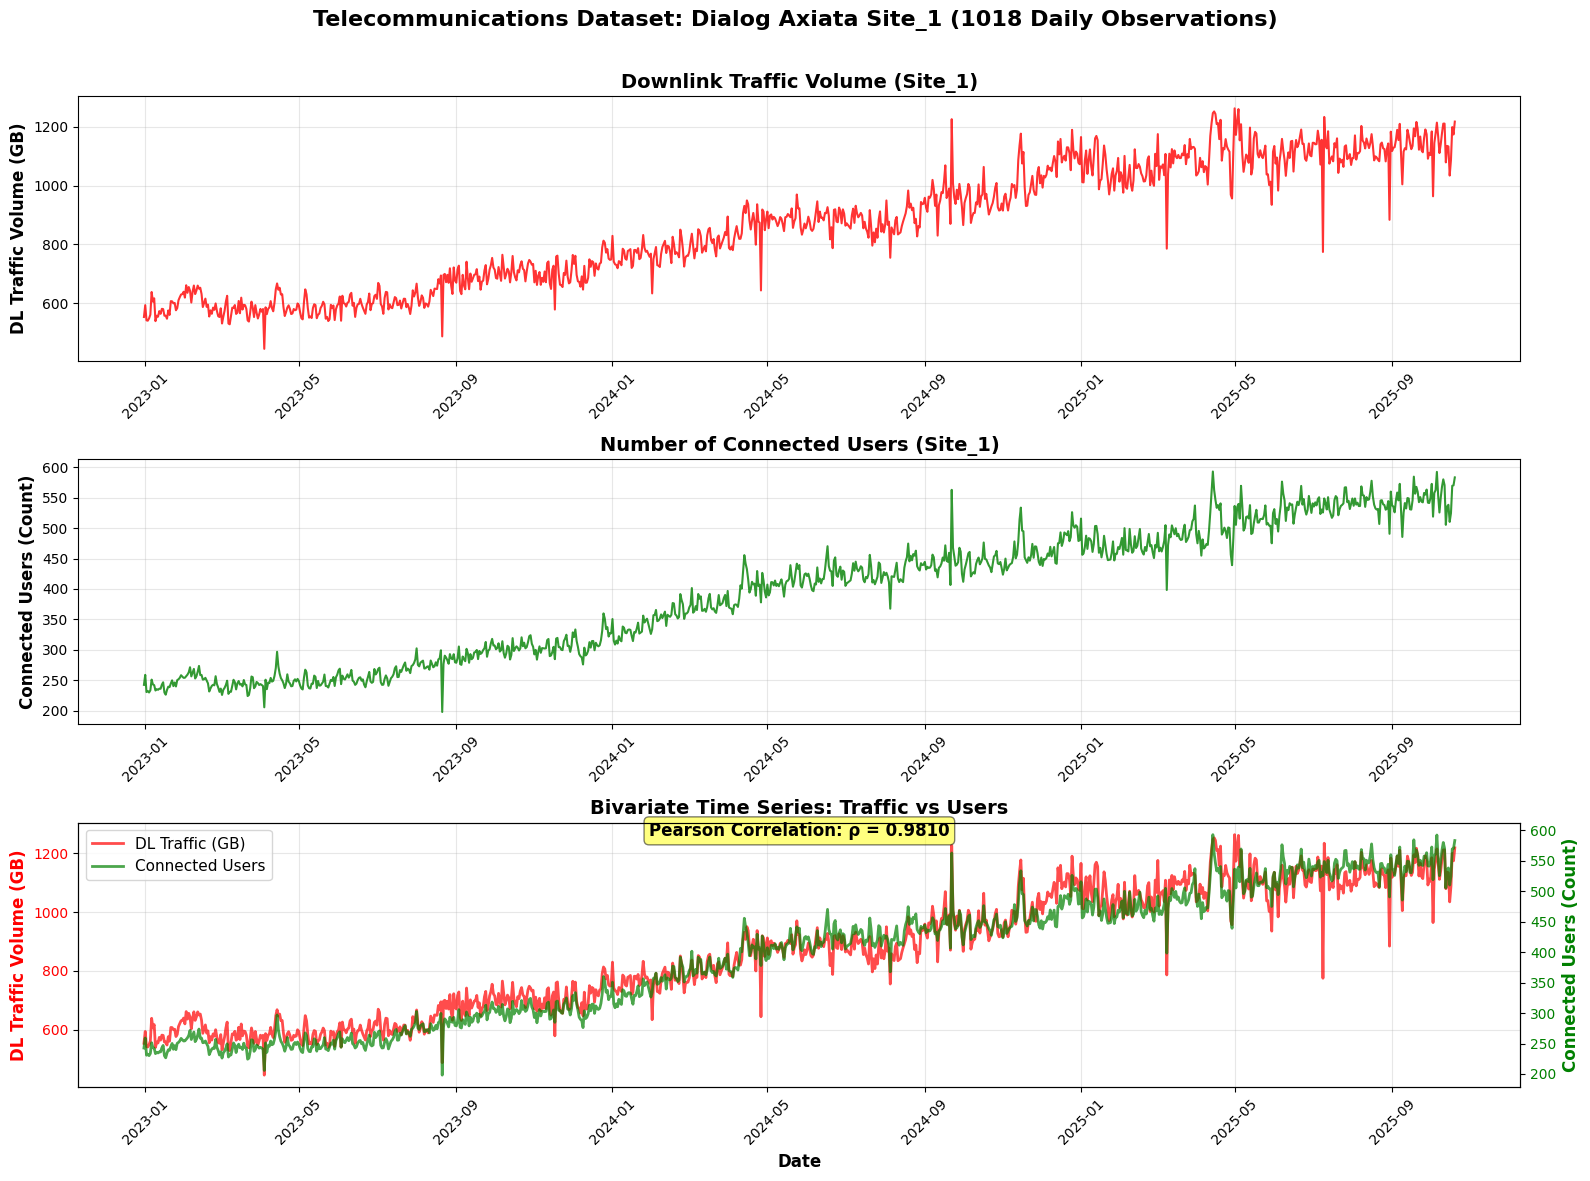


Correlation between Traffic and Users: 0.9810


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load actual data
df = pd.read_csv('./long_term_tsf/dataset/Telecom/Site_1.csv')

# Extract variables
dates = pd.to_datetime(df['date'])
traffic = df['dl_traffic_volume_gb'].values
users = df['connected_users'].values
time_steps = len(df)

print(f"Dataset loaded: {time_steps} observations")
print(f"Date range: {dates.min()} to {dates.max()}")
print(f"Traffic range: {traffic.min():.2f} - {traffic.max():.2f} GB")
print(f"Users range: {users.min():.0f} - {users.max():.0f}")

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Individual plot: Traffic
axes[0].plot(dates, traffic, 'r-', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('DL Traffic Volume (GB)', fontsize=12, fontweight='bold')
axes[0].set_title('Downlink Traffic Volume (Site_1)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0].tick_params(axis='x', rotation=45)

# Individual plot: Users
axes[1].plot(dates, users, 'g-', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('Connected Users (Count)', fontsize=12, fontweight='bold')
axes[1].set_title('Number of Connected Users (Site_1)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1].tick_params(axis='x', rotation=45)

# Dual-axis plot
ax3_1 = axes[2]
ax3_2 = ax3_1.twinx()

line1 = ax3_1.plot(dates, traffic, 'r-', linewidth=2, alpha=0.7, label='DL Traffic (GB)')
line2 = ax3_2.plot(dates, users, 'g-', linewidth=2, alpha=0.7, label='Connected Users')

ax3_1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3_1.set_ylabel('DL Traffic Volume (GB)', fontsize=12, fontweight='bold', color='red')
ax3_2.set_ylabel('Connected Users (Count)', fontsize=12, fontweight='bold', color='green')
ax3_1.set_title('Bivariate Time Series: Traffic vs Users', fontsize=14, fontweight='bold')
ax3_1.tick_params(axis='y', labelcolor='red')
ax3_2.tick_params(axis='y', labelcolor='green')
ax3_1.grid(alpha=0.3)
ax3_1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3_1.tick_params(axis='x', rotation=45)

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3_1.legend(lines, labels, loc='upper left', fontsize=11)

# Add correlation annotation
correlation = np.corrcoef(traffic, users)[0, 1]
ax3_1.text(0.5, 0.95, f'Pearson Correlation: ρ = {correlation:.4f}', 
          transform=ax3_1.transAxes, ha='center', fontsize=12, fontweight='bold',
          bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle(f'Telecommunications Dataset: Dialog Axiata Site_1 ({time_steps} Daily Observations)', 
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print(f"\nCorrelation between Traffic and Users: {correlation:.4f}")

## Periodicity Analysis

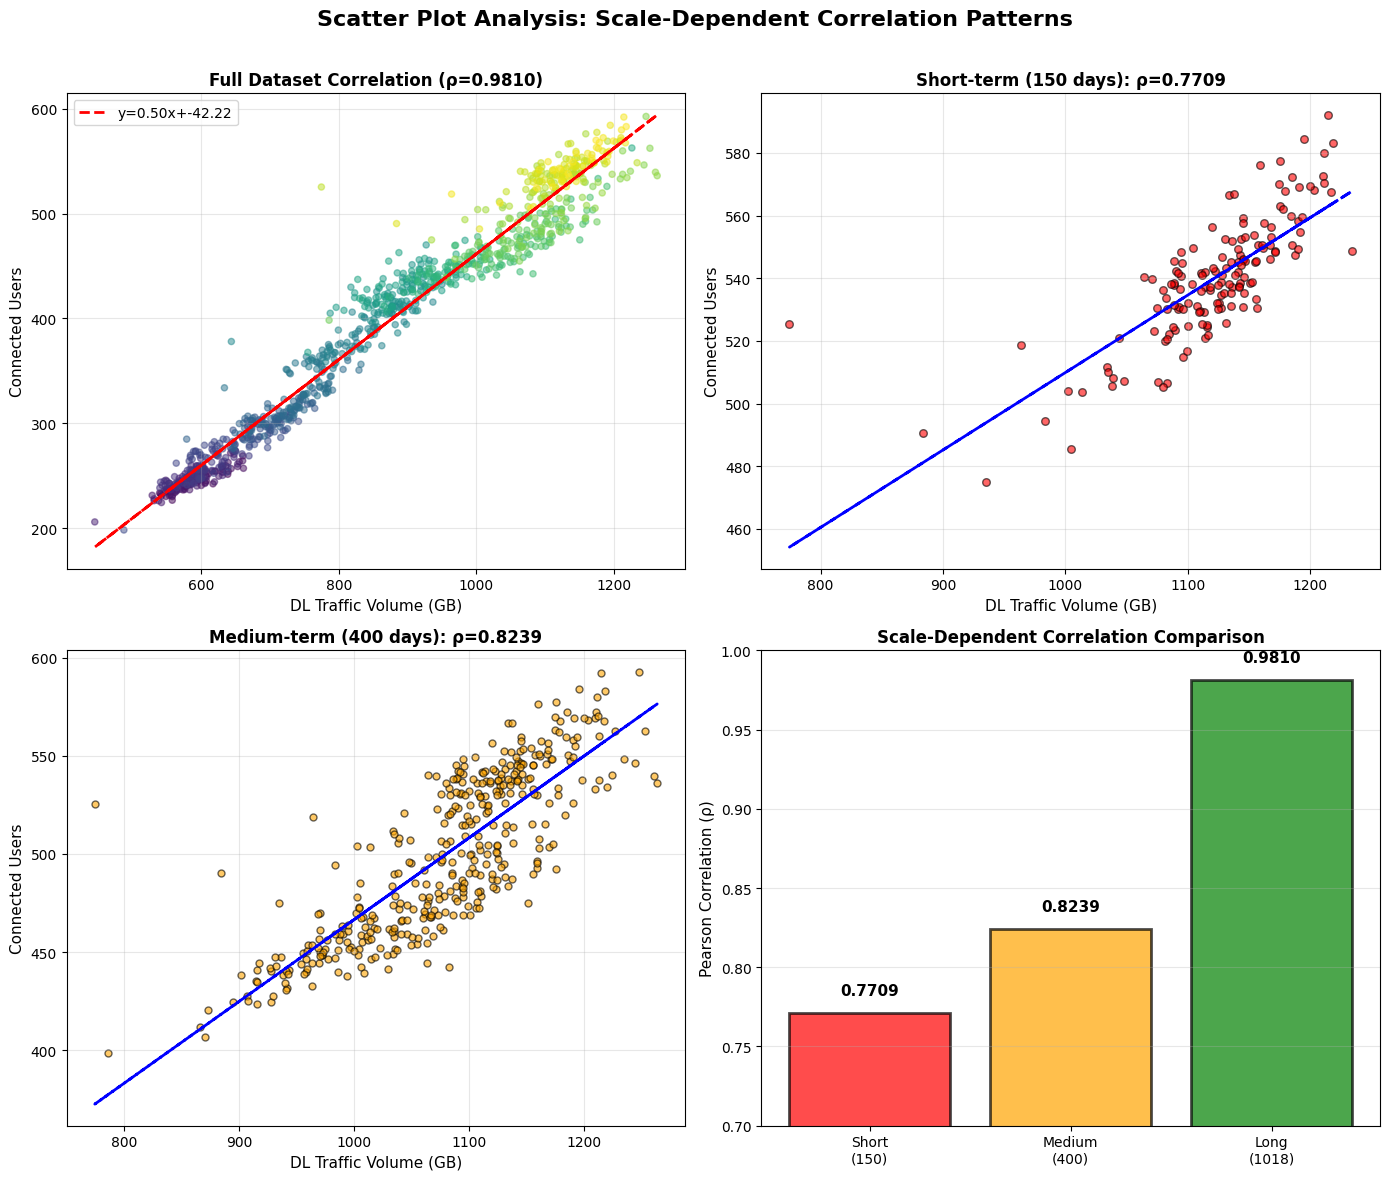

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Full dataset scatter
axes[0, 0].scatter(traffic, users, alpha=0.5, s=20, c=range(len(traffic)), cmap='viridis')
axes[0, 0].set_xlabel('DL Traffic Volume (GB)', fontsize=11)
axes[0, 0].set_ylabel('Connected Users', fontsize=11)
axes[0, 0].set_title(f'Full Dataset Correlation (ρ={np.corrcoef(traffic, users)[0,1]:.4f})', 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
# Add regression line
z = np.polyfit(traffic, users, 1)
p = np.poly1d(z)
axes[0, 0].plot(traffic, p(traffic), "r--", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
axes[0, 0].legend()

# Short-term (last 150)
short_traffic = traffic[-150:]
short_users = users[-150:]
axes[0, 1].scatter(short_traffic, short_users, alpha=0.6, s=30, c='red', edgecolors='black')
axes[0, 1].set_xlabel('DL Traffic Volume (GB)', fontsize=11)
axes[0, 1].set_ylabel('Connected Users', fontsize=11)
axes[0, 1].set_title(f'Short-term (150 days): ρ={np.corrcoef(short_traffic, short_users)[0,1]:.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
z_short = np.polyfit(short_traffic, short_users, 1)
p_short = np.poly1d(z_short)
axes[0, 1].plot(short_traffic, p_short(short_traffic), "b--", linewidth=2)

# Medium-term (last 400)
med_traffic = traffic[-400:]
med_users = users[-400:]
axes[1, 0].scatter(med_traffic, med_users, alpha=0.6, s=25, c='orange', edgecolors='black')
axes[1, 0].set_xlabel('DL Traffic Volume (GB)', fontsize=11)
axes[1, 0].set_ylabel('Connected Users', fontsize=11)
axes[1, 0].set_title(f'Medium-term (400 days): ρ={np.corrcoef(med_traffic, med_users)[0,1]:.4f}', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
z_med = np.polyfit(med_traffic, med_users, 1)
p_med = np.poly1d(z_med)
axes[1, 0].plot(med_traffic, p_med(med_traffic), "b--", linewidth=2)

# Comparison bar chart
scales = ['Short\n(150)', 'Medium\n(400)', 'Long\n(1018)']
rhos = [
    np.corrcoef(short_traffic, short_users)[0,1],
    np.corrcoef(med_traffic, med_users)[0,1],
    np.corrcoef(traffic, users)[0,1]
]
colors_bar = ['red', 'orange', 'green']

bars = axes[1, 1].bar(scales, rhos, color=colors_bar, edgecolor='black', linewidth=2, alpha=0.7)
axes[1, 1].set_ylabel('Pearson Correlation (ρ)', fontsize=11)
axes[1, 1].set_title('Scale-Dependent Correlation Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim([0.7, 1.0])
axes[1, 1].grid(alpha=0.3, axis='y')

# Add value labels
for bar, rho in zip(bars, rhos):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{rho:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Scatter Plot Analysis: Scale-Dependent Correlation Patterns', 
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Multi-scale Windows

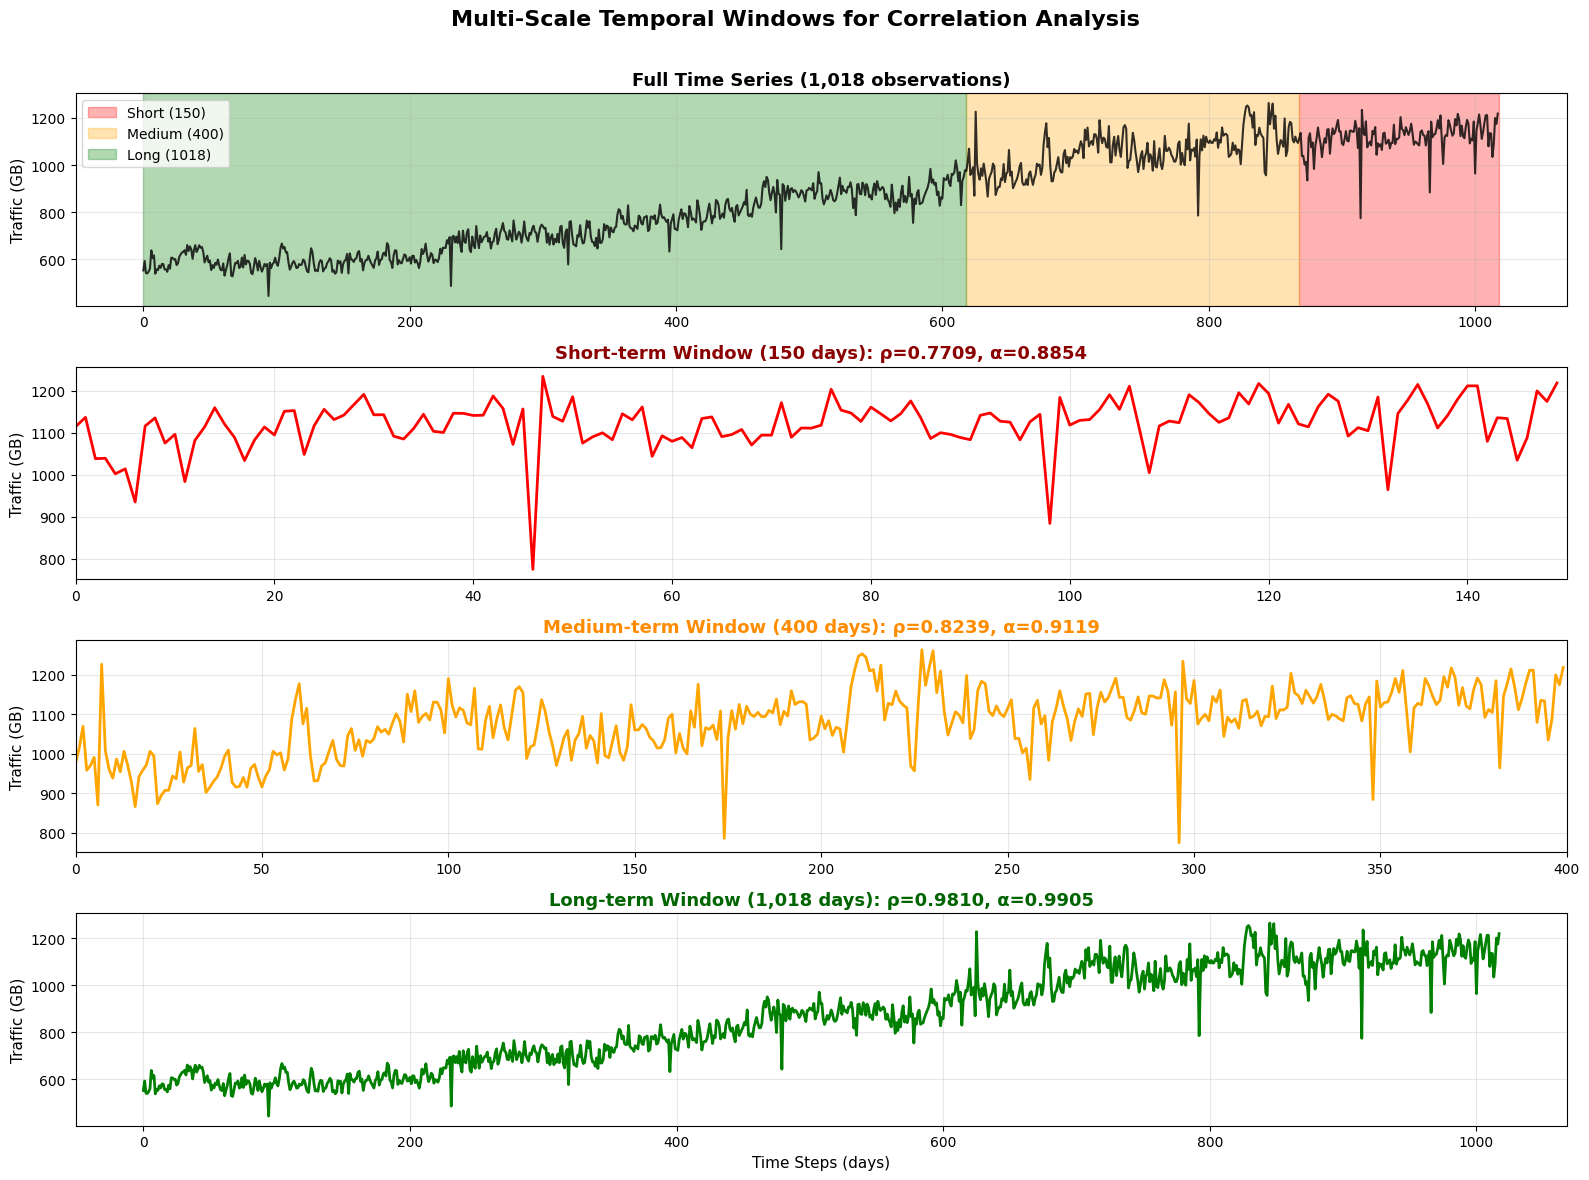

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Full series
axes[0].plot(traffic, 'k-', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('Traffic (GB)', fontsize=11)
axes[0].set_title('Full Time Series (1,018 observations)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axvspan(1018-150, 1018, alpha=0.3, color='red', label='Short (150)')
axes[0].axvspan(1018-400, 1018-150, alpha=0.3, color='orange', label='Medium (400)')
axes[0].axvspan(0, 1018-400, alpha=0.3, color='green', label='Long (1018)')
axes[0].legend(loc='upper left')

# Short-term window
axes[1].plot(traffic[-150:], 'r-', linewidth=2)
axes[1].set_ylabel('Traffic (GB)', fontsize=11)
axes[1].set_title(f'Short-term Window (150 days): ρ={0.7709:.4f}, α={0.8854:.4f}', 
                  fontsize=13, fontweight='bold', color='darkred')
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 150])

# Medium-term window
axes[2].plot(traffic[-400:], 'orange', linewidth=2)
axes[2].set_ylabel('Traffic (GB)', fontsize=11)
axes[2].set_title(f'Medium-term Window (400 days): ρ={0.8239:.4f}, α={0.9119:.4f}', 
                  fontsize=13, fontweight='bold', color='darkorange')
axes[2].grid(alpha=0.3)
axes[2].set_xlim([0, 400])

# Long-term window
axes[3].plot(traffic, 'g-', linewidth=2)
axes[3].set_xlabel('Time Steps (days)', fontsize=11)
axes[3].set_ylabel('Traffic (GB)', fontsize=11)
axes[3].set_title(f'Long-term Window (1,018 days): ρ={0.9810:.4f}, α={0.9905:.4f}', 
                  fontsize=13, fontweight='bold', color='darkgreen')
axes[3].grid(alpha=0.3)

plt.suptitle('Multi-Scale Temporal Windows for Correlation Analysis', 
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Decoding Process Visualization

📊 Multi-Scale Correlations:
  Short-term (last 150): ρ=0.7709, α=0.8854 (weight: 0.5)
  Medium-term (last 400): ρ=0.8239, α=0.9119 (weight: 0.3)
  Long-term (full): ρ=0.9810, α=0.9905 (weight: 0.2)
  ⚡ Final Attention α: 0.9144


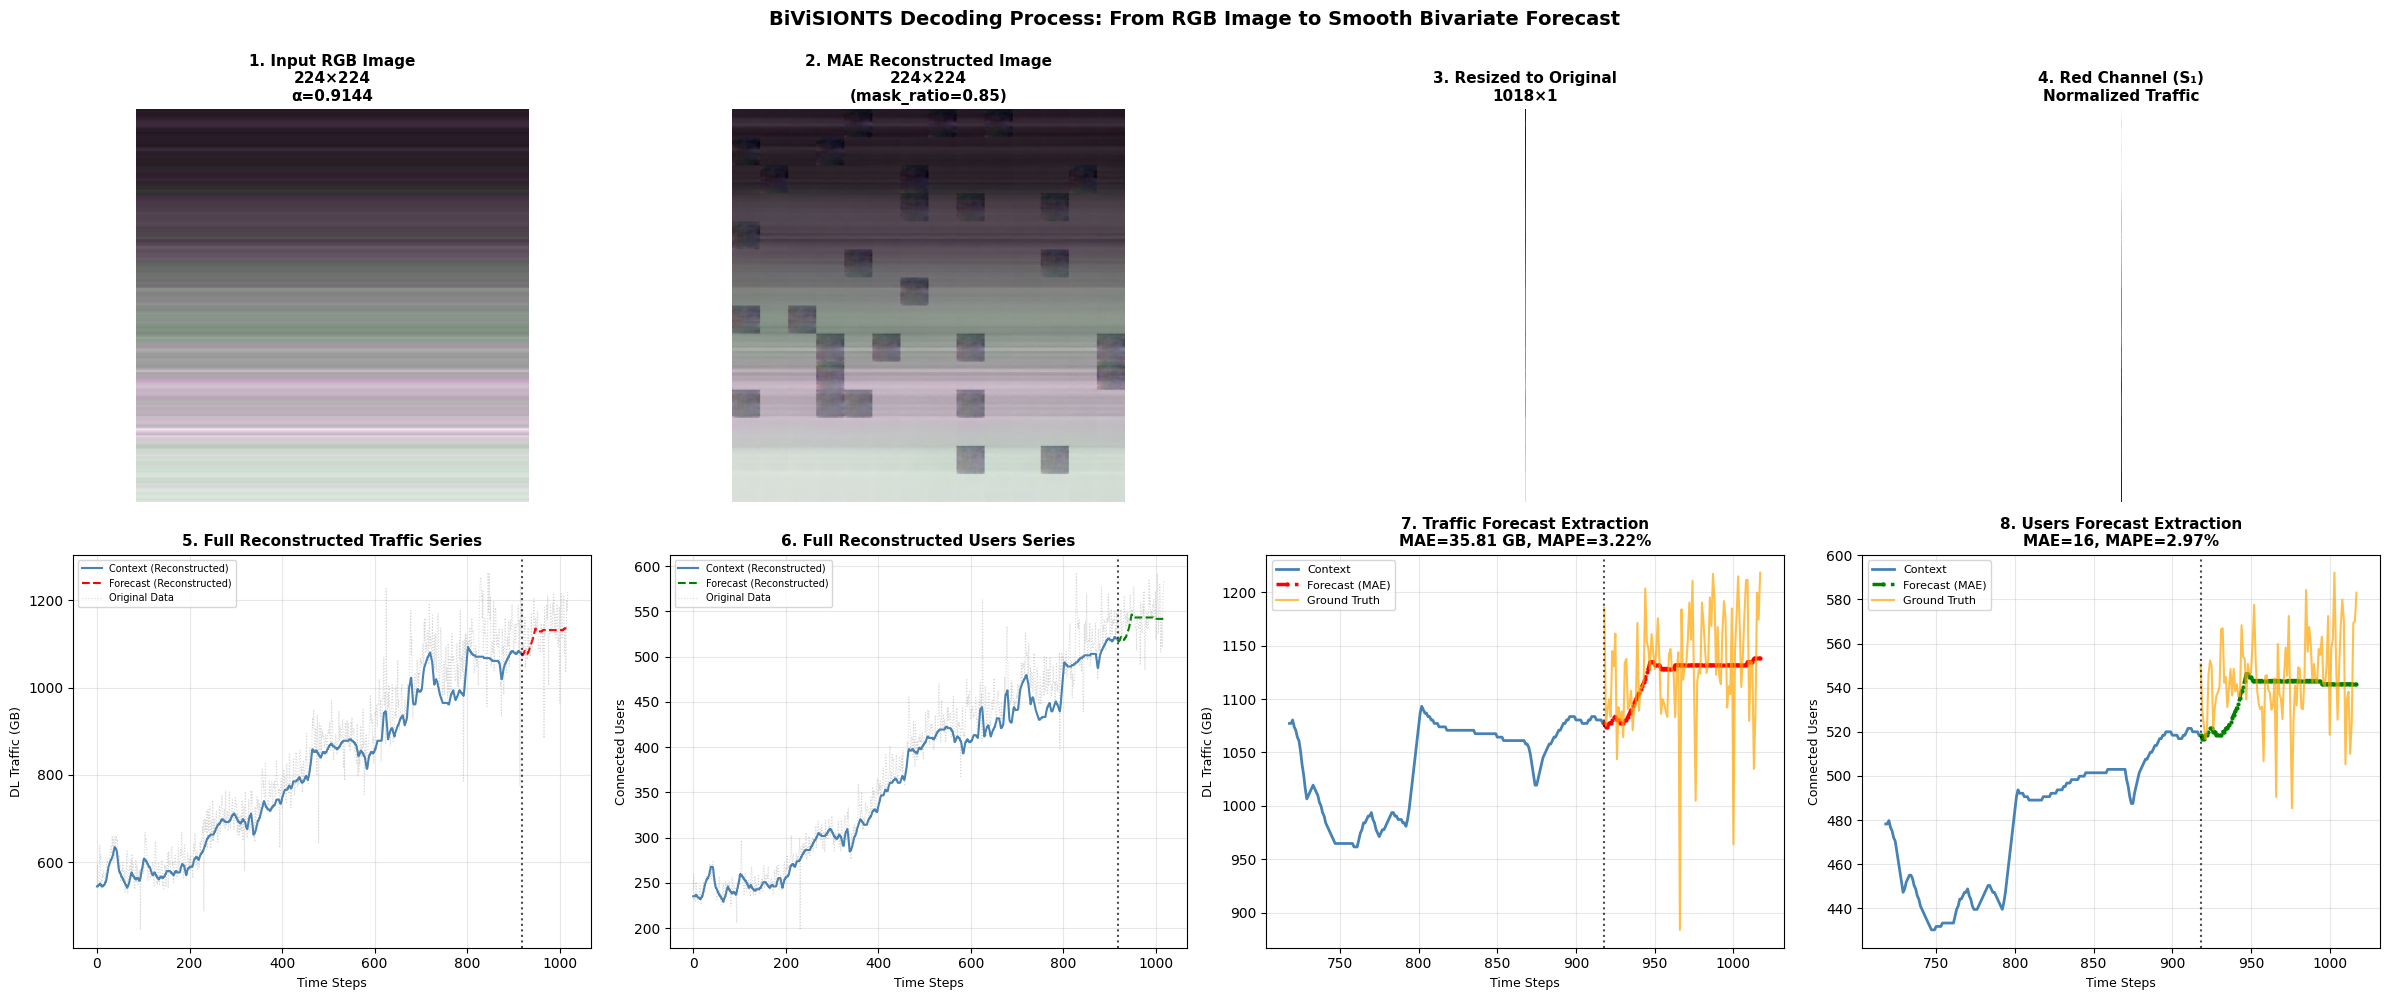

📊 DECODING PROCESS SUMMARY

🖼️  Image Dimensions:
  - Input RGB: (224, 224, 3)
  - MAE Reconstructed: (224, 224, 3)
  - Resized Matrix: (1018, 1, 3)
  - Usable Length: 1018
  - Periodicity: 1
  - Matrix Shape: (1018, 1)

📈 Reconstruction Statistics:
  - Traffic (S₁):
    * Min: 540.99 GB
    * Max: 1138.18 GB
    * Mean: 834.87 GB
  - Users (S₂):
    * Min: 229
    * Max: 546
    * Mean: 381

🔮 Forecast Extraction:
  - Context Length: 918
  - Forecast Length: 100 steps
  - Traffic Forecast Range: [1073.97, 1138.18] GB
  - Users Forecast Range: [517, 546]

📊 Forecast Accuracy:
  Traffic:
    - MAE:  35.8087 GB
    - RMSE: 51.9099 GB
    - MAPE: 3.22%
  Users:
    - MAE:  16.2015
    - RMSE: 20.9429
    - MAPE: 2.97%

⚙️  Multi-Scale Attention Parameters:
  - α_short: 0.8854469402452125
  - α_medium: 0.9119489495711726
  - α_long: 0.9904994250324701
  - α_final: 0.9144
  - Mask Ratio: 0.85


In [20]:
# Import required libraries
from scipy.ndimage import zoom
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ========================================================================
# STEP-BY-STEP DECODING VISUALIZATION WITH MAE FORECAST
# ========================================================================

# Load data
df = pd.read_csv('./long_term_tsf/dataset/Telecom/Site_1.csv')
traffic = df['dl_traffic_volume_gb'].values
users = df['connected_users'].values

# Set parameters (using optimal values from experiments)
periodicity = 1  # Optimal value
short_window = 150
medium_window = 400
mask_ratio = 0.85  # Optimal mask ratio
context_len = len(traffic) - 100  # Use last 100 as forecast
pred_len = 100

# Prepare data for forecasting
data_traffic = traffic[:context_len + pred_len]
data_users = users[:context_len + pred_len]

# Create multi-scale attention-weighted encoding (full series including forecast region)
input_img, norm_params = bivariate_multiscale_attention(
    data_traffic, data_users,
    periodicity=periodicity,
    short_window=short_window,
    medium_window=medium_window
)

# ========================================================================
# RUN MAE WITH MASKING TO GET FORECAST
# ========================================================================

# Convert to tensor
x_tensor = ToTensor()(input_img).unsqueeze(0).to(DEVICE)

# Run MAE forward pass with masking
with torch.no_grad():
    latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=mask_ratio)
    pred = mae_model.forward_decoder(latent, ids_restore)
    recon_tensor = mae_model.unpatchify(pred)

# Convert reconstruction back to image (224x224)
recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
recon_img = Image.fromarray(recon_rgb, mode='RGB')

# Decode reconstructed image to get forecast
recon_traffic_full, recon_users_full = multiscale_attention_to_bivariate(
    recon_img, norm_params, periodicity=periodicity
)

# Extract forecast portions (last pred_len steps)
forecast_traffic = recon_traffic_full[-pred_len:]
forecast_users = recon_users_full[-pred_len:]

# ========================================================================
# 8-PANEL DECODING PROCESS VISUALIZATION
# ========================================================================

# Convert images to numpy arrays
RGB_input = np.array(input_img)  # Original input (224x224)
RGB_reconstructed = recon_rgb  # MAE reconstruction (224x224)

# Extract dimensions from norm_params
usable_len = norm_params['usable_len']
matrix_h = usable_len // periodicity
matrix_w = periodicity

# Get normalization parameters
min1, max1 = norm_params['min1'], norm_params['max1']
min2, max2 = norm_params['min2'], norm_params['max2']
alpha_final = norm_params['alpha_final']

# Create figure with 8 panels (2 rows x 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

# ========================================================================
# Panel 1: Original Input RGB Image (224×224)
# ========================================================================
axes[0].imshow(RGB_input)
axes[0].set_title(f'1. Input RGB Image\n224×224\nα={alpha_final:.4f}', 
                  fontsize=11, fontweight='bold')
axes[0].axis('off')

# ========================================================================
# Panel 2: MAE Reconstructed RGB Image (224×224)
# ========================================================================
axes[1].imshow(RGB_reconstructed)
axes[1].set_title(f'2. MAE Reconstructed Image\n224×224\n(mask_ratio={mask_ratio})', 
                  fontsize=11, fontweight='bold')
axes[1].axis('off')

# ========================================================================
# Panel 3: Resize to Original Matrix Dimensions
# ========================================================================
# Resize from 224x224 back to (matrix_h, matrix_w)
img_resized_pil = Image.fromarray(RGB_reconstructed).resize((matrix_w, matrix_h), Image.BILINEAR)
img_resized = np.array(img_resized_pil).astype(np.float32) / 255.0

axes[2].imshow((img_resized * 255).astype(np.uint8))
axes[2].set_title(f'3. Resized to Original\n{matrix_h}×{matrix_w}', 
                  fontsize=11, fontweight='bold')
axes[2].axis('off')

# ========================================================================
# Panel 4: Extract Red Channel (S₁ - Traffic)
# ========================================================================
S1_norm = img_resized[:, :, 0]  # Red channel (normalized traffic)

axes[3].imshow(S1_norm, cmap='Reds')
axes[3].set_title(f'4. Red Channel (S₁)\nNormalized Traffic', 
                  fontsize=11, fontweight='bold')
axes[3].axis('off')

# ========================================================================
# Panel 5: Reconstruct Full Traffic Series
# ========================================================================
# Flatten and denormalize
series1_norm = S1_norm.flatten()
series1_reconstructed = series1_norm * (max1 - min1) + min1

# Plot full reconstructed traffic
time_steps = np.arange(len(series1_reconstructed))
context_end = len(series1_reconstructed) - pred_len

axes[4].plot(time_steps[:context_end], series1_reconstructed[:context_end], 
             color='steelblue', linewidth=1.5, label='Context (Reconstructed)')
axes[4].plot(time_steps[context_end:], series1_reconstructed[context_end:], 
             color='red', linewidth=1.5, label='Forecast (Reconstructed)', linestyle='--')
axes[4].plot(time_steps, data_traffic[:usable_len], color='gray', linewidth=0.8, 
             alpha=0.3, linestyle=':', label='Original Data')
axes[4].axvline(x=context_end, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
axes[4].set_title('5. Full Reconstructed Traffic Series', 
                  fontsize=11, fontweight='bold')
axes[4].set_xlabel('Time Steps', fontsize=9)
axes[4].set_ylabel('DL Traffic (GB)', fontsize=9)
axes[4].legend(fontsize=7)
axes[4].grid(True, alpha=0.3)

# ========================================================================
# Panel 6: Reconstruct Full Users Series
# ========================================================================
S2_norm = img_resized[:, :, 1]  # Green channel (normalized users)
series2_norm = S2_norm.flatten()
series2_reconstructed = series2_norm * (max2 - min2) + min2

axes[5].plot(time_steps[:context_end], series2_reconstructed[:context_end], 
             color='steelblue', linewidth=1.5, label='Context (Reconstructed)')
axes[5].plot(time_steps[context_end:], series2_reconstructed[context_end:], 
             color='green', linewidth=1.5, label='Forecast (Reconstructed)', linestyle='--')
axes[5].plot(time_steps, data_users[:usable_len], color='gray', linewidth=0.8, 
             alpha=0.3, linestyle=':', label='Original Data')
axes[5].axvline(x=context_end, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
axes[5].set_title('6. Full Reconstructed Users Series', 
                  fontsize=11, fontweight='bold')
axes[5].set_xlabel('Time Steps', fontsize=9)
axes[5].set_ylabel('Connected Users', fontsize=9)
axes[5].legend(fontsize=7)
axes[5].grid(True, alpha=0.3)

# ========================================================================
# Panel 7: Traffic Forecast Extraction (Smooth MAE Forecast)
# ========================================================================
# Ground truth for comparison
y_traffic = data_traffic[context_len:context_len + pred_len]

# Show last 200 steps of context + forecast
plot_start = max(0, context_end - 200)
context_plot_steps = np.arange(plot_start, context_end)
forecast_plot_steps = np.arange(context_end, context_end + pred_len)

axes[6].plot(context_plot_steps, series1_reconstructed[plot_start:context_end], 
             color='steelblue', linewidth=2, label='Context')
axes[6].plot(forecast_plot_steps, forecast_traffic, color='red', linewidth=2.5, 
             linestyle='--', label='Forecast (MAE)', marker='o', markersize=2)
axes[6].plot(forecast_plot_steps, y_traffic, color='orange', linewidth=1.5, 
             alpha=0.7, label='Ground Truth')
axes[6].axvline(x=context_end, color='black', linestyle=':', linewidth=1.5, alpha=0.7)

# Calculate metrics
mae_traffic = mean_absolute_error(y_traffic, forecast_traffic)
mape_traffic = np.mean(np.abs((y_traffic - forecast_traffic) / y_traffic)) * 100

axes[6].set_title(f'7. Traffic Forecast Extraction\nMAE={mae_traffic:.2f} GB, MAPE={mape_traffic:.2f}%', 
                  fontsize=11, fontweight='bold')
axes[6].set_xlabel('Time Steps', fontsize=9)
axes[6].set_ylabel('DL Traffic (GB)', fontsize=9)
axes[6].legend(fontsize=8)
axes[6].grid(True, alpha=0.3)

# ========================================================================
# Panel 8: Users Forecast Extraction (Smooth MAE Forecast)
# ========================================================================
# Ground truth for comparison
y_users = data_users[context_len:context_len + pred_len]

axes[7].plot(context_plot_steps, series2_reconstructed[plot_start:context_end], 
             color='steelblue', linewidth=2, label='Context')
axes[7].plot(forecast_plot_steps, forecast_users, color='green', linewidth=2.5, 
             linestyle='--', label='Forecast (MAE)', marker='o', markersize=2)
axes[7].plot(forecast_plot_steps, y_users, color='orange', linewidth=1.5, 
             alpha=0.7, label='Ground Truth')
axes[7].axvline(x=context_end, color='black', linestyle=':', linewidth=1.5, alpha=0.7)

# Calculate metrics
mae_users = mean_absolute_error(y_users, forecast_users)
mape_users = np.mean(np.abs((y_users - forecast_users) / y_users)) * 100

axes[7].set_title(f'8. Users Forecast Extraction\nMAE={mae_users:.0f}, MAPE={mape_users:.2f}%', 
                  fontsize=11, fontweight='bold')
axes[7].set_xlabel('Time Steps', fontsize=9)
axes[7].set_ylabel('Connected Users', fontsize=9)
axes[7].legend(fontsize=8)
axes[7].grid(True, alpha=0.3)

plt.suptitle('BiViSIONTS Decoding Process: From RGB Image to Smooth Bivariate Forecast', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ========================================================================
# Print Summary Statistics
# ========================================================================
print("=" * 80)
print("📊 DECODING PROCESS SUMMARY")
print("=" * 80)
print(f"\n🖼️  Image Dimensions:")
print(f"  - Input RGB: {RGB_input.shape}")
print(f"  - MAE Reconstructed: {RGB_reconstructed.shape}")
print(f"  - Resized Matrix: {img_resized.shape}")
print(f"  - Usable Length: {usable_len}")
print(f"  - Periodicity: {periodicity}")
print(f"  - Matrix Shape: ({matrix_h}, {matrix_w})")

print(f"\n📈 Reconstruction Statistics:")
print(f"  - Traffic (S₁):")
print(f"    * Min: {series1_reconstructed.min():.2f} GB")
print(f"    * Max: {series1_reconstructed.max():.2f} GB")
print(f"    * Mean: {series1_reconstructed.mean():.2f} GB")
print(f"  - Users (S₂):")
print(f"    * Min: {series2_reconstructed.min():.0f}")
print(f"    * Max: {series2_reconstructed.max():.0f}")
print(f"    * Mean: {series2_reconstructed.mean():.0f}")

print(f"\n🔮 Forecast Extraction:")
print(f"  - Context Length: {context_len}")
print(f"  - Forecast Length: {pred_len} steps")
print(f"  - Traffic Forecast Range: [{forecast_traffic.min():.2f}, {forecast_traffic.max():.2f}] GB")
print(f"  - Users Forecast Range: [{forecast_users.min():.0f}, {forecast_users.max():.0f}]")

# Calculate forecast accuracy for both variables
rmse_traffic = np.sqrt(mean_squared_error(y_traffic, forecast_traffic))
rmse_users = np.sqrt(mean_squared_error(y_users, forecast_users))

print(f"\n📊 Forecast Accuracy:")
print(f"  Traffic:")
print(f"    - MAE:  {mae_traffic:.4f} GB")
print(f"    - RMSE: {rmse_traffic:.4f} GB")
print(f"    - MAPE: {mape_traffic:.2f}%")
print(f"  Users:")
print(f"    - MAE:  {mae_users:.4f}")
print(f"    - RMSE: {rmse_users:.4f}")
print(f"    - MAPE: {mape_users:.2f}%")

print(f"\n⚙️  Multi-Scale Attention Parameters:")
print(f"  - α_short: {norm_params.get('alpha_short', 'N/A')}")
print(f"  - α_medium: {norm_params.get('alpha_medium', 'N/A')}")
print(f"  - α_long: {norm_params.get('alpha_long', 'N/A')}")
print(f"  - α_final: {alpha_final:.4f}")
print(f"  - Mask Ratio: {mask_ratio}")
print("=" * 80)

# Comprehensive Ablation Study

## BiViSION RUN

⚙️  EXPERIMENT CONFIGURATION
Forecast Horizon: 300 steps
BiViSIONTS Parameters:
  Mask Ratio: 0.85
  Periodicity: 1
  Short Window: 150
  Medium Window: 400
Device: cpu
Data: ./long_term_tsf/dataset/Telecom/Site_1.csv

🚀 BIVISIONTS FORECASTING - SIMPLIFIED ENHANCED METRICS
Context: 718, Forecast: 300
Mask Ratio: 0.85, Periodicity: 1
✅ MAE model loaded successfully
📊 Multi-Scale Correlations:
  Short: ρ=0.7709, α=0.8854
  Medium: ρ=0.8239, α=0.9119
  Long: ρ=0.9810, α=0.9905
  ⚡ Final α: 0.9144

📊 BIVISIONTS SIMPLIFIED ENHANCED EVALUATION

🔴 DL Traffic Volume:
  Standard Metrics:
    MSE:  4186.5985
    MAE:  49.0086
    RMSE: 64.7039
    ✅ Success Rate: 95.56%
  Trend-Following Metrics:
    🔗 Pearson Correlation: 0.5303
    📊 Spearman Correlation: 0.5916
    🎲 R²: 0.2812

🟢 Connected Users:
  Standard Metrics:
    MSE:  542.9311
    MAE:  18.2711
    RMSE: 23.3009
    ✅ Success Rate: 96.45%
  Trend-Following Metrics:
    🔗 Pearson Correlation: 0.8617
    📊 Spearman Correlation: 0.8518


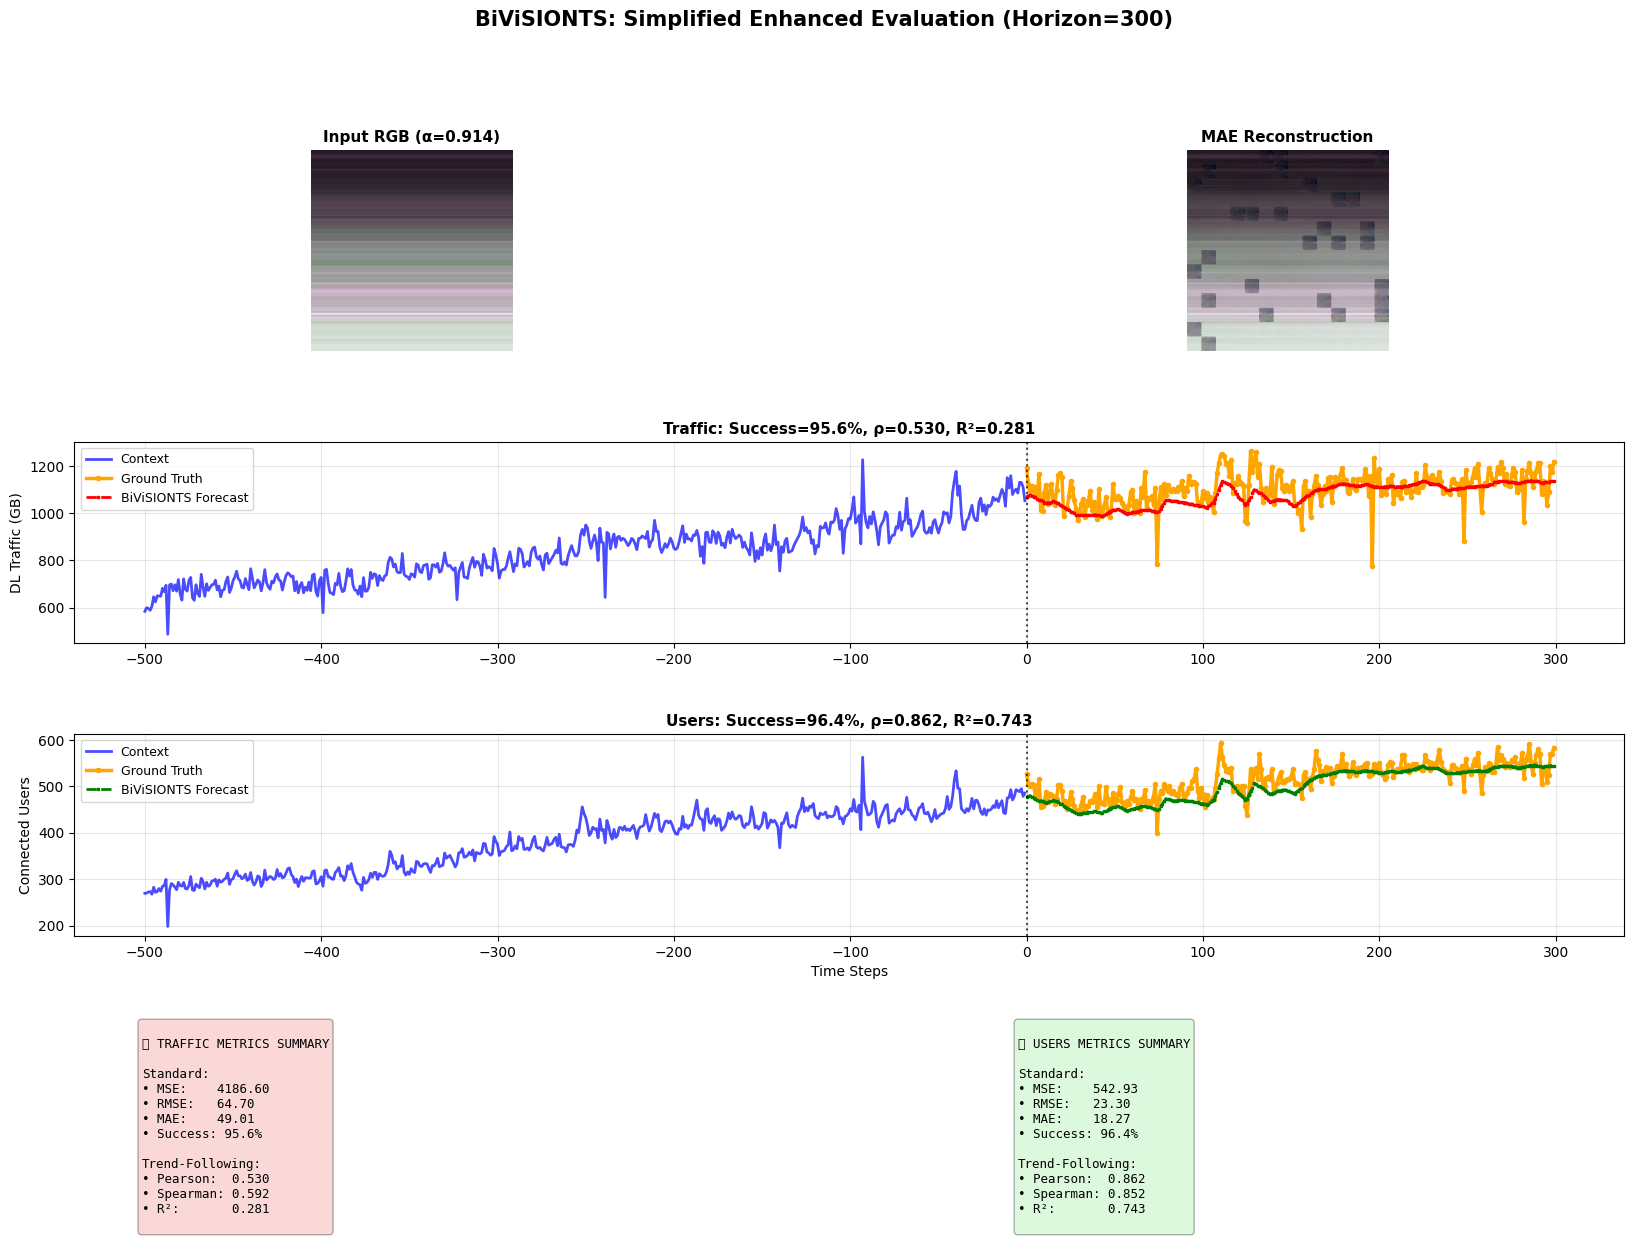


💾 Visualization saved to: bivisionts_pred300_simplified_enhanced_results.png


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from visionts.models_mae import MaskedAutoencoderViT
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ⚙️ EXPERIMENT CONFIGURATION - MODIFY HERE FOR EXPERIMENTS
# ============================================================================
CONFIG = {
    # Forecasting Parameters (Common across all methods)
    'PRED_LEN': 300,              # Forecast horizon
    'MIN_CONTEXT_LEN': 600,       # Minimum required training samples
    'CONTEXT_PLOT_LEN': 500,      # Context length shown in plots
    
    # Data Source (Common)
    'DATA_PATH': './long_term_tsf/dataset/Telecom/Site_1.csv',
    'TRAFFIC_COL': 'dl_traffic_volume_gb',
    'USERS_COL': 'connected_users',
    
    # BiViSIONTS-Specific Hyperparameters
    'MASK_RATIO': 0.85,           # MAE masking ratio (0.75-0.90)
    'PERIODICITY': 1,             # Temporal periodicity for reshaping
    'SHORT_WINDOW': 150,          # Short-term correlation window
    'MEDIUM_WINDOW': 400,         # Medium-term correlation window
    
    # Model Configuration
    'DEVICE': 'cpu',              # 'cpu' or 'cuda'
    'MAE_CHECKPOINT': './ckpt/mae_visualize_vit_base.pth',
    
    # Output Settings (Common)
    'SAVE_PLOT': True,
    'PLOT_DPI': 300,
    'OUTPUT_PREFIX': 'bivisionts'
}

# ============================================================================
# BIVISIONTS FORECASTING - SIMPLIFIED ENHANCED METRICS
# ============================================================================

def cal_metrics_simplified(y, forecast):
    """
    Calculate simplified comprehensive metrics:
    - Standard: MSE, MAE, RMSE, Success Rate
    - Trend-Following: Pearson, Spearman, R²
    """
    # ============================================
    # STANDARD METRICS
    # ============================================
    mse = mean_squared_error(y, forecast)
    mae = mean_absolute_error(y, forecast)
    rmse = np.sqrt(mse)
    
    # WMAPE-based success rate
    wmape = np.sum(np.abs(y - forecast)) / (np.sum(np.abs(y)) + 1e-8) * 100
    success = max(0, min(1, (100 - wmape) / 100))
    
    # ============================================
    # TREND-FOLLOWING METRICS
    # ============================================
    
    # Correlation Coefficients
    try:
        pearson_corr, _ = pearsonr(y, forecast)
        spearman_corr, _ = spearmanr(y, forecast)
    except:
        pearson_corr = 0.0
        spearman_corr = 0.0
    
    # R² (Coefficient of Determination)
    r_squared = pearson_corr ** 2 if pearson_corr > 0 else 0.0
    
    return {
        # Standard
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'success_rate': success * 100,
        # Trend-Following
        'pearson_correlation': pearson_corr,
        'spearman_correlation': spearman_corr,
        'r_squared': r_squared
    }

def bivariate_multiscale_attention(series1, series2, periodicity=24, short_window=100, medium_window=300):
    """Multi-Scale Attention-Weighted Encoding"""
    total_len = len(series1)
    usable_len = total_len - (total_len % periodicity)
    
    # Reshape
    matrix1 = series1[:usable_len].reshape(-1, periodicity)
    matrix2 = series2[:usable_len].reshape(-1, periodicity)
    
    # Store min/max
    min1, max1 = matrix1.min(), matrix1.max()
    min2, max2 = matrix2.min(), matrix2.max()
    
    # Normalize
    matrix1_norm = (matrix1 - min1) / (max1 - min1 + 1e-8)
    matrix2_norm = (matrix2 - min2) / (max2 - min2 + 1e-8)
    
    # Multi-scale correlations
    corr_long = np.corrcoef(series1[:usable_len], series2[:usable_len])[0, 1]
    alpha_long = (corr_long + 1) / 2
    
    if usable_len > medium_window:
        corr_medium = np.corrcoef(series1[usable_len-medium_window:usable_len], 
                                   series2[usable_len-medium_window:usable_len])[0, 1]
        alpha_medium = (corr_medium + 1) / 2
    else:
        corr_medium = corr_long
        alpha_medium = alpha_long
    
    if usable_len > short_window:
        corr_short = np.corrcoef(series1[usable_len-short_window:usable_len], 
                                  series2[usable_len-short_window:usable_len])[0, 1]
        alpha_short = (corr_short + 1) / 2
    else:
        corr_short = corr_long
        alpha_short = alpha_long
    
    # Weighted combination
    alpha_final = 0.5 * alpha_short + 0.3 * alpha_medium + 0.2 * alpha_long
    
    print(f"📊 Multi-Scale Correlations:")
    print(f"  Short: ρ={corr_short:.4f}, α={alpha_short:.4f}")
    print(f"  Medium: ρ={corr_medium:.4f}, α={alpha_medium:.4f}")
    print(f"  Long: ρ={corr_long:.4f}, α={alpha_long:.4f}")
    print(f"  ⚡ Final α: {alpha_final:.4f}")
    
    # Create RGB
    matrix_fusion = alpha_final * matrix1_norm + (1 - alpha_final) * matrix2_norm
    r_channel = (matrix1_norm * 255).astype(np.uint8)
    g_channel = (matrix2_norm * 255).astype(np.uint8)
    b_channel = (matrix_fusion * 255).astype(np.uint8)
    
    rgb_array = np.stack([r_channel, g_channel, b_channel], axis=-1)
    img = Image.fromarray(rgb_array, mode='RGB').resize((224, 224), Image.BILINEAR)
    
    norm_params = {
        'min1': min1, 'max1': max1,
        'min2': min2, 'max2': max2,
        'usable_len': usable_len,
        'alpha_final': alpha_final,
        'alpha_short': alpha_short,
        'alpha_medium': alpha_medium,
        'alpha_long': alpha_long,
        'corr_short': corr_short,
        'corr_medium': corr_medium,
        'corr_long': corr_long
    }
    
    return img, norm_params

def multiscale_attention_to_bivariate(img, norm_params, periodicity=24):
    """Decode RGB back to bivariate series"""
    matrix_h = norm_params['usable_len'] // periodicity
    
    img_resized = img.resize((periodicity, matrix_h), Image.BILINEAR)
    img_array = np.array(img_resized).astype(np.float32) / 255.0
    
    r_channel = img_array[:, :, 0]
    g_channel = img_array[:, :, 1]
    
    series1_norm = r_channel.flatten()
    series2_norm = g_channel.flatten()
    
    series1 = series1_norm * (norm_params['max1'] - norm_params['min1']) + norm_params['min1']
    series2 = series2_norm * (norm_params['max2'] - norm_params['min2']) + norm_params['min2']
    
    return series1, series2

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("⚙️  EXPERIMENT CONFIGURATION")
print("=" * 80)
print(f"Forecast Horizon: {CONFIG['PRED_LEN']} steps")
print(f"BiViSIONTS Parameters:")
print(f"  Mask Ratio: {CONFIG['MASK_RATIO']}")
print(f"  Periodicity: {CONFIG['PERIODICITY']}")
print(f"  Short Window: {CONFIG['SHORT_WINDOW']}")
print(f"  Medium Window: {CONFIG['MEDIUM_WINDOW']}")
print(f"Device: {CONFIG['DEVICE']}")
print(f"Data: {CONFIG['DATA_PATH']}")
print("=" * 80)

# Load data
try:
    df = pd.read_csv(CONFIG['DATA_PATH'])
except FileNotFoundError:
    print(f"❌ Error: Dataset file not found at {CONFIG['DATA_PATH']}")
    exit(1)

PRED_LEN = CONFIG['PRED_LEN']
CONTEXT_LEN = len(df) - PRED_LEN

# Validate data
if CONTEXT_LEN <= 0:
    print(f"❌ Error: PRED_LEN ({PRED_LEN}) exceeds dataset length ({len(df)})")
    exit(1)

if CONTEXT_LEN < CONFIG['MIN_CONTEXT_LEN']:
    print(f"⚠️  Warning: Context length ({CONTEXT_LEN}) < minimum ({CONFIG['MIN_CONTEXT_LEN']})")
    print(f"   This may lead to poor model performance!")

data_traffic = df[CONFIG['TRAFFIC_COL']].values
data_users = df[CONFIG['USERS_COL']].values

# Check for NaN/inf values
if np.any(np.isnan(data_traffic)) or np.any(np.isinf(data_traffic)):
    print("❌ Error: Traffic data contains NaN or Inf values")
    exit(1)

if np.any(np.isnan(data_users)) or np.any(np.isinf(data_users)):
    print("❌ Error: Users data contains NaN or Inf values")
    exit(1)

# Configuration
DEVICE = CONFIG['DEVICE']
MASK_RATIO = CONFIG['MASK_RATIO']
PERIODICITY = CONFIG['PERIODICITY']
SHORT_WINDOW = CONFIG['SHORT_WINDOW']
MEDIUM_WINDOW = CONFIG['MEDIUM_WINDOW']

print("\n" + "=" * 80)
print("🚀 BIVISIONTS FORECASTING - SIMPLIFIED ENHANCED METRICS")
print("=" * 80)
print(f"Context: {CONTEXT_LEN}, Forecast: {PRED_LEN}")
print(f"Mask Ratio: {MASK_RATIO}, Periodicity: {PERIODICITY}")

# Initialize MAE model
try:
    mae_model = MaskedAutoencoderViT(
        img_size=224, patch_size=16, in_chans=3,
        embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
    )
    ckpt = torch.load(CONFIG['MAE_CHECKPOINT'], map_location='cpu')
    mae_model.load_state_dict(ckpt['model'], strict=False)
    mae_model.eval()
    mae_model.to(DEVICE)
    print("✅ MAE model loaded successfully")
except Exception as e:
    print(f"❌ Error loading MAE model: {str(e)}")
    exit(1)

# Prepare full series
full_traffic = data_traffic[:CONTEXT_LEN + PRED_LEN]
full_users = data_users[:CONTEXT_LEN + PRED_LEN]

# Create multi-scale attention image
input_img, norm_params = bivariate_multiscale_attention(
    full_traffic, full_users, 
    periodicity=PERIODICITY, 
    short_window=SHORT_WINDOW, 
    medium_window=MEDIUM_WINDOW
)

# Run MAE
x_tensor = ToTensor()(input_img).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=MASK_RATIO)
    pred = mae_model.forward_decoder(latent, ids_restore)
    recon_tensor = mae_model.unpatchify(pred)

# Convert reconstruction
recon_rgb = recon_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
recon_rgb = np.clip(recon_rgb * 255, 0, 255).astype(np.uint8)
recon_img = Image.fromarray(recon_rgb, mode='RGB')

# Decode forecasts
recon_traffic_full, recon_users_full = multiscale_attention_to_bivariate(
    recon_img, norm_params, periodicity=PERIODICITY
)

forecast_traffic = recon_traffic_full[-PRED_LEN:]
forecast_users = recon_users_full[-PRED_LEN:]

# Ground truth
y_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
y_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Calculate SIMPLIFIED ENHANCED metrics
metrics_traffic = cal_metrics_simplified(y_traffic, forecast_traffic)
metrics_users = cal_metrics_simplified(y_users, forecast_users)

# ============================================================================
# PRINT COMPREHENSIVE RESULTS
# ============================================================================
print("\n" + "=" * 80)
print("📊 BIVISIONTS SIMPLIFIED ENHANCED EVALUATION")
print("=" * 80)

print(f"\n🔴 DL Traffic Volume:")
print(f"  Standard Metrics:")
print(f"    MSE:  {metrics_traffic['mse']:.4f}")
print(f"    MAE:  {metrics_traffic['mae']:.4f}")
print(f"    RMSE: {metrics_traffic['rmse']:.4f}")
print(f"    ✅ Success Rate: {metrics_traffic['success_rate']:.2f}%")
print(f"  Trend-Following Metrics:")
print(f"    🔗 Pearson Correlation: {metrics_traffic['pearson_correlation']:.4f}")
print(f"    📊 Spearman Correlation: {metrics_traffic['spearman_correlation']:.4f}")
print(f"    🎲 R²: {metrics_traffic['r_squared']:.4f}")

print(f"\n🟢 Connected Users:")
print(f"  Standard Metrics:")
print(f"    MSE:  {metrics_users['mse']:.4f}")
print(f"    MAE:  {metrics_users['mae']:.4f}")
print(f"    RMSE: {metrics_users['rmse']:.4f}")
print(f"    ✅ Success Rate: {metrics_users['success_rate']:.2f}%")
print(f"  Trend-Following Metrics:")
print(f"    🔗 Pearson Correlation: {metrics_users['pearson_correlation']:.4f}")
print(f"    📊 Spearman Correlation: {metrics_users['spearman_correlation']:.4f}")
print(f"    🎲 R²: {metrics_users['r_squared']:.4f}")

# Calculate averages
avg_success = (metrics_traffic['success_rate'] + metrics_users['success_rate']) / 2
avg_corr = (metrics_traffic['pearson_correlation'] + metrics_users['pearson_correlation']) / 2
avg_r2 = (metrics_traffic['r_squared'] + metrics_users['r_squared']) / 2

print(f"\n🎯 Overall Performance:")
print(f"  Average Success Rate: {avg_success:.2f}%")
print(f"  Average Pearson Correlation: {avg_corr:.4f}")
print(f"  Average R²: {avg_r2:.4f}")
print("=" * 80)

# ============================================================================
# SAVE SIMPLIFIED ENHANCED METRICS
# ============================================================================
results_df = pd.DataFrame({
    'Method': ['BiViSIONTS'],
    'Pred_Len': [PRED_LEN],
    'Mask_Ratio': [MASK_RATIO],
    'Periodicity': [PERIODICITY],
    'Short_Window': [SHORT_WINDOW],
    'Medium_Window': [MEDIUM_WINDOW],
    # Traffic - Standard
    'Traffic_MSE': [metrics_traffic['mse']],
    'Traffic_MAE': [metrics_traffic['mae']],
    'Traffic_RMSE': [metrics_traffic['rmse']],
    'Traffic_Success_%': [metrics_traffic['success_rate']],
    # Traffic - Trend-Following
    'Traffic_Pearson': [metrics_traffic['pearson_correlation']],
    'Traffic_Spearman': [metrics_traffic['spearman_correlation']],
    'Traffic_R2': [metrics_traffic['r_squared']],
    # Users - Standard
    'Users_MSE': [metrics_users['mse']],
    'Users_MAE': [metrics_users['mae']],
    'Users_RMSE': [metrics_users['rmse']],
    'Users_Success_%': [metrics_users['success_rate']],
    # Users - Trend-Following
    'Users_Pearson': [metrics_users['pearson_correlation']],
    'Users_Spearman': [metrics_users['spearman_correlation']],
    'Users_R2': [metrics_users['r_squared']],
    # Overall
    'Avg_Success_%': [avg_success],
    'Avg_Correlation': [avg_corr],
    'Avg_R2': [avg_r2]
})

output_csv = f"{CONFIG['OUTPUT_PREFIX']}_simplified_enhanced_metrics.csv"
results_df.to_csv(output_csv, index=False)
print(f"\n💾 Simplified enhanced metrics saved to: {output_csv}")
print("=" * 80)

# ============================================================================
# ENHANCED VISUALIZATION
# ============================================================================
if CONFIG['SAVE_PLOT']:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 2, hspace=0.45, wspace=0.3)
    
    # Panel 1: Input Image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(input_img)
    ax1.set_title(f"Input RGB (α={norm_params['alpha_final']:.3f})", fontweight='bold', fontsize=11)
    ax1.axis('off')
    
    # Panel 2: Reconstruction
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(recon_img)
    ax2.set_title("MAE Reconstruction", fontweight='bold', fontsize=11)
    ax2.axis('off')
    
    # Forecasts
    context_plot = min(CONFIG['CONTEXT_PLOT_LEN'], CONTEXT_LEN)
    time_x = range(-context_plot, 0)
    time_y = range(0, PRED_LEN)
    
    # Panel 3: Traffic Forecast
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(time_x, data_traffic[CONTEXT_LEN-context_plot:CONTEXT_LEN], 'b-', linewidth=2, label='Context', alpha=0.7)
    ax3.plot(time_y, y_traffic, 'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax3.plot(time_y, forecast_traffic, 'r--', linewidth=2, label='BiViSIONTS Forecast', marker='s', markersize=2)
    ax3.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax3.set_title(f'Traffic: Success={metrics_traffic["success_rate"]:.1f}%, ρ={metrics_traffic["pearson_correlation"]:.3f}, R²={metrics_traffic["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax3.set_ylabel('DL Traffic (GB)', fontsize=10)
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(alpha=0.3)
    
    # Panel 4: Users Forecast
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(time_x, data_users[CONTEXT_LEN-context_plot:CONTEXT_LEN], 'b-', linewidth=2, label='Context', alpha=0.7)
    ax4.plot(time_y, y_users, 'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax4.plot(time_y, forecast_users, 'g--', linewidth=2, label='BiViSIONTS Forecast', marker='s', markersize=2)
    ax4.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax4.set_title(f'Users: Success={metrics_users["success_rate"]:.1f}%, ρ={metrics_users["pearson_correlation"]:.3f}, R²={metrics_users["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax4.set_xlabel('Time Steps', fontsize=10)
    ax4.set_ylabel('Connected Users', fontsize=10)
    ax4.legend(loc='best', fontsize=9)
    ax4.grid(alpha=0.3)
    
    # Panel 5: Metrics Summary (Traffic)
    ax5 = fig.add_subplot(gs[3, 0])
    ax5.axis('off')
    traffic_text = f"""
🔴 TRAFFIC METRICS SUMMARY

Standard:
• MSE:    {metrics_traffic['mse']:.2f}
• RMSE:   {metrics_traffic['rmse']:.2f}
• MAE:    {metrics_traffic['mae']:.2f}
• Success: {metrics_traffic['success_rate']:.1f}%

Trend-Following:
• Pearson:  {metrics_traffic['pearson_correlation']:.3f}
• Spearman: {metrics_traffic['spearman_correlation']:.3f}
• R²:       {metrics_traffic['r_squared']:.3f}
"""
    ax5.text(0.1, 0.5, traffic_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
    
    # Panel 6: Metrics Summary (Users)
    ax6 = fig.add_subplot(gs[3, 1])
    ax6.axis('off')
    users_text = f"""
🟢 USERS METRICS SUMMARY

Standard:
• MSE:    {metrics_users['mse']:.2f}
• RMSE:   {metrics_users['rmse']:.2f}
• MAE:    {metrics_users['mae']:.2f}
• Success: {metrics_users['success_rate']:.1f}%

Trend-Following:
• Pearson:  {metrics_users['pearson_correlation']:.3f}
• Spearman: {metrics_users['spearman_correlation']:.3f}
• R²:       {metrics_users['r_squared']:.3f}
"""
    ax6.text(0.1, 0.5, users_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    plt.suptitle(f'BiViSIONTS: Simplified Enhanced Evaluation (Horizon={PRED_LEN})', fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    output_file = f"{CONFIG['OUTPUT_PREFIX']}_pred{PRED_LEN}_simplified_enhanced_results.png"
    plt.savefig(output_file, dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Visualization saved to: {output_file}")
else:
    print("\n⚠️  Plot saving disabled in configuration")

## BASELINE 1: ARIMA

⚙️  EXPERIMENT CONFIGURATION
Forecast Horizon: 300 steps
ARIMA Search Space: p≤3, d≤2, q≤2
Data: ./long_term_tsf/dataset/Telecom/Site_1.csv

📊 ARIMA BASELINE - SIMPLIFIED ENHANCED METRICS
Context Length: 718
Forecast Length: 300

🔴 Running ARIMA for Traffic...

📊 Stationarity Test for Traffic:
   ADF Statistic: 0.4863
   p-value: 0.9845
   ⚠️  Series is non-stationary (p-value > 0.05)
   Recommendation: Use differencing (d=1 or d=2)

🔍 Finding optimal ARIMA order for Traffic...
   Search space: p∈[0,3], d∈[0,2], q∈[0,2]
   ✅ Best order: (1, 2, 2) (AIC=7288.59)

✅ ARIMA Traffic Results (order=(1, 2, 2)):
  Standard Metrics:
    MSE:  22464.7688
    MAE:  130.5150
    RMSE: 149.8825
    ✅ Success Rate: 88.18%
  Trend-Following Metrics:
    🔗 Pearson Correlation: 0.3674
    📊 Spearman Correlation: 0.4383
    🎲 R²: 0.1350

🟢 Running ARIMA for Users...

📊 Stationarity Test for Users:
   ADF Statistic: 0.3060
   p-value: 0.9776
   ⚠️  Series is non-stationary (p-value > 0.05)
   Recommendati

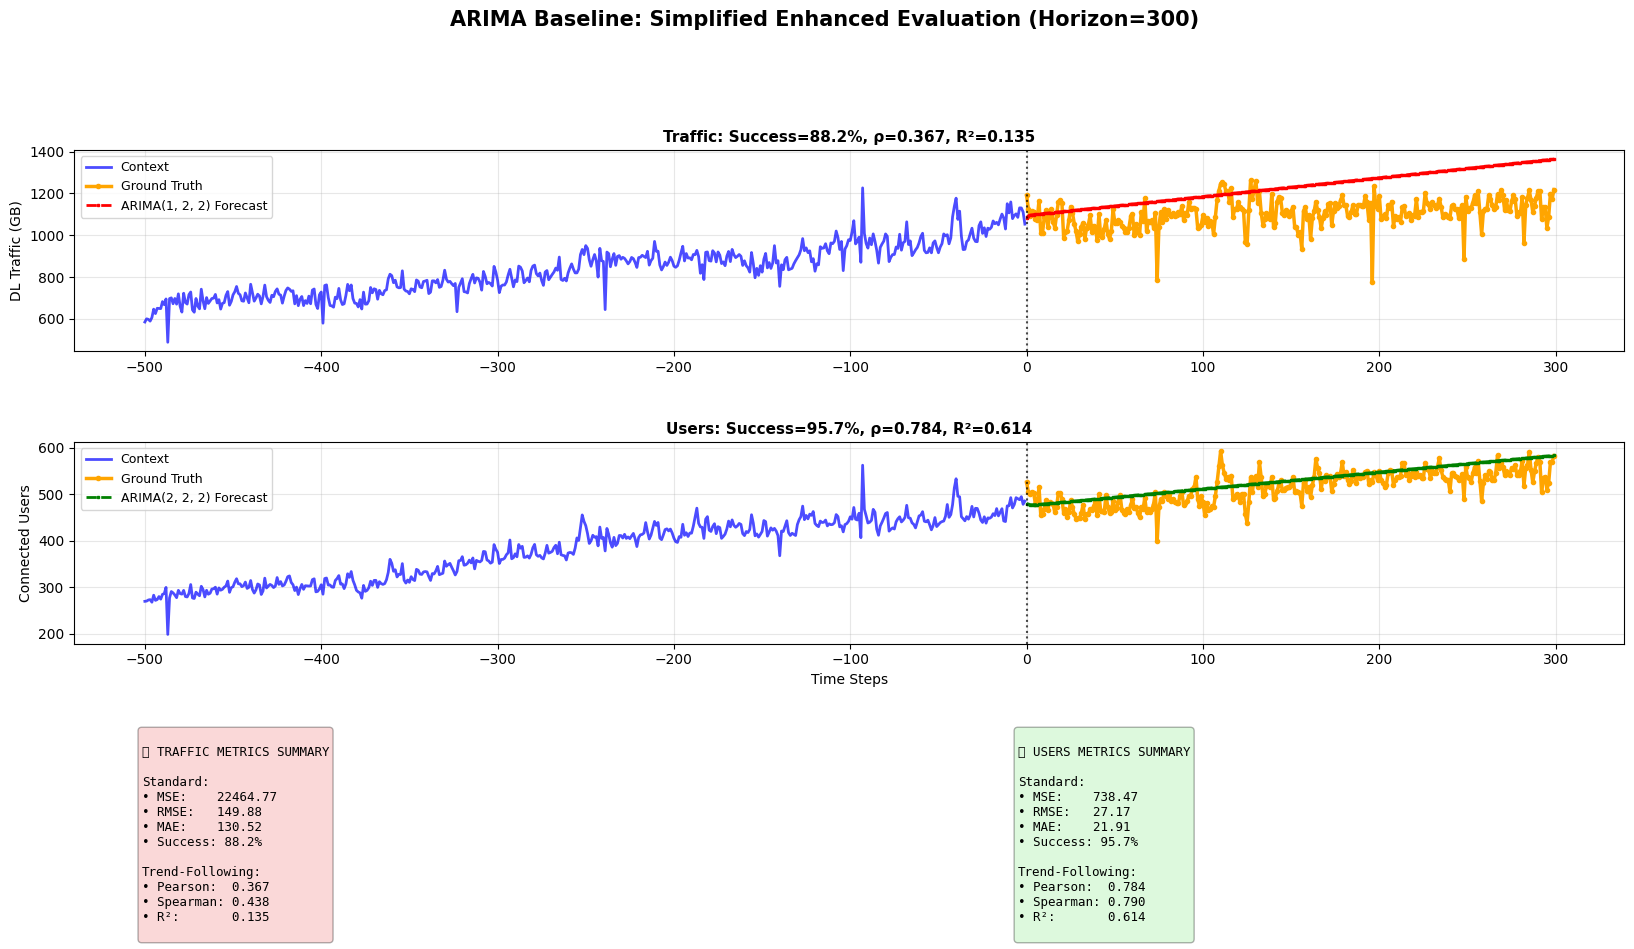

💾 Simplified enhanced metrics saved to: baseline_arima_simplified_enhanced_metrics.csv


In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ⚙️ EXPERIMENT CONFIGURATION - MODIFY HERE FOR CHALLENGING EXPERIMENTS
# ============================================================================
CONFIG = {
    # Forecasting Parameters
    'PRED_LEN': 300,              # Forecast horizon (increase for harder challenge)
    'MIN_CONTEXT_LEN': 600,       # Minimum required training samples
    'CONTEXT_PLOT_LEN': 500,      # Context length shown in plots
    
    # ARIMA Hyperparameters
    'MAX_P': 3,                   # Max AR order (increase for more complexity)
    'MAX_D': 2,                   # Max differencing order
    'MAX_Q': 2,                   # Max MA order (increase for more complexity)
    
    # Data Source
    'DATA_PATH': './long_term_tsf/dataset/Telecom/Site_1.csv',
    'TRAFFIC_COL': 'dl_traffic_volume_gb',
    'USERS_COL': 'connected_users',
    
    # Output Settings
    'SAVE_PLOT': True,
    'PLOT_DPI': 300,
    'OUTPUT_PREFIX': 'baseline_arima'
}

# ============================================================================
# ARIMA BASELINE - SIMPLIFIED ENHANCED METRICS
# ============================================================================

def cal_metrics_simplified(y, forecast):
    """
    Calculate simplified comprehensive metrics:
    - Standard: MSE, MAE, RMSE, Success Rate
    - Trend-Following: Pearson, Spearman, R²
    """
    # ============================================
    # STANDARD METRICS
    # ============================================
    mse = mean_squared_error(y, forecast)
    mae = mean_absolute_error(y, forecast)
    rmse = np.sqrt(mse)
    
    # WMAPE-based success rate
    wmape = np.sum(np.abs(y - forecast)) / (np.sum(np.abs(y)) + 1e-8) * 100
    success = max(0, min(1, (100 - wmape) / 100))
    
    # ============================================
    # TREND-FOLLOWING METRICS
    # ============================================
    
    # Correlation Coefficients
    try:
        pearson_corr, _ = pearsonr(y, forecast)
        spearman_corr, _ = spearmanr(y, forecast)
    except:
        pearson_corr = 0.0
        spearman_corr = 0.0
    
    # R² (Coefficient of Determination)
    r_squared = pearson_corr ** 2 if pearson_corr > 0 else 0.0
    
    return {
        # Standard
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'success_rate': success * 100,
        # Trend-Following
        'pearson_correlation': pearson_corr,
        'spearman_correlation': spearman_corr,
        'r_squared': r_squared
    }

def check_stationarity(series, name):
    """Check if series is stationary using ADF test"""
    result = adfuller(series, autolag='AIC')
    print(f"\n📊 Stationarity Test for {name}:")
    print(f"   ADF Statistic: {result[0]:.4f}")
    print(f"   p-value: {result[1]:.4f}")
    
    if result[1] <= 0.05:
        print(f"   ✅ Series is stationary (p-value ≤ 0.05)")
        return True, 0
    else:
        print(f"   ⚠️  Series is non-stationary (p-value > 0.05)")
        print(f"   Recommendation: Use differencing (d=1 or d=2)")
        return False, 1

def find_best_arima_order(series, name, max_p, max_d, max_q):
    """Find optimal ARIMA order using AIC"""
    from itertools import product
    
    print(f"\n🔍 Finding optimal ARIMA order for {name}...")
    print(f"   Search space: p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]")
    
    best_aic = np.inf
    best_order = (1, 1, 0)
    
    for p, d, q in product(range(max_p+1), range(max_d+1), range(max_q+1)):
        if p == 0 and d == 0 and q == 0:
            continue
        
        try:
            model = ARIMA(series, order=(p, d, q))
            fitted = model.fit()
            
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_order = (p, d, q)
        except:
            continue
    
    print(f"   ✅ Best order: {best_order} (AIC={best_aic:.2f})")
    return best_order

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("⚙️  EXPERIMENT CONFIGURATION")
print("=" * 80)
print(f"Forecast Horizon: {CONFIG['PRED_LEN']} steps")
print(f"ARIMA Search Space: p≤{CONFIG['MAX_P']}, d≤{CONFIG['MAX_D']}, q≤{CONFIG['MAX_Q']}")
print(f"Data: {CONFIG['DATA_PATH']}")
print("=" * 80)

# Load data
try:
    df = pd.read_csv(CONFIG['DATA_PATH'])
except FileNotFoundError:
    print(f"❌ Error: Dataset file not found at {CONFIG['DATA_PATH']}")
    exit(1)

PRED_LEN = CONFIG['PRED_LEN']
CONTEXT_LEN = len(df) - PRED_LEN

# Validate data
if CONTEXT_LEN <= 0:
    print(f"❌ Error: PRED_LEN ({PRED_LEN}) exceeds dataset length ({len(df)})")
    exit(1)

if CONTEXT_LEN < CONFIG['MIN_CONTEXT_LEN']:
    print(f"⚠️  Warning: Context length ({CONTEXT_LEN}) < minimum ({CONFIG['MIN_CONTEXT_LEN']})")
    print(f"   This may lead to poor model performance!")

data_traffic = df[CONFIG['TRAFFIC_COL']].values
data_users = df[CONFIG['USERS_COL']].values

# Check for NaN/inf values
if np.any(np.isnan(data_traffic)) or np.any(np.isinf(data_traffic)):
    print("❌ Error: Traffic data contains NaN or Inf values")
    exit(1)

if np.any(np.isnan(data_users)) or np.any(np.isinf(data_users)):
    print("❌ Error: Users data contains NaN or Inf values")
    exit(1)

# Split data
train_traffic = data_traffic[:CONTEXT_LEN]
test_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

train_users = data_users[:CONTEXT_LEN]
test_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

print("\n" + "=" * 80)
print("📊 ARIMA BASELINE - SIMPLIFIED ENHANCED METRICS")
print("=" * 80)
print(f"Context Length: {CONTEXT_LEN}")
print(f"Forecast Length: {PRED_LEN}")

# ============================================================================
# ARIMA for Traffic
# ============================================================================
print("\n🔴 Running ARIMA for Traffic...")

is_stationary_t, recommended_d_t = check_stationarity(train_traffic, "Traffic")

try:
    best_order_t = find_best_arima_order(
        train_traffic, "Traffic", 
        CONFIG['MAX_P'], CONFIG['MAX_D'], CONFIG['MAX_Q']
    )
    
    model_traffic = ARIMA(train_traffic, order=best_order_t)
    fitted_traffic = model_traffic.fit()
    
    forecast_traffic = fitted_traffic.forecast(steps=PRED_LEN)
    
    # Calculate SIMPLIFIED ENHANCED metrics
    metrics_traffic = cal_metrics_simplified(test_traffic, forecast_traffic)
    
    print(f"\n✅ ARIMA Traffic Results (order={best_order_t}):")
    print(f"  Standard Metrics:")
    print(f"    MSE:  {metrics_traffic['mse']:.4f}")
    print(f"    MAE:  {metrics_traffic['mae']:.4f}")
    print(f"    RMSE: {metrics_traffic['rmse']:.4f}")
    print(f"    ✅ Success Rate: {metrics_traffic['success_rate']:.2f}%")
    print(f"  Trend-Following Metrics:")
    print(f"    🔗 Pearson Correlation: {metrics_traffic['pearson_correlation']:.4f}")
    print(f"    📊 Spearman Correlation: {metrics_traffic['spearman_correlation']:.4f}")
    print(f"    🎲 R²: {metrics_traffic['r_squared']:.4f}")
    
    arima_traffic_success = True
    
except Exception as e:
    print(f"❌ ARIMA Traffic failed: {str(e)}")
    forecast_traffic = np.zeros(PRED_LEN)
    metrics_traffic = {
        'mse': 0, 'mae': 0, 'rmse': 0, 'success_rate': 0,
        'pearson_correlation': 0, 'spearman_correlation': 0, 'r_squared': 0
    }
    arima_traffic_success = False
    best_order_t = (5, 1, 0)

# ============================================================================
# ARIMA for Users
# ============================================================================
print("\n🟢 Running ARIMA for Users...")

is_stationary_u, recommended_d_u = check_stationarity(train_users, "Users")

try:
    best_order_u = find_best_arima_order(
        train_users, "Users", 
        CONFIG['MAX_P'], CONFIG['MAX_D'], CONFIG['MAX_Q']
    )
    
    model_users = ARIMA(train_users, order=best_order_u)
    fitted_users = model_users.fit()
    
    forecast_users = fitted_users.forecast(steps=PRED_LEN)
    
    # Calculate SIMPLIFIED ENHANCED metrics
    metrics_users = cal_metrics_simplified(test_users, forecast_users)
    
    print(f"\n✅ ARIMA Users Results (order={best_order_u}):")
    print(f"  Standard Metrics:")
    print(f"    MSE:  {metrics_users['mse']:.4f}")
    print(f"    MAE:  {metrics_users['mae']:.4f}")
    print(f"    RMSE: {metrics_users['rmse']:.4f}")
    print(f"    ✅ Success Rate: {metrics_users['success_rate']:.2f}%")
    print(f"  Trend-Following Metrics:")
    print(f"    🔗 Pearson Correlation: {metrics_users['pearson_correlation']:.4f}")
    print(f"    📊 Spearman Correlation: {metrics_users['spearman_correlation']:.4f}")
    print(f"    🎲 R²: {metrics_users['r_squared']:.4f}")
    
    arima_users_success = True
    
except Exception as e:
    print(f"❌ ARIMA Users failed: {str(e)}")
    forecast_users = np.zeros(PRED_LEN)
    metrics_users = {
        'mse': 0, 'mae': 0, 'rmse': 0, 'success_rate': 0,
        'pearson_correlation': 0, 'spearman_correlation': 0, 'r_squared': 0
    }
    arima_users_success = False
    best_order_u = (5, 1, 0)

# ============================================================================
# OVERALL SUMMARY
# ============================================================================
avg_success = (metrics_traffic['success_rate'] + metrics_users['success_rate']) / 2
avg_corr = (metrics_traffic['pearson_correlation'] + metrics_users['pearson_correlation']) / 2
avg_r2 = (metrics_traffic['r_squared'] + metrics_users['r_squared']) / 2

print(f"\n🎯 Overall ARIMA Performance:")
print(f"  Average Success Rate: {avg_success:.2f}%")
print(f"  Average Pearson Correlation: {avg_corr:.4f}")
print(f"  Average R²: {avg_r2:.4f}")

# ============================================================================
# ENHANCED VISUALIZATION
# ============================================================================
if arima_traffic_success and arima_users_success:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 2, hspace=0.45, wspace=0.3)
    
    context_plot = min(CONFIG['CONTEXT_PLOT_LEN'], CONTEXT_LEN)
    time_x = range(-context_plot, 0)
    time_y = range(0, PRED_LEN)
    
    # Traffic forecast
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time_x, train_traffic[-context_plot:], 
             'b-', linewidth=2, label='Context', alpha=0.7)
    ax1.plot(time_y, test_traffic, 
             'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax1.plot(time_y, forecast_traffic, 
             'r--', linewidth=2, label=f'ARIMA{best_order_t} Forecast', marker='s', markersize=2)
    ax1.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax1.set_title(f'Traffic: Success={metrics_traffic["success_rate"]:.1f}%, ρ={metrics_traffic["pearson_correlation"]:.3f}, R²={metrics_traffic["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax1.set_ylabel('DL Traffic (GB)', fontsize=10)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Users forecast
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(time_x, train_users[-context_plot:], 
             'b-', linewidth=2, label='Context', alpha=0.7)
    ax2.plot(time_y, test_users, 
             'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax2.plot(time_y, forecast_users, 
             'g--', linewidth=2, label=f'ARIMA{best_order_u} Forecast', marker='s', markersize=2)
    ax2.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax2.set_title(f'Users: Success={metrics_users["success_rate"]:.1f}%, ρ={metrics_users["pearson_correlation"]:.3f}, R²={metrics_users["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax2.set_xlabel('Time Steps', fontsize=10)
    ax2.set_ylabel('Connected Users', fontsize=10)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(alpha=0.3)
    
    # Metrics Summary (Traffic)
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.axis('off')
    traffic_text = f"""
🔴 TRAFFIC METRICS SUMMARY

Standard:
• MSE:    {metrics_traffic['mse']:.2f}
• RMSE:   {metrics_traffic['rmse']:.2f}
• MAE:    {metrics_traffic['mae']:.2f}
• Success: {metrics_traffic['success_rate']:.1f}%

Trend-Following:
• Pearson:  {metrics_traffic['pearson_correlation']:.3f}
• Spearman: {metrics_traffic['spearman_correlation']:.3f}
• R²:       {metrics_traffic['r_squared']:.3f}
"""
    ax3.text(0.1, 0.5, traffic_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
    
    # Metrics Summary (Users)
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.axis('off')
    users_text = f"""
🟢 USERS METRICS SUMMARY

Standard:
• MSE:    {metrics_users['mse']:.2f}
• RMSE:   {metrics_users['rmse']:.2f}
• MAE:    {metrics_users['mae']:.2f}
• Success: {metrics_users['success_rate']:.1f}%

Trend-Following:
• Pearson:  {metrics_users['pearson_correlation']:.3f}
• Spearman: {metrics_users['spearman_correlation']:.3f}
• R²:       {metrics_users['r_squared']:.3f}
"""
    ax4.text(0.1, 0.5, users_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    plt.suptitle(f'ARIMA Baseline: Simplified Enhanced Evaluation (Horizon={PRED_LEN})', 
                 fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    if CONFIG['SAVE_PLOT']:
        output_file = f"{CONFIG['OUTPUT_PREFIX']}_pred{PRED_LEN}_simplified_enhanced_results.png"
        plt.savefig(output_file, dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')
        print(f"\n💾 Results saved to: {output_file}")
    
    plt.show()
else:
    print("\n⚠️  Visualization skipped due to ARIMA failures")

# ============================================================================
# SAVE SIMPLIFIED ENHANCED RESULTS
# ============================================================================
results_df = pd.DataFrame({
    'Method': ['ARIMA'],
    'Pred_Len': [PRED_LEN],
    'Traffic_Order': [str(best_order_t)],
    'Users_Order': [str(best_order_u)],
    # Traffic - Standard
    'Traffic_MSE': [metrics_traffic['mse']],
    'Traffic_MAE': [metrics_traffic['mae']],
    'Traffic_RMSE': [metrics_traffic['rmse']],
    'Traffic_Success_%': [metrics_traffic['success_rate']],
    # Traffic - Trend-Following
    'Traffic_Pearson': [metrics_traffic['pearson_correlation']],
    'Traffic_Spearman': [metrics_traffic['spearman_correlation']],
    'Traffic_R2': [metrics_traffic['r_squared']],
    # Users - Standard
    'Users_MSE': [metrics_users['mse']],
    'Users_MAE': [metrics_users['mae']],
    'Users_RMSE': [metrics_users['rmse']],
    'Users_Success_%': [metrics_users['success_rate']],
    # Users - Trend-Following
    'Users_Pearson': [metrics_users['pearson_correlation']],
    'Users_Spearman': [metrics_users['spearman_correlation']],
    'Users_R2': [metrics_users['r_squared']],
    # Overall
    'Avg_Success_%': [avg_success],
    'Avg_Correlation': [avg_corr],
    'Avg_R2': [avg_r2]
})

output_csv = "baseline_arima_simplified_enhanced_metrics.csv"
results_df.to_csv(output_csv, index=False)
print(f"💾 Simplified enhanced metrics saved to: {output_csv}")
print("=" * 80)

## BASELINE 2: LSTM

⚙️  EXPERIMENT CONFIGURATION
Forecast Horizon: 300 steps
LSTM Hyperparameters:
  Window Size: 50
  Hidden Dim: 50
  Num Layers: 2
  Dropout: 0.2
  Batch Size: 32
  Learning Rate: 0.001
  Max Epochs: 50
  Early Stop: 10
Device: cpu
Data: ./long_term_tsf/dataset/Telecom/Site_1.csv

📊 LSTM BASELINE - SIMPLIFIED ENHANCED METRICS
Device: cpu
Training samples: 718
Forecast horizon: 300
Window size: 50

🔴 Training LSTM for Traffic...
   Epoch [10/50], Train: 0.003551, Val: 0.005691
   Epoch [20/50], Train: 0.002609, Val: 0.006740
   Early stop at epoch 20

✅ LSTM Traffic Results:
  Standard Metrics:
    MSE:  28101.6867
    MAE:  150.8323
    RMSE: 167.6356
    ✅ Success Rate: 86.34%
  Trend-Following Metrics:
    🔗 Pearson Correlation: -0.2807
    📊 Spearman Correlation: -0.4383
    🎲 R²: 0.0000

🟢 Training LSTM for Users...
   Epoch [10/50], Train: 0.001802, Val: 0.003895
   Epoch [20/50], Train: 0.001617, Val: 0.004382
   Early stop at epoch 20

✅ LSTM Users Results:
  Standard Metrics:
  

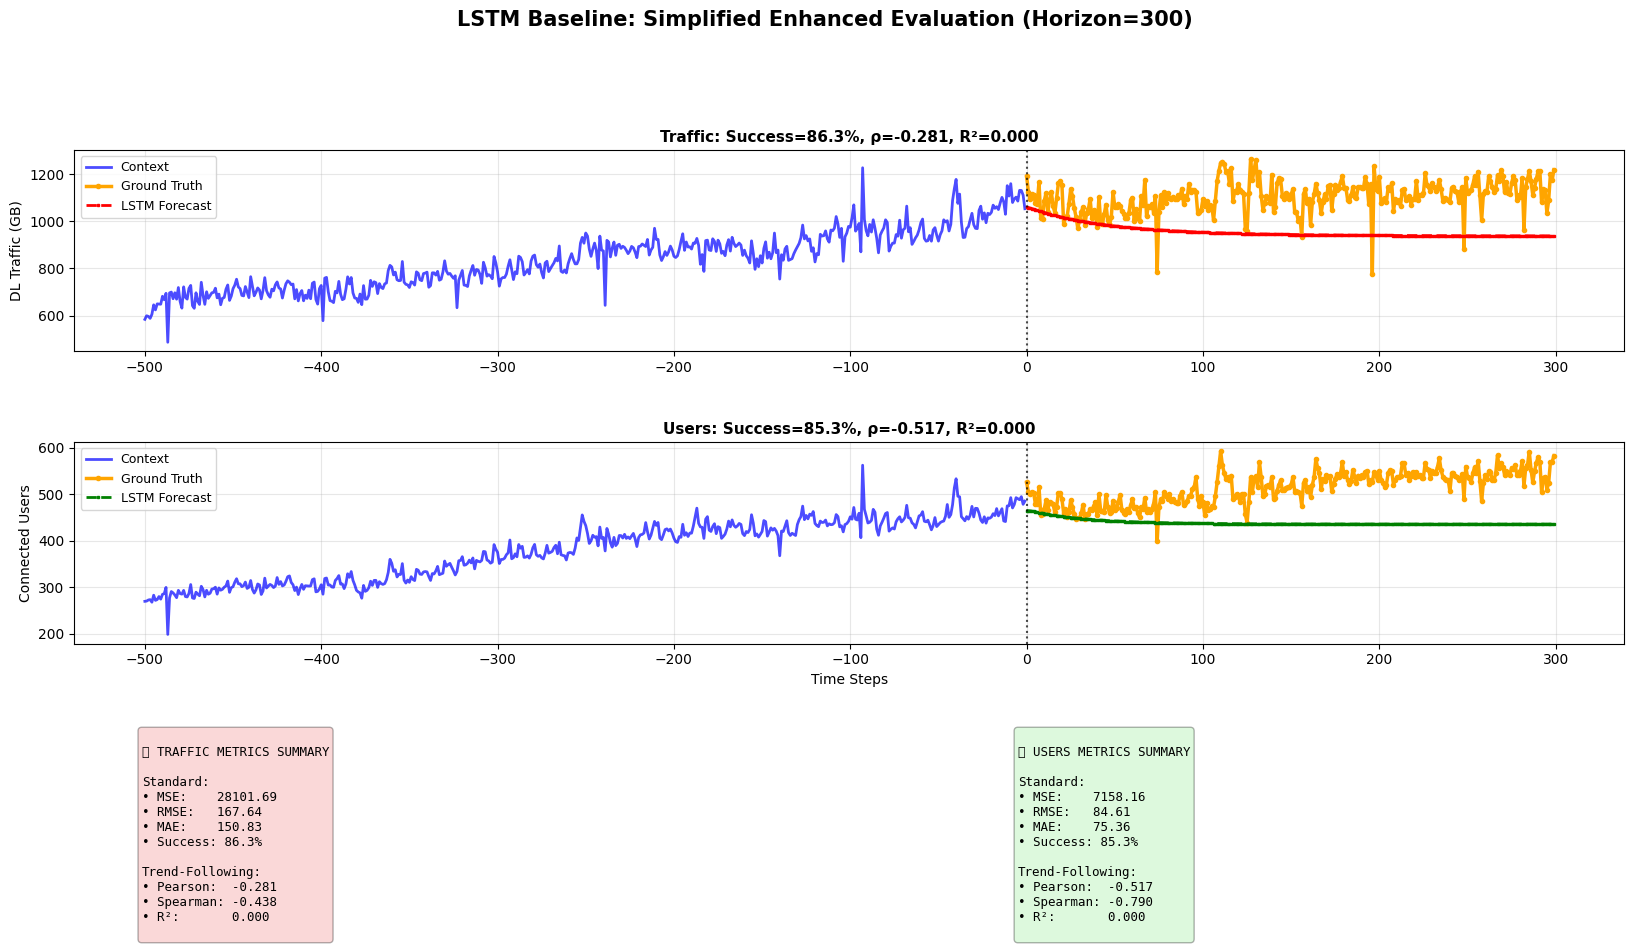


💾 Results saved to: baseline_lstm_pred300_simplified_enhanced_results.png
💾 Simplified enhanced metrics saved to: baseline_lstm_simplified_enhanced_metrics.csv


In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr
import warnings
import random
warnings.filterwarnings('ignore')

# ============================================================================
# ⚙️ EXPERIMENT CONFIGURATION - MODIFY HERE FOR EXPERIMENTS
# ============================================================================
CONFIG = {
    # Forecasting Parameters (Common across all methods)
    'PRED_LEN': 300,              # Forecast horizon
    'MIN_CONTEXT_LEN': 600,       # Minimum required training samples
    'CONTEXT_PLOT_LEN': 500,      # Context length shown in plots
    
    # Data Source (Common)
    'DATA_PATH': './long_term_tsf/dataset/Telecom/Site_1.csv',
    'TRAFFIC_COL': 'dl_traffic_volume_gb',
    'USERS_COL': 'connected_users',
    
    # LSTM-Specific Hyperparameters
    'WINDOW_SIZE': 50,            # Lookback window (30-100)
    'HIDDEN_DIM': 50,             # Hidden layer size (32-128)
    'NUM_LAYERS': 2,              # LSTM layers (1-3)
    'DROPOUT': 0.2,               # Dropout rate (0.0-0.5)
    'BATCH_SIZE': 32,             # Training batch size (16-64)
    'LEARNING_RATE': 0.001,       # Learning rate (0.0001-0.01)
    'MAX_EPOCHS': 50,             # Maximum training epochs
    'EARLY_STOP': 10,             # Early stopping patience
    'VAL_SPLIT': 0.2,             # Validation split ratio
    
    # Model Configuration
    'DEVICE': 'cpu',              # 'cpu' or 'cuda'
    'RANDOM_SEED': 42,            # Reproducibility seed
    
    # Output Settings (Common)
    'SAVE_PLOT': True,
    'PLOT_DPI': 300,
    'OUTPUT_PREFIX': 'baseline_lstm'
}

# ============================================================================
# LSTM BASELINE - SIMPLIFIED ENHANCED METRICS
# ============================================================================

def initialize_seeds(seed=42):
    """Ensure reproducibility across runs"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def cal_metrics_simplified(y, forecast):
    """
    Calculate simplified comprehensive metrics:
    - Standard: MSE, MAE, RMSE, Success Rate
    - Trend-Following: Pearson, Spearman, R²
    """
    # ============================================
    # STANDARD METRICS
    # ============================================
    mse = mean_squared_error(y, forecast)
    mae = mean_absolute_error(y, forecast)
    rmse = np.sqrt(mse)
    
    # WMAPE-based success rate
    wmape = np.sum(np.abs(y - forecast)) / (np.sum(np.abs(y)) + 1e-8) * 100
    success = max(0, min(1, (100 - wmape) / 100))
    
    # ============================================
    # TREND-FOLLOWING METRICS
    # ============================================
    
    # Correlation Coefficients
    try:
        pearson_corr, _ = pearsonr(y, forecast)
        spearman_corr, _ = spearmanr(y, forecast)
    except:
        pearson_corr = 0.0
        spearman_corr = 0.0
    
    # R² (Coefficient of Determination)
    r_squared = pearson_corr ** 2 if pearson_corr > 0 else 0.0
    
    return {
        # Standard
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'success_rate': success * 100,
        # Trend-Following
        'pearson_correlation': pearson_corr,
        'spearman_correlation': spearman_corr,
        'r_squared': r_squared
    }

# ============================================================================
# LSTM Architecture
# ============================================================================
class RecurrentForecaster(nn.Module):
    def __init__(self, feat_dim=1, hidden_dim=50, n_layers=2, out_dim=1, drop_rate=0.2):
        super(RecurrentForecaster, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        if n_layers > 1:
            self.recurrent = nn.LSTM(feat_dim, hidden_dim, n_layers, 
                                     batch_first=True, dropout=drop_rate)
        else:
            self.recurrent = nn.LSTM(feat_dim, hidden_dim, n_layers, 
                                     batch_first=True)
        
        self.output_layer = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        h_init = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(inputs.device)
        c_init = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(inputs.device)
        
        lstm_out, _ = self.recurrent(inputs, (h_init, c_init))
        predictions = self.output_layer(lstm_out[:, -1, :])
        return predictions

# ============================================================================
# Custom Dataset
# ============================================================================
class SequenceDataset(Dataset):
    def __init__(self, time_series, window_size=50):
        self.series = time_series
        self.window = window_size
        
    def __len__(self):
        return len(self.series) - self.window
    
    def __getitem__(self, idx):
        input_seq = self.series[idx:idx + self.window]
        target_val = self.series[idx + self.window]
        return torch.FloatTensor(input_seq).unsqueeze(-1), torch.FloatTensor([target_val])

# ============================================================================
# Training Loop with Validation
# ============================================================================
def train_recurrent_model(model, train_data, val_data, loss_fn, opt, 
                          n_epochs=50, device='cpu', early_stop=10):
    """Train with early stopping based on validation loss"""
    best_loss = float('inf')
    no_improve = 0
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_data:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            opt.zero_grad()
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            opt.step()
            
            train_loss += loss.item()
        
        avg_train = train_loss / len(train_data)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_data:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(X_batch)
                val_loss += loss_fn(pred, y_batch).item()
        
        avg_val = val_loss / len(val_data)
        
        # Early stopping logic
        if avg_val < best_loss:
            best_loss = avg_val
            no_improve = 0
        else:
            no_improve += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"   Epoch [{epoch+1}/{n_epochs}], Train: {avg_train:.6f}, Val: {avg_val:.6f}")
        
        if no_improve >= early_stop:
            print(f"   Early stop at epoch {epoch+1}")
            break
    
    return model

# ============================================================================
# Multi-step Forecasting
# ============================================================================
def generate_multistep_forecast(model, init_seq, normalizer, horizon, device='cpu'):
    """Iterative multi-step ahead forecasting"""
    model.eval()
    predictions = []
    
    current_window = init_seq.copy()
    
    with torch.no_grad():
        for _ in range(horizon):
            input_tensor = torch.FloatTensor(current_window).unsqueeze(0).unsqueeze(-1).to(device)
            next_val = model(input_tensor).cpu().numpy()[0, 0]
            predictions.append(next_val)
            
            # Slide window
            current_window = np.append(current_window[1:], next_val)
    
    # Denormalize
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_denorm = normalizer.inverse_transform(pred_array).flatten()
    
    return pred_denorm

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("⚙️  EXPERIMENT CONFIGURATION")
print("=" * 80)
print(f"Forecast Horizon: {CONFIG['PRED_LEN']} steps")
print(f"LSTM Hyperparameters:")
print(f"  Window Size: {CONFIG['WINDOW_SIZE']}")
print(f"  Hidden Dim: {CONFIG['HIDDEN_DIM']}")
print(f"  Num Layers: {CONFIG['NUM_LAYERS']}")
print(f"  Dropout: {CONFIG['DROPOUT']}")
print(f"  Batch Size: {CONFIG['BATCH_SIZE']}")
print(f"  Learning Rate: {CONFIG['LEARNING_RATE']}")
print(f"  Max Epochs: {CONFIG['MAX_EPOCHS']}")
print(f"  Early Stop: {CONFIG['EARLY_STOP']}")
print(f"Device: {CONFIG['DEVICE']}")
print(f"Data: {CONFIG['DATA_PATH']}")
print("=" * 80)

# Initialize seeds
initialize_seeds(CONFIG['RANDOM_SEED'])

# Load dataset
try:
    df = pd.read_csv(CONFIG['DATA_PATH'])
except FileNotFoundError:
    print(f"❌ Error: Dataset file not found at {CONFIG['DATA_PATH']}")
    exit(1)

PRED_LEN = CONFIG['PRED_LEN']
TRAIN_SIZE = len(df) - PRED_LEN
WINDOW_SIZE = CONFIG['WINDOW_SIZE']
VAL_SPLIT = CONFIG['VAL_SPLIT']
DEVICE = CONFIG['DEVICE']

# Validate data
if TRAIN_SIZE <= 0:
    print(f"❌ Error: PRED_LEN ({PRED_LEN}) exceeds dataset length ({len(df)})")
    exit(1)

if TRAIN_SIZE < CONFIG['MIN_CONTEXT_LEN']:
    print(f"⚠️  Warning: Train size ({TRAIN_SIZE}) < minimum ({CONFIG['MIN_CONTEXT_LEN']})")
    print(f"   This may lead to poor model performance!")

traffic_data = df[CONFIG['TRAFFIC_COL']].values
users_data = df[CONFIG['USERS_COL']].values

# Check for NaN/inf values
if np.any(np.isnan(traffic_data)) or np.any(np.isinf(traffic_data)):
    print("❌ Error: Traffic data contains NaN or Inf values")
    exit(1)

if np.any(np.isnan(users_data)) or np.any(np.isinf(users_data)):
    print("❌ Error: Users data contains NaN or Inf values")
    exit(1)

print("\n" + "=" * 80)
print("📊 LSTM BASELINE - SIMPLIFIED ENHANCED METRICS")
print("=" * 80)
print(f"Device: {DEVICE}")
print(f"Training samples: {TRAIN_SIZE}")
print(f"Forecast horizon: {PRED_LEN}")
print(f"Window size: {WINDOW_SIZE}")

# ============================================================================
# LSTM for Traffic
# ============================================================================
print("\n🔴 Training LSTM for Traffic...")

# Normalize training data only
traffic_scaler = MinMaxScaler()
traffic_norm = traffic_scaler.fit_transform(traffic_data[:TRAIN_SIZE].reshape(-1, 1)).flatten()

# Train/validation split
val_count = int(len(traffic_norm) * VAL_SPLIT)
traffic_train = traffic_norm[:-val_count]
traffic_val = traffic_norm[-val_count:]

# Create data loaders
train_ds = SequenceDataset(traffic_train, window_size=WINDOW_SIZE)
val_ds = SequenceDataset(traffic_val, window_size=WINDOW_SIZE)
train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)

# Initialize model
traffic_model = RecurrentForecaster(
    feat_dim=1, 
    hidden_dim=CONFIG['HIDDEN_DIM'], 
    n_layers=CONFIG['NUM_LAYERS'], 
    drop_rate=CONFIG['DROPOUT']
).to(DEVICE)

loss_function = nn.MSELoss()
optimizer = optim.Adam(traffic_model.parameters(), lr=CONFIG['LEARNING_RATE'])

# Train
traffic_model = train_recurrent_model(
    traffic_model, train_loader, val_loader, 
    loss_function, optimizer, 
    n_epochs=CONFIG['MAX_EPOCHS'], 
    device=DEVICE, 
    early_stop=CONFIG['EARLY_STOP']
)

# Forecast
init_window = traffic_norm[-WINDOW_SIZE:]
traffic_forecast = generate_multistep_forecast(
    traffic_model, init_window, 
    traffic_scaler, PRED_LEN, 
    device=DEVICE
)

# Evaluate
traffic_actual = traffic_data[TRAIN_SIZE:TRAIN_SIZE + PRED_LEN]
traffic_metrics = cal_metrics_simplified(traffic_actual, traffic_forecast)

print(f"\n✅ LSTM Traffic Results:")
print(f"  Standard Metrics:")
print(f"    MSE:  {traffic_metrics['mse']:.4f}")
print(f"    MAE:  {traffic_metrics['mae']:.4f}")
print(f"    RMSE: {traffic_metrics['rmse']:.4f}")
print(f"    ✅ Success Rate: {traffic_metrics['success_rate']:.2f}%")
print(f"  Trend-Following Metrics:")
print(f"    🔗 Pearson Correlation: {traffic_metrics['pearson_correlation']:.4f}")
print(f"    📊 Spearman Correlation: {traffic_metrics['spearman_correlation']:.4f}")
print(f"    🎲 R²: {traffic_metrics['r_squared']:.4f}")

# ============================================================================
# LSTM for Users
# ============================================================================
print("\n🟢 Training LSTM for Users...")

users_scaler = MinMaxScaler()
users_norm = users_scaler.fit_transform(users_data[:TRAIN_SIZE].reshape(-1, 1)).flatten()

users_train = users_norm[:-val_count]
users_val = users_norm[-val_count:]

train_ds_users = SequenceDataset(users_train, window_size=WINDOW_SIZE)
val_ds_users = SequenceDataset(users_val, window_size=WINDOW_SIZE)
train_loader_users = DataLoader(train_ds_users, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
val_loader_users = DataLoader(val_ds_users, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)

users_model = RecurrentForecaster(
    feat_dim=1, 
    hidden_dim=CONFIG['HIDDEN_DIM'], 
    n_layers=CONFIG['NUM_LAYERS'], 
    drop_rate=CONFIG['DROPOUT']
).to(DEVICE)

optimizer_users = optim.Adam(users_model.parameters(), lr=CONFIG['LEARNING_RATE'])

users_model = train_recurrent_model(
    users_model, train_loader_users, val_loader_users, 
    loss_function, optimizer_users, 
    n_epochs=CONFIG['MAX_EPOCHS'], 
    device=DEVICE, 
    early_stop=CONFIG['EARLY_STOP']
)

init_window_users = users_norm[-WINDOW_SIZE:]
users_forecast = generate_multistep_forecast(
    users_model, init_window_users, 
    users_scaler, PRED_LEN, 
    device=DEVICE
)

users_actual = users_data[TRAIN_SIZE:TRAIN_SIZE + PRED_LEN]
users_metrics = cal_metrics_simplified(users_actual, users_forecast)

print(f"\n✅ LSTM Users Results:")
print(f"  Standard Metrics:")
print(f"    MSE:  {users_metrics['mse']:.4f}")
print(f"    MAE:  {users_metrics['mae']:.4f}")
print(f"    RMSE: {users_metrics['rmse']:.4f}")
print(f"    ✅ Success Rate: {users_metrics['success_rate']:.2f}%")
print(f"  Trend-Following Metrics:")
print(f"    🔗 Pearson Correlation: {users_metrics['pearson_correlation']:.4f}")
print(f"    📊 Spearman Correlation: {users_metrics['spearman_correlation']:.4f}")
print(f"    🎲 R²: {users_metrics['r_squared']:.4f}")

# Overall summary
avg_success = (traffic_metrics['success_rate'] + users_metrics['success_rate']) / 2
avg_corr = (traffic_metrics['pearson_correlation'] + users_metrics['pearson_correlation']) / 2
avg_r2 = (traffic_metrics['r_squared'] + users_metrics['r_squared']) / 2

print(f"\n🎯 Overall LSTM Performance:")
print(f"  Average Success Rate: {avg_success:.2f}%")
print(f"  Average Pearson Correlation: {avg_corr:.4f}")
print(f"  Average R²: {avg_r2:.4f}")

# ============================================================================
# ENHANCED VISUALIZATION
# ============================================================================
if CONFIG['SAVE_PLOT']:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 2, hspace=0.45, wspace=0.3)
    
    context_view = min(CONFIG['CONTEXT_PLOT_LEN'], TRAIN_SIZE)
    time_x = range(-context_view, 0)
    time_y = range(0, PRED_LEN)
    
    # Traffic forecast
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time_x, traffic_data[TRAIN_SIZE-context_view:TRAIN_SIZE], 'b-', linewidth=2, label='Context', alpha=0.7)
    ax1.plot(time_y, traffic_actual, 'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax1.plot(time_y, traffic_forecast, 'r--', linewidth=2, label='LSTM Forecast', marker='s', markersize=2)
    ax1.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax1.set_title(f'Traffic: Success={traffic_metrics["success_rate"]:.1f}%, ρ={traffic_metrics["pearson_correlation"]:.3f}, R²={traffic_metrics["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax1.set_ylabel('DL Traffic (GB)', fontsize=10)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Users forecast
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(time_x, users_data[TRAIN_SIZE-context_view:TRAIN_SIZE], 'b-', linewidth=2, label='Context', alpha=0.7)
    ax2.plot(time_y, users_actual, 'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax2.plot(time_y, users_forecast, 'g--', linewidth=2, label='LSTM Forecast', marker='s', markersize=2)
    ax2.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax2.set_title(f'Users: Success={users_metrics["success_rate"]:.1f}%, ρ={users_metrics["pearson_correlation"]:.3f}, R²={users_metrics["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax2.set_xlabel('Time Steps', fontsize=10)
    ax2.set_ylabel('Connected Users', fontsize=10)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(alpha=0.3)
    
    # Metrics Summary (Traffic)
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.axis('off')
    traffic_text = f"""
🔴 TRAFFIC METRICS SUMMARY

Standard:
• MSE:    {traffic_metrics['mse']:.2f}
• RMSE:   {traffic_metrics['rmse']:.2f}
• MAE:    {traffic_metrics['mae']:.2f}
• Success: {traffic_metrics['success_rate']:.1f}%

Trend-Following:
• Pearson:  {traffic_metrics['pearson_correlation']:.3f}
• Spearman: {traffic_metrics['spearman_correlation']:.3f}
• R²:       {traffic_metrics['r_squared']:.3f}
"""
    ax3.text(0.1, 0.5, traffic_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
    
    # Metrics Summary (Users)
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.axis('off')
    users_text = f"""
🟢 USERS METRICS SUMMARY

Standard:
• MSE:    {users_metrics['mse']:.2f}
• RMSE:   {users_metrics['rmse']:.2f}
• MAE:    {users_metrics['mae']:.2f}
• Success: {users_metrics['success_rate']:.1f}%

Trend-Following:
• Pearson:  {users_metrics['pearson_correlation']:.3f}
• Spearman: {users_metrics['spearman_correlation']:.3f}
• R²:       {users_metrics['r_squared']:.3f}
"""
    ax4.text(0.1, 0.5, users_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    plt.suptitle(f'LSTM Baseline: Simplified Enhanced Evaluation (Horizon={PRED_LEN})', 
                 fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    output_file = f"{CONFIG['OUTPUT_PREFIX']}_pred{PRED_LEN}_simplified_enhanced_results.png"
    plt.savefig(output_file, dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Results saved to: {output_file}")
else:
    print("\n⚠️  Plot saving disabled in configuration")

# ============================================================================
# SAVE SIMPLIFIED ENHANCED METRICS
# ============================================================================
results_df = pd.DataFrame({
    'Method': ['LSTM'],
    'Pred_Len': [PRED_LEN],
    'Lookback': [WINDOW_SIZE],
    'Hidden_Size': [CONFIG['HIDDEN_DIM']],
    'Num_Layers': [CONFIG['NUM_LAYERS']],
    'Dropout': [CONFIG['DROPOUT']],
    'Batch_Size': [CONFIG['BATCH_SIZE']],
    'Learning_Rate': [CONFIG['LEARNING_RATE']],
    # Traffic - Standard
    'Traffic_MSE': [traffic_metrics['mse']],
    'Traffic_MAE': [traffic_metrics['mae']],
    'Traffic_RMSE': [traffic_metrics['rmse']],
    'Traffic_Success_%': [traffic_metrics['success_rate']],
    # Traffic - Trend-Following
    'Traffic_Pearson': [traffic_metrics['pearson_correlation']],
    'Traffic_Spearman': [traffic_metrics['spearman_correlation']],
    'Traffic_R2': [traffic_metrics['r_squared']],
    # Users - Standard
    'Users_MSE': [users_metrics['mse']],
    'Users_MAE': [users_metrics['mae']],
    'Users_RMSE': [users_metrics['rmse']],
    'Users_Success_%': [users_metrics['success_rate']],
    # Users - Trend-Following
    'Users_Pearson': [users_metrics['pearson_correlation']],
    'Users_Spearman': [users_metrics['spearman_correlation']],
    'Users_R2': [users_metrics['r_squared']],
    # Overall
    'Avg_Success_%': [avg_success],
    'Avg_Correlation': [avg_corr],
    'Avg_R2': [avg_r2]
})

output_csv = f"{CONFIG['OUTPUT_PREFIX']}_simplified_enhanced_metrics.csv"
results_df.to_csv(output_csv, index=False)
print(f"💾 Simplified enhanced metrics saved to: {output_csv}")
print("=" * 80)

## BASELINE 3: VAR

⚙️  EXPERIMENT CONFIGURATION
Forecast Horizon: 300 steps
VAR Hyperparameters:
  Max Lags: 20
  Lag Selection: AIC
  Trend: c
Data: ./long_term_tsf/dataset/Telecom/Site_1.csv

📊 VAR BASELINE - SIMPLIFIED ENHANCED METRICS
Context Length: 718
Forecast Length: 300

Training data shape: (718, 2)

🔧 Fitting VAR model...
   Searching optimal lag (max=20, criterion=AIC)...
   ✅ Optimal lag order (AIC): 18

   📊 Lag Selection Criteria:
      AIC:  18
      BIC:  7
      HQIC: 7
      FPE:  18
   ✅ Model fitted successfully

📊 Model Summary:
   Number of observations: 700
   Lag order: 18
   Trend: c
   Log-Likelihood: -5951.66
   AIC: 11.54
   BIC: 12.02
   HQIC: 11.73
   FPE: 102807.04

🔮 Generating 300-step forecast...

✅ VAR Traffic Results:
  Standard Metrics:
    MSE:  13644.7331
    MAE:  96.5168
    RMSE: 116.8107
    ✅ Success Rate: 91.26%
  Trend-Following Metrics:
    🔗 Pearson Correlation: 0.3679
    📊 Spearman Correlation: 0.4424
    🎲 R²: 0.1354

✅ VAR Users Results:
  Standard Met

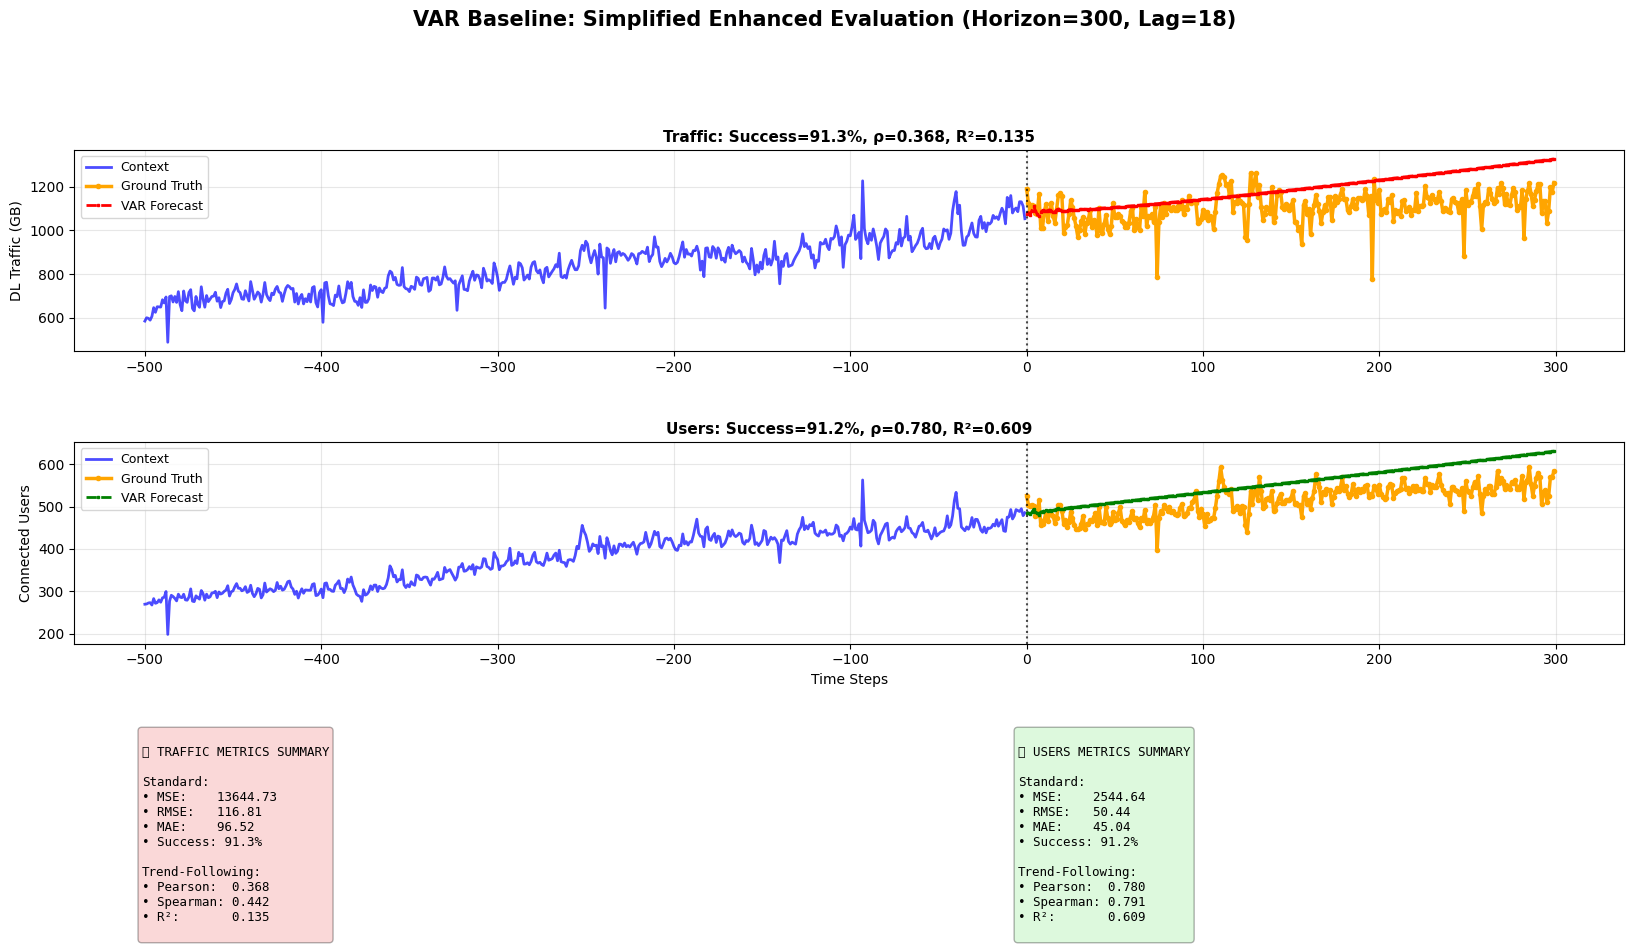


💾 Results saved to: baseline_var_pred300_simplified_enhanced_results.png
💾 Simplified enhanced metrics saved to: baseline_var_simplified_enhanced_metrics.csv


In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ⚙️ EXPERIMENT CONFIGURATION - MODIFY HERE FOR EXPERIMENTS
# ============================================================================
CONFIG = {
    # Forecasting Parameters (Common across all methods)
    'PRED_LEN': 300,              # Forecast horizon
    'MIN_CONTEXT_LEN': 600,       # Minimum required training samples
    'CONTEXT_PLOT_LEN': 500,      # Context length shown in plots
    
    # Data Source (Common)
    'DATA_PATH': './long_term_tsf/dataset/Telecom/Site_1.csv',
    'TRAFFIC_COL': 'dl_traffic_volume_gb',
    'USERS_COL': 'connected_users',
    
    # VAR-Specific Hyperparameters
    'MAX_LAGS': 20,               # Maximum lag order to consider (5-50)
    'LAG_SELECTION': 'aic',       # Criterion for lag selection ('aic', 'bic', 'hqic', 'fpe')
    'TREND': 'c',                 # Trend parameter ('c'=constant, 'ct'=constant+trend, 'ctt'=constant+linear+quadratic, 'n'=no trend)
    
    # Model Configuration
    'VERBOSE': True,              # Print detailed model info
    
    # Output Settings (Common)
    'SAVE_PLOT': True,
    'PLOT_DPI': 300,
    'OUTPUT_PREFIX': 'baseline_var'
}

# ============================================================================
# VAR BASELINE - SIMPLIFIED ENHANCED METRICS
# ============================================================================

def cal_metrics_simplified(y, forecast):
    """
    Calculate simplified comprehensive metrics:
    - Standard: MSE, MAE, RMSE, Success Rate
    - Trend-Following: Pearson, Spearman, R²
    """
    # ============================================
    # STANDARD METRICS
    # ============================================
    mse = mean_squared_error(y, forecast)
    mae = mean_absolute_error(y, forecast)
    rmse = np.sqrt(mse)
    
    # WMAPE-based success rate
    wmape = np.sum(np.abs(y - forecast)) / (np.sum(np.abs(y)) + 1e-8) * 100
    success = max(0, min(1, (100 - wmape) / 100))
    
    # ============================================
    # TREND-FOLLOWING METRICS
    # ============================================
    
    # Correlation Coefficients
    try:
        pearson_corr, _ = pearsonr(y, forecast)
        spearman_corr, _ = spearmanr(y, forecast)
    except:
        pearson_corr = 0.0
        spearman_corr = 0.0
    
    # R² (Coefficient of Determination)
    r_squared = pearson_corr ** 2 if pearson_corr > 0 else 0.0
    
    return {
        # Standard
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'success_rate': success * 100,
        # Trend-Following
        'pearson_correlation': pearson_corr,
        'spearman_correlation': spearman_corr,
        'r_squared': r_squared
    }

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("⚙️  EXPERIMENT CONFIGURATION")
print("=" * 80)
print(f"Forecast Horizon: {CONFIG['PRED_LEN']} steps")
print(f"VAR Hyperparameters:")
print(f"  Max Lags: {CONFIG['MAX_LAGS']}")
print(f"  Lag Selection: {CONFIG['LAG_SELECTION'].upper()}")
print(f"  Trend: {CONFIG['TREND']}")
print(f"Data: {CONFIG['DATA_PATH']}")
print("=" * 80)

# Load data
try:
    df = pd.read_csv(CONFIG['DATA_PATH'])
except FileNotFoundError:
    print(f"❌ Error: Dataset file not found at {CONFIG['DATA_PATH']}")
    exit(1)

PRED_LEN = CONFIG['PRED_LEN']
CONTEXT_LEN = len(df) - PRED_LEN

# Validate data
if CONTEXT_LEN <= 0:
    print(f"❌ Error: PRED_LEN ({PRED_LEN}) exceeds dataset length ({len(df)})")
    exit(1)

if CONTEXT_LEN < CONFIG['MIN_CONTEXT_LEN']:
    print(f"⚠️  Warning: Context length ({CONTEXT_LEN}) < minimum ({CONFIG['MIN_CONTEXT_LEN']})")
    print(f"   This may lead to poor model performance!")

data_traffic = df[CONFIG['TRAFFIC_COL']].values
data_users = df[CONFIG['USERS_COL']].values

# Check for NaN/inf values
if np.any(np.isnan(data_traffic)) or np.any(np.isinf(data_traffic)):
    print("❌ Error: Traffic data contains NaN or Inf values")
    exit(1)

if np.any(np.isnan(data_users)) or np.any(np.isinf(data_users)):
    print("❌ Error: Users data contains NaN or Inf values")
    exit(1)

print("\n" + "=" * 80)
print("📊 VAR BASELINE - SIMPLIFIED ENHANCED METRICS")
print("=" * 80)
print(f"Context Length: {CONTEXT_LEN}")
print(f"Forecast Length: {PRED_LEN}")

# ============================================================================
# Prepare bivariate data
# ============================================================================
train_data = np.column_stack([
    data_traffic[:CONTEXT_LEN],
    data_users[:CONTEXT_LEN]
])

test_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
test_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

print(f"\nTraining data shape: {train_data.shape}")

# ============================================================================
# Fit VAR model
# ============================================================================
print("\n🔧 Fitting VAR model...")

try:
    # Create VAR model
    model = VAR(train_data)
    
    # Select optimal lag order
    print(f"   Searching optimal lag (max={CONFIG['MAX_LAGS']}, criterion={CONFIG['LAG_SELECTION'].upper()})...")
    results = model.select_order(maxlags=CONFIG['MAX_LAGS'])
    
    # Get optimal lag based on selected criterion
    lag_selection_map = {
        'aic': results.aic,
        'bic': results.bic,
        'hqic': results.hqic,
        'fpe': results.fpe
    }
    optimal_lag = lag_selection_map[CONFIG['LAG_SELECTION']]
    
    print(f"   ✅ Optimal lag order ({CONFIG['LAG_SELECTION'].upper()}): {optimal_lag}")
    
    # Print all criteria if verbose
    if CONFIG['VERBOSE']:
        print(f"\n   📊 Lag Selection Criteria:")
        print(f"      AIC:  {results.aic}")
        print(f"      BIC:  {results.bic}")
        print(f"      HQIC: {results.hqic}")
        print(f"      FPE:  {results.fpe}")
    
    # Fit model with optimal lag
    fitted_model = model.fit(maxlags=optimal_lag, trend=CONFIG['TREND'])
    
    print(f"   ✅ Model fitted successfully")
    
    if CONFIG['VERBOSE']:
        print(f"\n📊 Model Summary:")
        print(f"   Number of observations: {fitted_model.nobs}")
        print(f"   Lag order: {fitted_model.k_ar}")
        print(f"   Trend: {CONFIG['TREND']}")
        print(f"   Log-Likelihood: {fitted_model.llf:.2f}")
        print(f"   AIC: {fitted_model.aic:.2f}")
        print(f"   BIC: {fitted_model.bic:.2f}")
        print(f"   HQIC: {fitted_model.hqic:.2f}")
        print(f"   FPE: {fitted_model.fpe:.2f}")
    
    # ========================================================================
    # Forecast
    # ========================================================================
    print(f"\n🔮 Generating {PRED_LEN}-step forecast...")
    
    forecast = fitted_model.forecast(train_data[-optimal_lag:], steps=PRED_LEN)
    
    forecast_traffic = forecast[:, 0]
    forecast_users = forecast[:, 1]
    
    # ========================================================================
    # Calculate SIMPLIFIED ENHANCED metrics
    # ========================================================================
    metrics_traffic = cal_metrics_simplified(test_traffic, forecast_traffic)
    metrics_users = cal_metrics_simplified(test_users, forecast_users)
    
    # ========================================================================
    # Print comprehensive results
    # ========================================================================
    print(f"\n✅ VAR Traffic Results:")
    print(f"  Standard Metrics:")
    print(f"    MSE:  {metrics_traffic['mse']:.4f}")
    print(f"    MAE:  {metrics_traffic['mae']:.4f}")
    print(f"    RMSE: {metrics_traffic['rmse']:.4f}")
    print(f"    ✅ Success Rate: {metrics_traffic['success_rate']:.2f}%")
    print(f"  Trend-Following Metrics:")
    print(f"    🔗 Pearson Correlation: {metrics_traffic['pearson_correlation']:.4f}")
    print(f"    📊 Spearman Correlation: {metrics_traffic['spearman_correlation']:.4f}")
    print(f"    🎲 R²: {metrics_traffic['r_squared']:.4f}")
    
    print(f"\n✅ VAR Users Results:")
    print(f"  Standard Metrics:")
    print(f"    MSE:  {metrics_users['mse']:.4f}")
    print(f"    MAE:  {metrics_users['mae']:.4f}")
    print(f"    RMSE: {metrics_users['rmse']:.4f}")
    print(f"    ✅ Success Rate: {metrics_users['success_rate']:.2f}%")
    print(f"  Trend-Following Metrics:")
    print(f"    🔗 Pearson Correlation: {metrics_users['pearson_correlation']:.4f}")
    print(f"    📊 Spearman Correlation: {metrics_users['spearman_correlation']:.4f}")
    print(f"    🎲 R²: {metrics_users['r_squared']:.4f}")
    
    # Overall performance
    avg_success = (metrics_traffic['success_rate'] + metrics_users['success_rate']) / 2
    avg_corr = (metrics_traffic['pearson_correlation'] + metrics_users['pearson_correlation']) / 2
    avg_r2 = (metrics_traffic['r_squared'] + metrics_users['r_squared']) / 2
    
    print(f"\n🎯 Overall VAR Performance:")
    print(f"  Average Success Rate: {avg_success:.2f}%")
    print(f"  Average Pearson Correlation: {avg_corr:.4f}")
    print(f"  Average R²: {avg_r2:.4f}")
    
    var_success = True
    
except Exception as e:
    print(f"\n❌ VAR model failed: {str(e)}")
    forecast_traffic = np.zeros(PRED_LEN)
    forecast_users = np.zeros(PRED_LEN)
    metrics_traffic = {
        'mse': 0, 'mae': 0, 'rmse': 0, 'success_rate': 0,
        'pearson_correlation': 0, 'spearman_correlation': 0, 'r_squared': 0
    }
    metrics_users = {
        'mse': 0, 'mae': 0, 'rmse': 0, 'success_rate': 0,
        'pearson_correlation': 0, 'spearman_correlation': 0, 'r_squared': 0
    }
    avg_success = 0
    avg_corr = 0
    avg_r2 = 0
    var_success = False
    optimal_lag = 0

# ============================================================================
# ENHANCED VISUALIZATION
# ============================================================================
if var_success and CONFIG['SAVE_PLOT']:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 2, hspace=0.45, wspace=0.3)
    
    context_plot = min(CONFIG['CONTEXT_PLOT_LEN'], CONTEXT_LEN)
    time_x = range(-context_plot, 0)
    time_y = range(0, PRED_LEN)
    
    # Traffic forecast
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time_x, data_traffic[CONTEXT_LEN-context_plot:CONTEXT_LEN], 
             'b-', linewidth=2, label='Context', alpha=0.7)
    ax1.plot(time_y, test_traffic, 
             'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax1.plot(time_y, forecast_traffic, 
             'r--', linewidth=2, label='VAR Forecast', marker='s', markersize=2)
    ax1.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax1.set_title(f'Traffic: Success={metrics_traffic["success_rate"]:.1f}%, ρ={metrics_traffic["pearson_correlation"]:.3f}, R²={metrics_traffic["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax1.set_ylabel('DL Traffic (GB)', fontsize=10)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Users forecast
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(time_x, data_users[CONTEXT_LEN-context_plot:CONTEXT_LEN], 
             'b-', linewidth=2, label='Context', alpha=0.7)
    ax2.plot(time_y, test_users, 
             'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax2.plot(time_y, forecast_users, 
             'g--', linewidth=2, label='VAR Forecast', marker='s', markersize=2)
    ax2.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax2.set_title(f'Users: Success={metrics_users["success_rate"]:.1f}%, ρ={metrics_users["pearson_correlation"]:.3f}, R²={metrics_users["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax2.set_xlabel('Time Steps', fontsize=10)
    ax2.set_ylabel('Connected Users', fontsize=10)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(alpha=0.3)
    
    # Metrics Summary (Traffic)
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.axis('off')
    traffic_text = f"""
🔴 TRAFFIC METRICS SUMMARY

Standard:
• MSE:    {metrics_traffic['mse']:.2f}
• RMSE:   {metrics_traffic['rmse']:.2f}
• MAE:    {metrics_traffic['mae']:.2f}
• Success: {metrics_traffic['success_rate']:.1f}%

Trend-Following:
• Pearson:  {metrics_traffic['pearson_correlation']:.3f}
• Spearman: {metrics_traffic['spearman_correlation']:.3f}
• R²:       {metrics_traffic['r_squared']:.3f}
"""
    ax3.text(0.1, 0.5, traffic_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
    
    # Metrics Summary (Users)
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.axis('off')
    users_text = f"""
🟢 USERS METRICS SUMMARY

Standard:
• MSE:    {metrics_users['mse']:.2f}
• RMSE:   {metrics_users['rmse']:.2f}
• MAE:    {metrics_users['mae']:.2f}
• Success: {metrics_users['success_rate']:.1f}%

Trend-Following:
• Pearson:  {metrics_users['pearson_correlation']:.3f}
• Spearman: {metrics_users['spearman_correlation']:.3f}
• R²:       {metrics_users['r_squared']:.3f}
"""
    ax4.text(0.1, 0.5, users_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    plt.suptitle(f'VAR Baseline: Simplified Enhanced Evaluation (Horizon={PRED_LEN}, Lag={optimal_lag})', 
                 fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    output_file = f"{CONFIG['OUTPUT_PREFIX']}_pred{PRED_LEN}_simplified_enhanced_results.png"
    plt.savefig(output_file, dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Results saved to: {output_file}")
    
    # ========================================================================
    # SAVE SIMPLIFIED ENHANCED RESULTS
    # ========================================================================
    results_df = pd.DataFrame({
        'Method': ['VAR'],
        'Pred_Len': [PRED_LEN],
        'Optimal_Lag': [optimal_lag],
        'Max_Lags_Searched': [CONFIG['MAX_LAGS']],
        'Lag_Criterion': [CONFIG['LAG_SELECTION'].upper()],
        'Trend': [CONFIG['TREND']],
        # Traffic - Standard
        'Traffic_MSE': [metrics_traffic['mse']],
        'Traffic_MAE': [metrics_traffic['mae']],
        'Traffic_RMSE': [metrics_traffic['rmse']],
        'Traffic_Success_%': [metrics_traffic['success_rate']],
        # Traffic - Trend-Following
        'Traffic_Pearson': [metrics_traffic['pearson_correlation']],
        'Traffic_Spearman': [metrics_traffic['spearman_correlation']],
        'Traffic_R2': [metrics_traffic['r_squared']],
        # Users - Standard
        'Users_MSE': [metrics_users['mse']],
        'Users_MAE': [metrics_users['mae']],
        'Users_RMSE': [metrics_users['rmse']],
        'Users_Success_%': [metrics_users['success_rate']],
        # Users - Trend-Following
        'Users_Pearson': [metrics_users['pearson_correlation']],
        'Users_Spearman': [metrics_users['spearman_correlation']],
        'Users_R2': [metrics_users['r_squared']],
        # Overall
        'Avg_Success_%': [avg_success],
        'Avg_Correlation': [avg_corr],
        'Avg_R2': [avg_r2]
    })
    
    output_csv = f"{CONFIG['OUTPUT_PREFIX']}_simplified_enhanced_metrics.csv"
    results_df.to_csv(output_csv, index=False)
    print(f"💾 Simplified enhanced metrics saved to: {output_csv}")

elif not var_success:
    print("\n⚠️  Visualization and metrics saving skipped due to VAR failure")
else:
    print("\n⚠️  Plot saving disabled in configuration")

print("=" * 80)

## BASELINE 4: VisionTS (Univariate)

⚙️  EXPERIMENT CONFIGURATION
Forecast Horizon: 300 steps
VisionTS Parameters:
  Mask Ratio: 0.75
  Periodicity: 24
Device: cpu
Data: ./long_term_tsf/dataset/Telecom/Site_1.csv

📊 VISIONTS BASELINE - SIMPLIFIED ENHANCED METRICS
Context: 718, Forecast: 300
Mask Ratio: 0.75, Periodicity: 24
✅ MAE model loaded successfully

🔴 Running VisionTS for Traffic...

✅ VisionTS Traffic Results:
  Standard Metrics:
    MSE:  13327.3806
    MAE:  88.2354
    RMSE: 115.4443
    ✅ Success Rate: 92.01%
  Trend-Following Metrics:
    🔗 Pearson Correlation: 0.1590
    📊 Spearman Correlation: 0.2003
    🎲 R²: 0.0253

🟢 Running VisionTS for Users...

✅ VisionTS Users Results:
  Standard Metrics:
    MSE:  2509.3011
    MAE:  36.0970
    RMSE: 50.0929
    ✅ Success Rate: 92.98%
  Trend-Following Metrics:
    🔗 Pearson Correlation: 0.4805
    📊 Spearman Correlation: 0.4981
    🎲 R²: 0.2309

🎯 Overall VisionTS Performance:
  Average Success Rate: 92.50%
  Average Pearson Correlation: 0.3198
  Average R²: 0.128

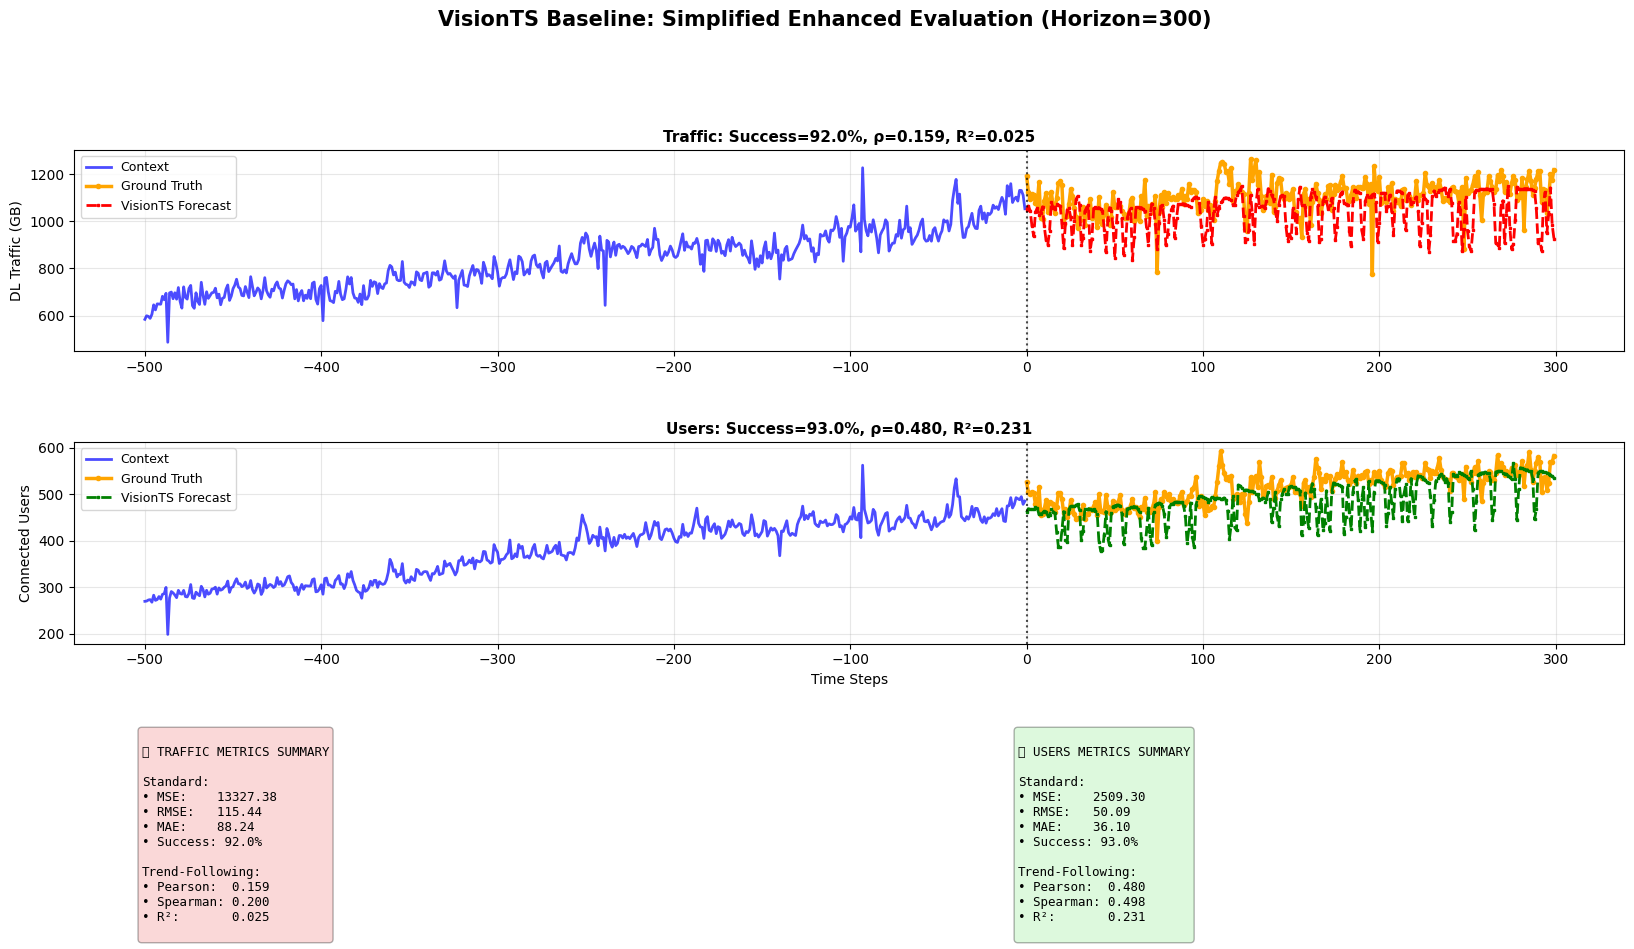


💾 Visualization saved to: baseline_visionts_pred300_simplified_enhanced_results.png


In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from visionts.models_mae import MaskedAutoencoderViT
import warnings
import random
warnings.filterwarnings('ignore')

# ============================================================================
# ⚙️ EXPERIMENT CONFIGURATION - MODIFY HERE FOR EXPERIMENTS
# ============================================================================
CONFIG = {
    # Forecasting Parameters (Common across all methods)
    'PRED_LEN': 300,              # Forecast horizon
    'MIN_CONTEXT_LEN': 600,       # Minimum required training samples
    'CONTEXT_PLOT_LEN': 500,      # Context length shown in plots
    
    # Data Source (Common)
    'DATA_PATH': './long_term_tsf/dataset/Telecom/Site_1.csv',
    'TRAFFIC_COL': 'dl_traffic_volume_gb',
    'USERS_COL': 'connected_users',
    
    # VisionTS-Specific Hyperparameters
    'MASK_RATIO': 0.75,           # MAE masking ratio (0.75-0.90)
    'PERIODICITY': 24,            # Temporal periodicity for reshaping (1, 7, 24, etc.)
    
    # Model Configuration
    'DEVICE': 'cpu',              # 'cpu' or 'cuda'
    'MAE_CHECKPOINT': './ckpt/mae_visualize_vit_base.pth',
    'RANDOM_SEED': 42,            # Reproducibility seed
    
    # Output Settings (Common)
    'SAVE_PLOT': True,
    'PLOT_DPI': 300,
    'OUTPUT_PREFIX': 'baseline_visionts'
}

# ============================================================================
# VISIONTS BASELINE - SIMPLIFIED ENHANCED METRICS
# ============================================================================

def initialize_seeds(seed=42):
    """Ensure reproducibility across runs"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def cal_metrics_simplified(y, forecast):
    """
    Calculate simplified comprehensive metrics:
    - Standard: MSE, MAE, RMSE, Success Rate
    - Trend-Following: Pearson, Spearman, R²
    """
    # ============================================
    # STANDARD METRICS
    # ============================================
    mse = mean_squared_error(y, forecast)
    mae = mean_absolute_error(y, forecast)
    rmse = np.sqrt(mse)
    
    # WMAPE-based success rate
    wmape = np.sum(np.abs(y - forecast)) / (np.sum(np.abs(y)) + 1e-8) * 100
    success = max(0, min(1, (100 - wmape) / 100))
    
    # ============================================
    # TREND-FOLLOWING METRICS
    # ============================================
    
    # Correlation Coefficients
    try:
        pearson_corr, _ = pearsonr(y, forecast)
        spearman_corr, _ = spearmanr(y, forecast)
    except:
        pearson_corr = 0.0
        spearman_corr = 0.0
    
    # R² (Coefficient of Determination)
    r_squared = pearson_corr ** 2 if pearson_corr > 0 else 0.0
    
    return {
        # Standard
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'success_rate': success * 100,
        # Trend-Following
        'pearson_correlation': pearson_corr,
        'spearman_correlation': spearman_corr,
        'r_squared': r_squared
    }

def univariate_visionts_forecast(data, context_len, pred_len, mae_model, periodicity, mask_ratio, device):
    """
    Run univariate VisionTS forecast (grayscale encoding)
    """
    # Prepare full series
    full_series = data[:context_len + pred_len]
    
    # Normalize
    data_min = full_series.min()
    data_max = full_series.max()
    normalized = (full_series - data_min) / (data_max - data_min + 1e-8)
    
    # Create image matrix
    total_len = len(normalized)
    usable_len = total_len - (total_len % periodicity)
    matrix = normalized[:usable_len].reshape(-1, periodicity)
    
    # Convert to grayscale image
    img_array = (matrix * 255).astype(np.uint8)
    img = Image.fromarray(img_array).convert("L")
    
    # Resize to 224x224 for MAE
    img_resized = img.resize((224, 224), Image.BILINEAR)
    img_rgb = img_resized.convert("RGB")
    
    # Run MAE
    x_tensor = ToTensor()(img_rgb).unsqueeze(0).to(device)
    with torch.no_grad():
        latent, mask, ids_restore = mae_model.forward_encoder(x_tensor, mask_ratio=mask_ratio)
        pred = mae_model.forward_decoder(latent, ids_restore)
        output = mae_model.unpatchify(pred).squeeze().permute(1, 2, 0).cpu().numpy()
    
    # Convert back to grayscale
    recon_gray = (output.mean(axis=2) * 255).astype(np.uint8)
    recon_img = Image.fromarray(recon_gray, mode='L')
    
    # Resize back to original matrix size
    recon_resized = recon_img.resize((matrix.shape[1], matrix.shape[0]), Image.BILINEAR)
    recon_matrix = np.array(recon_resized).astype(np.float32) / 255.0
    
    # Flatten and denormalize
    recon_series = recon_matrix.flatten()[:usable_len]
    recon_denorm = recon_series * (data_max - data_min) + data_min
    
    # Extract forecast
    forecast = recon_denorm[-pred_len:]
    
    return forecast

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("⚙️  EXPERIMENT CONFIGURATION")
print("=" * 80)
print(f"Forecast Horizon: {CONFIG['PRED_LEN']} steps")
print(f"VisionTS Parameters:")
print(f"  Mask Ratio: {CONFIG['MASK_RATIO']}")
print(f"  Periodicity: {CONFIG['PERIODICITY']}")
print(f"Device: {CONFIG['DEVICE']}")
print(f"Data: {CONFIG['DATA_PATH']}")
print("=" * 80)

# Initialize seeds
initialize_seeds(CONFIG['RANDOM_SEED'])

# Load data
try:
    df = pd.read_csv(CONFIG['DATA_PATH'])
except FileNotFoundError:
    print(f"❌ Error: Dataset file not found at {CONFIG['DATA_PATH']}")
    exit(1)

PRED_LEN = CONFIG['PRED_LEN']
CONTEXT_LEN = len(df) - PRED_LEN

# Validate data
if CONTEXT_LEN <= 0:
    print(f"❌ Error: PRED_LEN ({PRED_LEN}) exceeds dataset length ({len(df)})")
    exit(1)

if CONTEXT_LEN < CONFIG['MIN_CONTEXT_LEN']:
    print(f"⚠️  Warning: Context length ({CONTEXT_LEN}) < minimum ({CONFIG['MIN_CONTEXT_LEN']})")
    print(f"   This may lead to poor model performance!")

data_traffic = df[CONFIG['TRAFFIC_COL']].values
data_users = df[CONFIG['USERS_COL']].values

# Check for NaN/inf values
if np.any(np.isnan(data_traffic)) or np.any(np.isinf(data_traffic)):
    print("❌ Error: Traffic data contains NaN or Inf values")
    exit(1)

if np.any(np.isnan(data_users)) or np.any(np.isinf(data_users)):
    print("❌ Error: Users data contains NaN or Inf values")
    exit(1)

# Configuration
DEVICE = CONFIG['DEVICE']
MASK_RATIO = CONFIG['MASK_RATIO']
PERIODICITY = CONFIG['PERIODICITY']

print("\n" + "=" * 80)
print("📊 VISIONTS BASELINE - SIMPLIFIED ENHANCED METRICS")
print("=" * 80)
print(f"Context: {CONTEXT_LEN}, Forecast: {PRED_LEN}")
print(f"Mask Ratio: {MASK_RATIO}, Periodicity: {PERIODICITY}")

# Initialize MAE model
try:
    mae_model = MaskedAutoencoderViT(
        img_size=224, patch_size=16, in_chans=3,
        embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
    )
    ckpt = torch.load(CONFIG['MAE_CHECKPOINT'], map_location='cpu')
    mae_model.load_state_dict(ckpt['model'], strict=False)
    mae_model.eval()
    mae_model.to(DEVICE)
    print("✅ MAE model loaded successfully")
except Exception as e:
    print(f"❌ Error loading MAE model: {str(e)}")
    exit(1)

# ============================================================================
# VisionTS for Traffic
# ============================================================================
print("\n🔴 Running VisionTS for Traffic...")

forecast_traffic = univariate_visionts_forecast(
    data_traffic, CONTEXT_LEN, PRED_LEN, 
    mae_model, PERIODICITY, MASK_RATIO, DEVICE
)

# Ground truth
y_traffic = data_traffic[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Calculate metrics
metrics_traffic = cal_metrics_simplified(y_traffic, forecast_traffic)

print(f"\n✅ VisionTS Traffic Results:")
print(f"  Standard Metrics:")
print(f"    MSE:  {metrics_traffic['mse']:.4f}")
print(f"    MAE:  {metrics_traffic['mae']:.4f}")
print(f"    RMSE: {metrics_traffic['rmse']:.4f}")
print(f"    ✅ Success Rate: {metrics_traffic['success_rate']:.2f}%")
print(f"  Trend-Following Metrics:")
print(f"    🔗 Pearson Correlation: {metrics_traffic['pearson_correlation']:.4f}")
print(f"    📊 Spearman Correlation: {metrics_traffic['spearman_correlation']:.4f}")
print(f"    🎲 R²: {metrics_traffic['r_squared']:.4f}")

# ============================================================================
# VisionTS for Users
# ============================================================================
print("\n🟢 Running VisionTS for Users...")

forecast_users = univariate_visionts_forecast(
    data_users, CONTEXT_LEN, PRED_LEN, 
    mae_model, PERIODICITY, MASK_RATIO, DEVICE
)

# Ground truth
y_users = data_users[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# Calculate metrics
metrics_users = cal_metrics_simplified(y_users, forecast_users)

print(f"\n✅ VisionTS Users Results:")
print(f"  Standard Metrics:")
print(f"    MSE:  {metrics_users['mse']:.4f}")
print(f"    MAE:  {metrics_users['mae']:.4f}")
print(f"    RMSE: {metrics_users['rmse']:.4f}")
print(f"    ✅ Success Rate: {metrics_users['success_rate']:.2f}%")
print(f"  Trend-Following Metrics:")
print(f"    🔗 Pearson Correlation: {metrics_users['pearson_correlation']:.4f}")
print(f"    📊 Spearman Correlation: {metrics_users['spearman_correlation']:.4f}")
print(f"    🎲 R²: {metrics_users['r_squared']:.4f}")

# Calculate averages
avg_success = (metrics_traffic['success_rate'] + metrics_users['success_rate']) / 2
avg_corr = (metrics_traffic['pearson_correlation'] + metrics_users['pearson_correlation']) / 2
avg_r2 = (metrics_traffic['r_squared'] + metrics_users['r_squared']) / 2

print(f"\n🎯 Overall VisionTS Performance:")
print(f"  Average Success Rate: {avg_success:.2f}%")
print(f"  Average Pearson Correlation: {avg_corr:.4f}")
print(f"  Average R²: {avg_r2:.4f}")
print("=" * 80)

# ============================================================================
# SAVE SIMPLIFIED ENHANCED METRICS
# ============================================================================
results_df = pd.DataFrame({
    'Method': ['VisionTS'],
    'Pred_Len': [PRED_LEN],
    'Mask_Ratio': [MASK_RATIO],
    'Periodicity': [PERIODICITY],
    # Traffic - Standard
    'Traffic_MSE': [metrics_traffic['mse']],
    'Traffic_MAE': [metrics_traffic['mae']],
    'Traffic_RMSE': [metrics_traffic['rmse']],
    'Traffic_Success_%': [metrics_traffic['success_rate']],
    # Traffic - Trend-Following
    'Traffic_Pearson': [metrics_traffic['pearson_correlation']],
    'Traffic_Spearman': [metrics_traffic['spearman_correlation']],
    'Traffic_R2': [metrics_traffic['r_squared']],
    # Users - Standard
    'Users_MSE': [metrics_users['mse']],
    'Users_MAE': [metrics_users['mae']],
    'Users_RMSE': [metrics_users['rmse']],
    'Users_Success_%': [metrics_users['success_rate']],
    # Users - Trend-Following
    'Users_Pearson': [metrics_users['pearson_correlation']],
    'Users_Spearman': [metrics_users['spearman_correlation']],
    'Users_R2': [metrics_users['r_squared']],
    # Overall
    'Avg_Success_%': [avg_success],
    'Avg_Correlation': [avg_corr],
    'Avg_R2': [avg_r2]
})

output_csv = f"{CONFIG['OUTPUT_PREFIX']}_simplified_enhanced_metrics.csv"
results_df.to_csv(output_csv, index=False)
print(f"\n💾 Simplified enhanced metrics saved to: {output_csv}")

# ============================================================================
# ENHANCED VISUALIZATION
# ============================================================================
if CONFIG['SAVE_PLOT']:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 2, hspace=0.45, wspace=0.3)
    
    # Forecasts
    context_plot = min(CONFIG['CONTEXT_PLOT_LEN'], CONTEXT_LEN)
    time_x = range(-context_plot, 0)
    time_y = range(0, PRED_LEN)
    
    # Panel 1: Traffic Forecast
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time_x, data_traffic[CONTEXT_LEN-context_plot:CONTEXT_LEN], 'b-', linewidth=2, label='Context', alpha=0.7)
    ax1.plot(time_y, y_traffic, 'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax1.plot(time_y, forecast_traffic, 'r--', linewidth=2, label='VisionTS Forecast', marker='s', markersize=2)
    ax1.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax1.set_title(f'Traffic: Success={metrics_traffic["success_rate"]:.1f}%, ρ={metrics_traffic["pearson_correlation"]:.3f}, R²={metrics_traffic["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax1.set_ylabel('DL Traffic (GB)', fontsize=10)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Panel 2: Users Forecast
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(time_x, data_users[CONTEXT_LEN-context_plot:CONTEXT_LEN], 'b-', linewidth=2, label='Context', alpha=0.7)
    ax2.plot(time_y, y_users, 'orange', linewidth=2.5, label='Ground Truth', marker='o', markersize=3)
    ax2.plot(time_y, forecast_users, 'g--', linewidth=2, label='VisionTS Forecast', marker='s', markersize=2)
    ax2.axvline(x=0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
    ax2.set_title(f'Users: Success={metrics_users["success_rate"]:.1f}%, ρ={metrics_users["pearson_correlation"]:.3f}, R²={metrics_users["r_squared"]:.3f}', 
                 fontweight='bold', fontsize=11)
    ax2.set_xlabel('Time Steps', fontsize=10)
    ax2.set_ylabel('Connected Users', fontsize=10)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(alpha=0.3)
    
    # Panel 3: Metrics Summary (Traffic)
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.axis('off')
    traffic_text = f"""
🔴 TRAFFIC METRICS SUMMARY

Standard:
• MSE:    {metrics_traffic['mse']:.2f}
• RMSE:   {metrics_traffic['rmse']:.2f}
• MAE:    {metrics_traffic['mae']:.2f}
• Success: {metrics_traffic['success_rate']:.1f}%

Trend-Following:
• Pearson:  {metrics_traffic['pearson_correlation']:.3f}
• Spearman: {metrics_traffic['spearman_correlation']:.3f}
• R²:       {metrics_traffic['r_squared']:.3f}
"""
    ax3.text(0.1, 0.5, traffic_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
    
    # Panel 4: Metrics Summary (Users)
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.axis('off')
    users_text = f"""
🟢 USERS METRICS SUMMARY

Standard:
• MSE:    {metrics_users['mse']:.2f}
• RMSE:   {metrics_users['rmse']:.2f}
• MAE:    {metrics_users['mae']:.2f}
• Success: {metrics_users['success_rate']:.1f}%

Trend-Following:
• Pearson:  {metrics_users['pearson_correlation']:.3f}
• Spearman: {metrics_users['spearman_correlation']:.3f}
• R²:       {metrics_users['r_squared']:.3f}
"""
    ax4.text(0.1, 0.5, users_text, fontsize=9, family='monospace', verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    plt.suptitle(f'VisionTS Baseline: Simplified Enhanced Evaluation (Horizon={PRED_LEN})', fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    output_file = f"{CONFIG['OUTPUT_PREFIX']}_pred{PRED_LEN}_simplified_enhanced_results.png"
    plt.savefig(output_file, dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Visualization saved to: {output_file}")
else:
    print("\n⚠️  Plot saving disabled in configuration")

print("=" * 80)

## 📊 COMPREHENSIVE COMPARISON (All Baselines + BiViSIONTS)

⚙️  EXPERIMENT CONFIGURATION
Loading results from:
  ARIMA: baseline_arima_simplified_enhanced_metrics.csv
  LSTM: baseline_lstm_simplified_enhanced_metrics.csv
  VAR: baseline_var_simplified_enhanced_metrics.csv
  VisionTS: baseline_visionts_simplified_enhanced_metrics.csv
  BiViSIONTS: bivisionts_simplified_enhanced_metrics.csv

CPI Weights:
  MSE: 0.14 (14%)
  MAE: 0.14 (14%)
  RMSE: 0.14 (14%)
  SUCCESS: 0.16 (16%)
  PEARSON: 0.14 (14%)
  SPEARMAN: 0.14 (14%)
  R2: 0.14 (14%)

📊 COMPREHENSIVE COMPARISON: SIMPLIFIED ENHANCED (7 METRICS)
✅ ARIMA results loaded with simplified enhanced metrics (7 per variable)
✅ LSTM results loaded with simplified enhanced metrics (7 per variable)
✅ VAR results loaded with simplified enhanced metrics (7 per variable)
✅ VisionTS results loaded with simplified enhanced metrics (7 per variable)
✅ BiViSIONTS results loaded with simplified enhanced metrics (7 per variable)

🔬 Calculating Simplified CPI (7 metrics per variable)...

📊 COMPREHENSIVE SIMPLIFIE

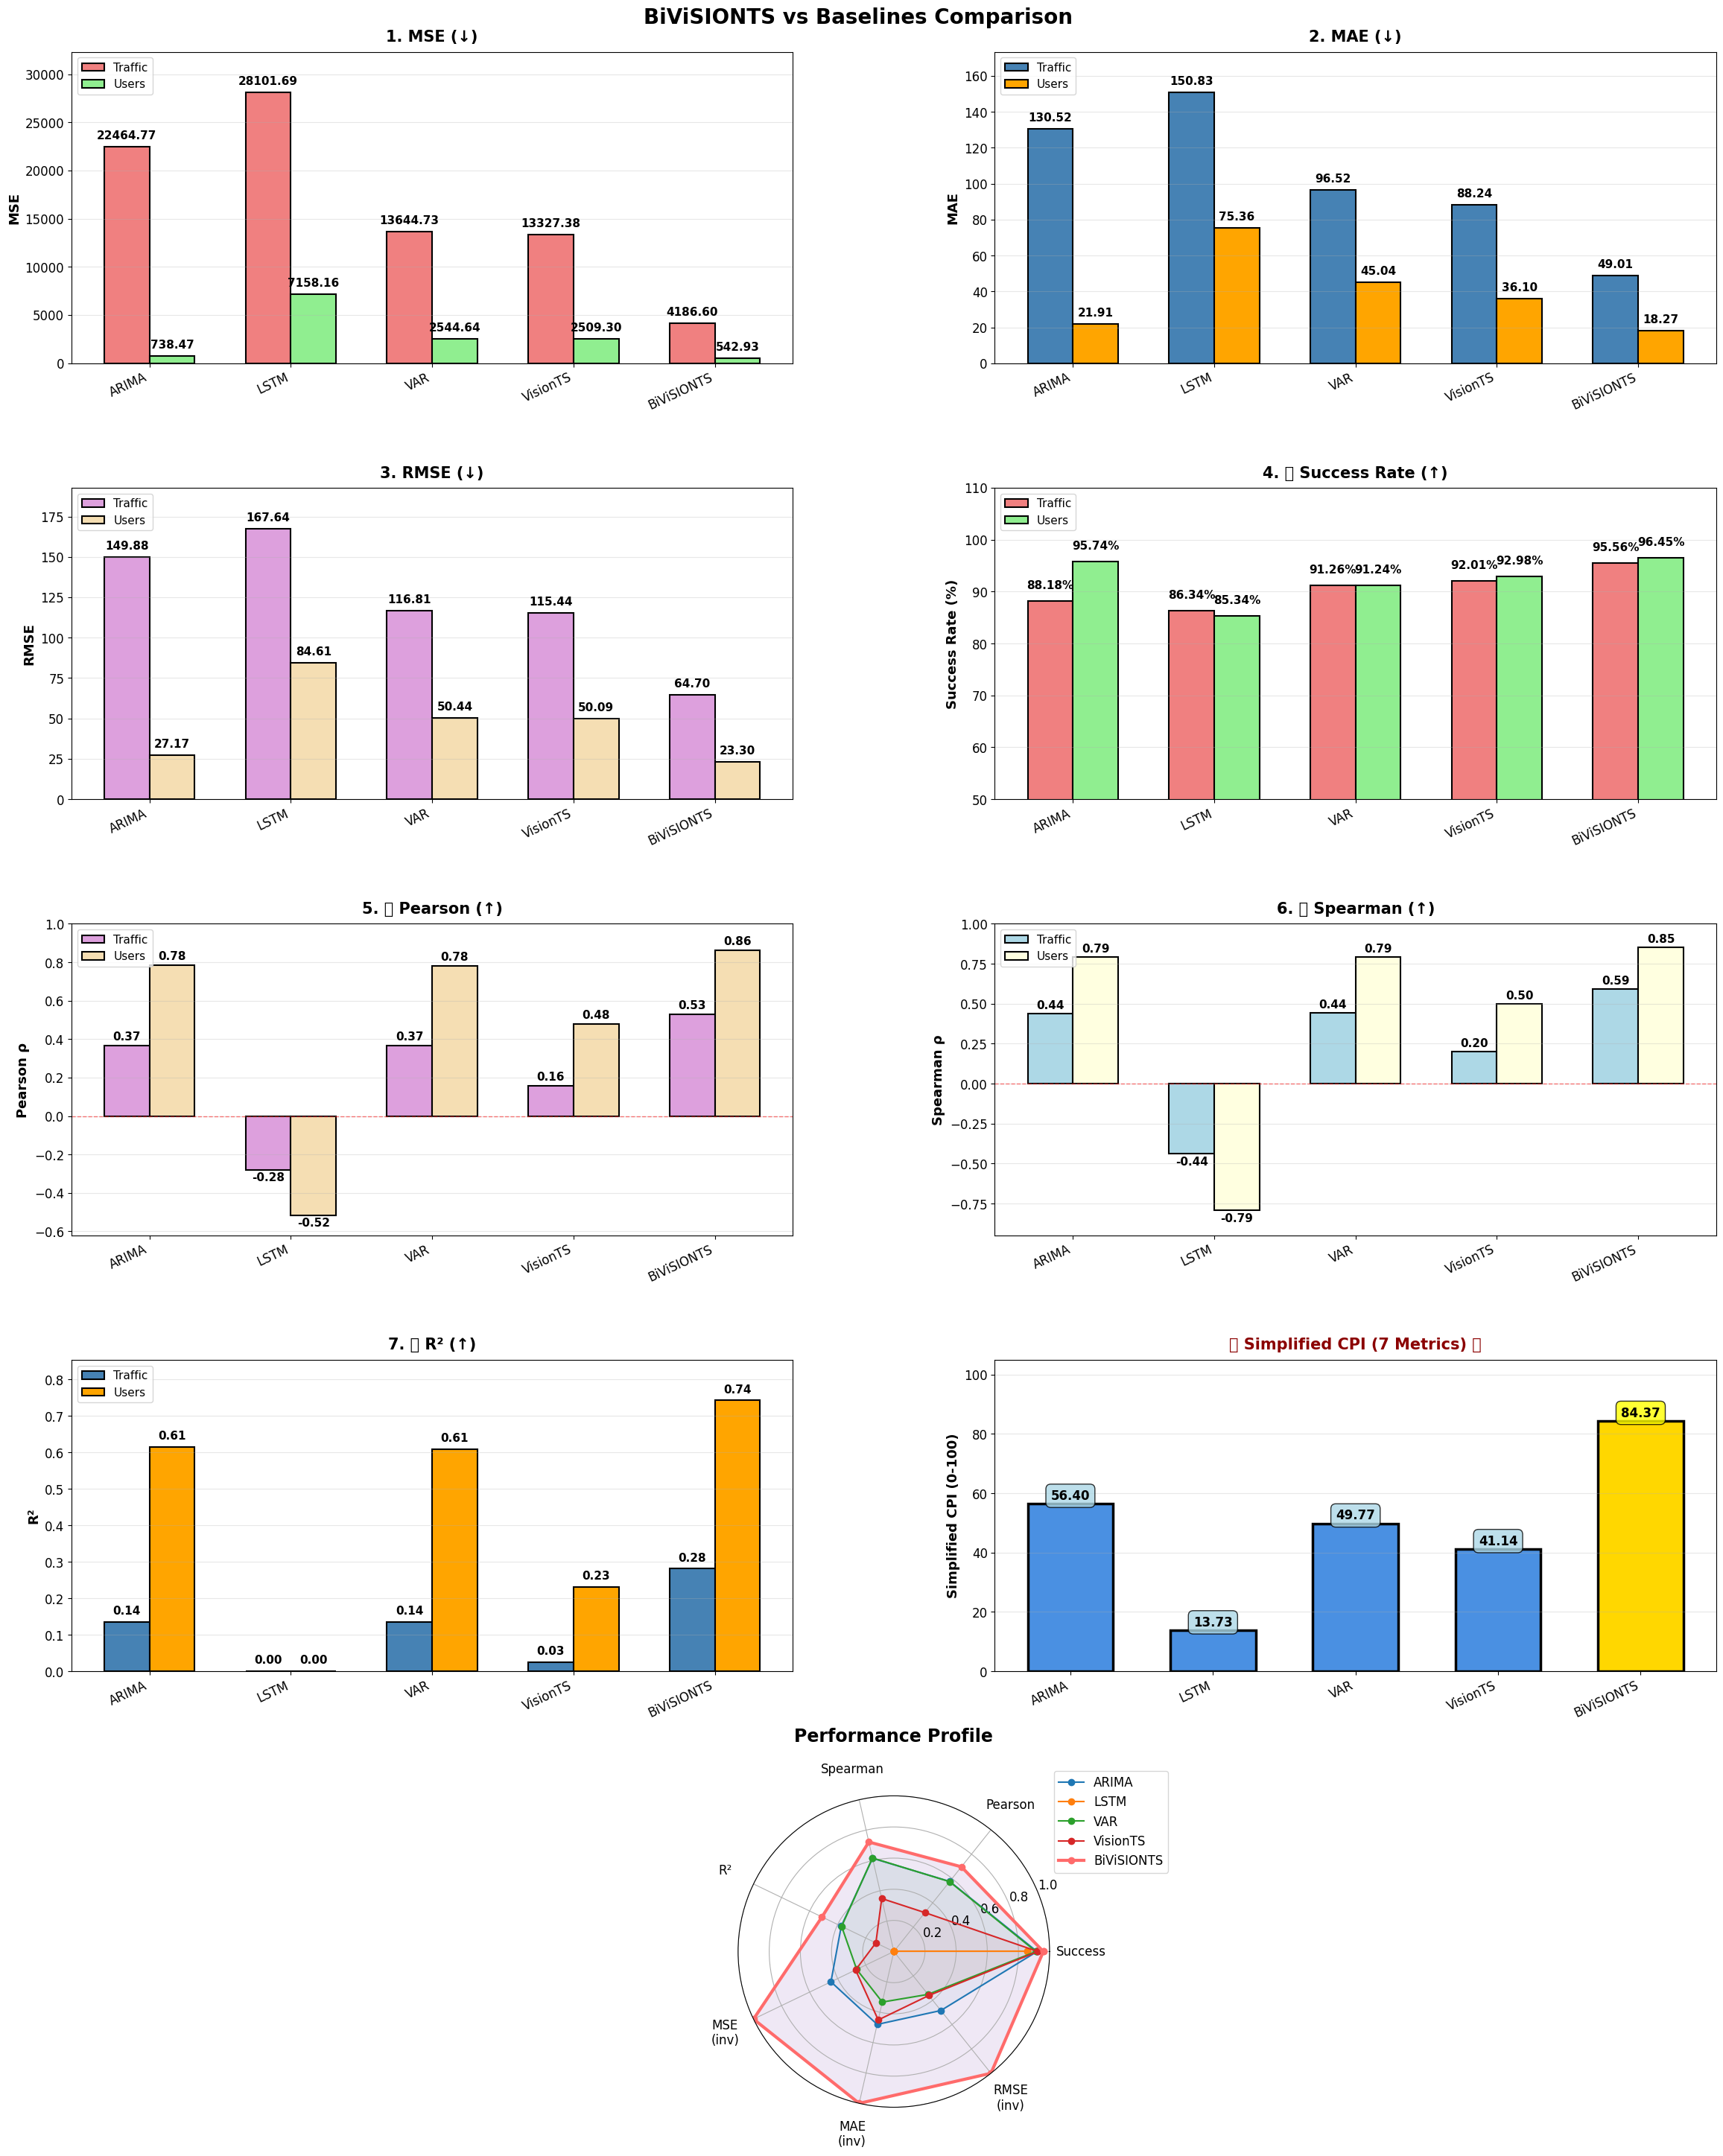


💾 Simplified comparison saved to: comprehensive_simplified_enhanced_cpi_comparison.png (Grid: 5×2, DPI=300)
💾 Simplified table saved to: comprehensive_simplified_enhanced_cpi_table.csv

📊 SIMPLIFIED ENHANCED STATISTICAL SUMMARY:

ARIMA:
  Standard: MSE=22464.769/738.47, MAE=130.515/21.91, Success=91.961%
  Trend: ρ=0.576, R²=0.375, CPI=56.399/100

LSTM:
  Standard: MSE=28101.687/7158.16, MAE=150.832/75.36, Success=85.844%
  Trend: ρ=-0.399, R²=0.000, CPI=13.735/100

VAR:
  Standard: MSE=13644.733/2544.64, MAE=96.517/45.04, Success=91.251%
  Trend: ρ=0.574, R²=0.372, CPI=49.771/100

VisionTS:
  Standard: MSE=13327.381/2509.30, MAE=88.235/36.10, Success=92.495%
  Trend: ρ=0.320, R²=0.128, CPI=41.136/100

BiViSIONTS:
  Standard: MSE=4186.598/542.93, MAE=49.009/18.27, Success=96.005%
  Trend: ρ=0.696, R²=0.512, CPI=84.375/100

🏆 WINNER: BiViSIONTS (CPI=84.375/100)
   Success=96.005%, ρ=0.696, R²=0.512

✨ SIMPLIFIED CPI FORMULA (7 Metrics):
   Standard (58%): 14%×MSE + 14%×MAE + 14%×RMSE +

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ⚙️ EXPERIMENT CONFIGURATION - MODIFY HERE FOR EXPERIMENTS
# ============================================================================
CONFIG = {
    # Input CSV Files (change these if you use different filenames)
    'ARIMA_CSV': 'baseline_arima_simplified_enhanced_metrics.csv',
    'LSTM_CSV': 'baseline_lstm_simplified_enhanced_metrics.csv',
    'VAR_CSV': 'baseline_var_simplified_enhanced_metrics.csv',
    'VISIONTS_CSV': 'baseline_visionts_simplified_enhanced_metrics.csv',  # ✅ ADDED
    'BIVISIONTS_CSV': 'bivisionts_simplified_enhanced_metrics.csv',
    
    'CPI_WEIGHTS': {
        'mse'     :0.14,
        'mae'     :0.14,
        'rmse'    :0.14,
        'success' :0.16,
        'pearson' :0.14,
        'spearman':0.14,
        'r2'      :0.14,
    },
    
    # Plot Configuration
    'figure_width': 24,
    'figure_height': 30,
    'grid_cols': 2,
    'dpi': 300,
    
    'font_title': 15,
    'font_label': 13,
    'font_tick': 12,
    'font_legend': 11,
    'font_value': 11,
    'font_suptitle': 20,
    
    # Output Settings
    'SAVE_PLOT': True,
    'OUTPUT_PLOT': 'comprehensive_simplified_enhanced_cpi_comparison.png',
    'OUTPUT_CSV': 'comprehensive_simplified_enhanced_cpi_table.csv'
}

# ============================================================================
# COMPREHENSIVE BASELINE COMPARISON - SIMPLIFIED (7 METRICS)
# ============================================================================

def load_simplified_enhanced_results(method_name, csv_path):
    """Load simplified enhanced metrics from CSV (7 metrics per variable)"""
    try:
        df = pd.read_csv(csv_path)
        
        results = {
            'traffic_mse': df['Traffic_MSE'].values[0],
            'traffic_mae': df['Traffic_MAE'].values[0],
            'traffic_rmse': df['Traffic_RMSE'].values[0],
            'traffic_success': df['Traffic_Success_%'].values[0],
            'traffic_pearson': df['Traffic_Pearson'].values[0],
            'traffic_spearman': df['Traffic_Spearman'].values[0],
            'traffic_r2': df['Traffic_R2'].values[0],
            'users_mse': df['Users_MSE'].values[0],
            'users_mae': df['Users_MAE'].values[0],
            'users_rmse': df['Users_RMSE'].values[0],
            'users_success': df['Users_Success_%'].values[0],
            'users_pearson': df['Users_Pearson'].values[0],
            'users_spearman': df['Users_Spearman'].values[0],
            'users_r2': df['Users_R2'].values[0],
            'avg_success': df['Avg_Success_%'].values[0],
            'avg_correlation': df['Avg_Correlation'].values[0],
            'avg_r2': df['Avg_R2'].values[0]
        }
        
        print(f"✅ {method_name} results loaded with simplified enhanced metrics (7 per variable)")
        return results
        
    except FileNotFoundError:
        print(f"❌ {method_name} results not found: {csv_path}")
        print(f"   Please run the {method_name} baseline script first to generate results.")
        return None
    except Exception as e:
        print(f"⚠️  {method_name} error loading results: {e}")
        return None

def calculate_normalized_scores_simplified(results_dict):
    """Simplified normalization for 7 metrics per variable"""
    methods = list(results_dict.keys())
    
    metrics_arrays = {
        'traffic_mse': np.array([results_dict[m]['traffic_mse'] for m in methods]),
        'traffic_mae': np.array([results_dict[m]['traffic_mae'] for m in methods]),
        'traffic_rmse': np.array([results_dict[m]['traffic_rmse'] for m in methods]),
        'traffic_success': np.array([results_dict[m]['traffic_success'] for m in methods]),
        'traffic_pearson': np.array([results_dict[m]['traffic_pearson'] for m in methods]),
        'traffic_spearman': np.array([results_dict[m]['traffic_spearman'] for m in methods]),
        'traffic_r2': np.array([results_dict[m]['traffic_r2'] for m in methods]),
        'users_mse': np.array([results_dict[m]['users_mse'] for m in methods]),
        'users_mae': np.array([results_dict[m]['users_mae'] for m in methods]),
        'users_rmse': np.array([results_dict[m]['users_rmse'] for m in methods]),
        'users_success': np.array([results_dict[m]['users_success'] for m in methods]),
        'users_pearson': np.array([results_dict[m]['users_pearson'] for m in methods]),
        'users_spearman': np.array([results_dict[m]['users_spearman'] for m in methods]),
        'users_r2': np.array([results_dict[m]['users_r2'] for m in methods]),
    }
    
    def normalize_error_inverse(arr):
        """Lower error → higher score"""
        best = arr.min()
        if best == 0:
            best = 1e-6
        scores = 1 / (1 + arr / best)
        return (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
    
    norm_scores = {}
    for i, method in enumerate(methods):
        norm_scores[method] = {
            'traffic_mse_norm': normalize_error_inverse(metrics_arrays['traffic_mse'])[i],
            'traffic_mae_norm': normalize_error_inverse(metrics_arrays['traffic_mae'])[i],
            'traffic_rmse_norm': normalize_error_inverse(metrics_arrays['traffic_rmse'])[i],
            'users_mse_norm': normalize_error_inverse(metrics_arrays['users_mse'])[i],
            'users_mae_norm': normalize_error_inverse(metrics_arrays['users_mae'])[i],
            'users_rmse_norm': normalize_error_inverse(metrics_arrays['users_rmse'])[i],
            'traffic_success_norm': metrics_arrays['traffic_success'][i] / 100.0,
            'traffic_pearson_norm': max(0, metrics_arrays['traffic_pearson'][i]),
            'traffic_spearman_norm': max(0, metrics_arrays['traffic_spearman'][i]),
            'traffic_r2_norm': max(0, metrics_arrays['traffic_r2'][i]),
            'users_success_norm': metrics_arrays['users_success'][i] / 100.0,
            'users_pearson_norm': max(0, metrics_arrays['users_pearson'][i]),
            'users_spearman_norm': max(0, metrics_arrays['users_spearman'][i]),
            'users_r2_norm': max(0, metrics_arrays['users_r2'][i]),
        }
    
    return norm_scores

def calculate_cpi_simplified(norm_scores, weights=None):
    """Calculate Simplified CPI (7 metrics per variable)"""
    if weights is None:
        weights = CONFIG['CPI_WEIGHTS']
    
    cpi_scores = {}
    for method, scores in norm_scores.items():
        cpi = (
            weights['mse'] * (scores['traffic_mse_norm'] + scores['users_mse_norm']) / 2 +
            weights['mae'] * (scores['traffic_mae_norm'] + scores['users_mae_norm']) / 2 +
            weights['rmse'] * (scores['traffic_rmse_norm'] + scores['users_rmse_norm']) / 2 +
            weights['success'] * (scores['traffic_success_norm'] + scores['users_success_norm']) / 2 +
            weights['pearson'] * (scores['traffic_pearson_norm'] + scores['users_pearson_norm']) / 2 +
            weights['spearman'] * (scores['traffic_spearman_norm'] + scores['users_spearman_norm']) / 2 +
            weights['r2'] * (scores['traffic_r2_norm'] + scores['users_r2_norm']) / 2
        )
        cpi_scores[method] = cpi * 100
    
    return cpi_scores

def style_bar_plot(ax, title, ylabel, traffic_data, users_data, t_color, u_color, methods, is_pct=False):
    """Common styling for bar plots - UPDATED to accept dynamic methods list"""
    x_pos = np.arange(len(methods))
    width = 0.32
    
    ax.bar(x_pos - width/2, traffic_data, width, label='Traffic', color=t_color, edgecolor='black', linewidth=1.5)
    ax.bar(x_pos + width/2, users_data, width, label='Users', color=u_color, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(ylabel, fontsize=CONFIG['font_label'], fontweight='bold')
    ax.set_title(title, fontsize=CONFIG['font_title'], fontweight='bold', pad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(methods, rotation=25, ha='right', fontsize=CONFIG['font_tick'])
    ax.legend(fontsize=CONFIG['font_legend'], loc='upper left')
    ax.grid(alpha=0.3, axis='y')
    ax.tick_params(axis='y', labelsize=CONFIG['font_tick'])
    
    max_val = max(max(traffic_data), max(users_data))
    min_val = min(min(traffic_data), min(users_data))
    
    # Handle negative values (e.g., negative R²)
    if min_val < 0:
        y_min = min_val * 1.2
        y_max = max(max_val * 1.15, 1.0)
    elif 'Success Rate' in title:
        y_min = 50
        y_max = 110
    else:
        y_min = 0
        y_max = max_val * 1.15 if not is_pct else 105
    
    ax.set_ylim([y_min, y_max])
    
    # Add value labels
    for i, (t, u) in enumerate(zip(traffic_data, users_data)):
        if t >= 0:
            y_offset_t = max_val * 0.02
            va_t = 'bottom'
        else:
            y_offset_t = min_val * 0.02
            va_t = 'top'
        
        if u >= 0:
            y_offset_u = max_val * 0.02
            va_u = 'bottom'
        else:
            y_offset_u = min_val * 0.02
            va_u = 'top'
        
        fmt_t = f'{t:.2f}%' if is_pct else f'{t:.2f}'
        fmt_u = f'{u:.2f}%' if is_pct else f'{u:.2f}'
        
        ax.text(i - width/2, t + y_offset_t, fmt_t, ha='center', va=va_t,
                fontsize=CONFIG['font_value'], fontweight='bold')
        ax.text(i + width/2, u + y_offset_u, fmt_u, ha='center', va=va_u,
                fontsize=CONFIG['font_value'], fontweight='bold')
    
    if min_val < 0:
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("⚙️  EXPERIMENT CONFIGURATION")
print("=" * 80)
print(f"Loading results from:")
print(f"  ARIMA: {CONFIG['ARIMA_CSV']}")
print(f"  LSTM: {CONFIG['LSTM_CSV']}")
print(f"  VAR: {CONFIG['VAR_CSV']}")
print(f"  VisionTS: {CONFIG['VISIONTS_CSV']}")  # ✅ ADDED
print(f"  BiViSIONTS: {CONFIG['BIVISIONTS_CSV']}")
print("\nCPI Weights:")
for metric, weight in CONFIG['CPI_WEIGHTS'].items():
    print(f"  {metric.upper()}: {weight:.2f} ({weight*100:.0f}%)")
print("=" * 80)

print("\n" + "=" * 80)
print("📊 COMPREHENSIVE COMPARISON: SIMPLIFIED ENHANCED (7 METRICS)")
print("=" * 80)

all_results = {}

# Load results with configured filenames
arima_results = load_simplified_enhanced_results('ARIMA', CONFIG['ARIMA_CSV'])
if arima_results:
    all_results['ARIMA'] = arima_results

lstm_results = load_simplified_enhanced_results('LSTM', CONFIG['LSTM_CSV'])
if lstm_results:
    all_results['LSTM'] = lstm_results

var_results = load_simplified_enhanced_results('VAR', CONFIG['VAR_CSV'])
if var_results:
    all_results['VAR'] = var_results

# ✅ LOAD VISIONTS RESULTS
visionts_results = load_simplified_enhanced_results('VisionTS', CONFIG['VISIONTS_CSV'])
if visionts_results:
    all_results['VisionTS'] = visionts_results

bivisionts_results = load_simplified_enhanced_results('BiViSIONTS', CONFIG['BIVISIONTS_CSV'])
if bivisionts_results:
    all_results['BiViSIONTS'] = bivisionts_results

# Check if we have at least 2 methods for comparison
if len(all_results) < 2:
    print("\n❌ Error: Need at least 2 methods loaded for comparison.")
    print("   Please run the baseline scripts to generate results first.")
    exit(1)

print("\n🔬 Calculating Simplified CPI (7 metrics per variable)...")
norm_scores = calculate_normalized_scores_simplified(all_results)
cpi_scores = calculate_cpi_simplified(norm_scores)

for method in all_results.keys():
    all_results[method]['cpi'] = cpi_scores[method]

comparison_df = pd.DataFrame([
    {
        'Method': method,
        'Traffic_MSE': data['traffic_mse'],
        'Traffic_MAE': data['traffic_mae'],
        'Traffic_RMSE': data['traffic_rmse'],
        'Traffic_Success_%': data['traffic_success'],
        'Traffic_Pearson': data['traffic_pearson'],
        'Traffic_Spearman': data['traffic_spearman'],
        'Traffic_R2': data['traffic_r2'],
        'Users_MSE': data['users_mse'],
        'Users_MAE': data['users_mae'],
        'Users_RMSE': data['users_rmse'],
        'Users_Success_%': data['users_success'],
        'Users_Pearson': data['users_pearson'],
        'Users_Spearman': data['users_spearman'],
        'Users_R2': data['users_r2'],
        'Avg_Success_%': data['avg_success'],
        'Avg_Correlation': data['avg_correlation'],
        'Avg_R2': data['avg_r2'],
        'CPI_Score': data['cpi']
    }
    for method, data in all_results.items()
]).sort_values('CPI_Score', ascending=False)

print("\n" + "=" * 140)
print("📊 COMPREHENSIVE SIMPLIFIED ENHANCED METRICS COMPARISON TABLE")
print("=" * 140)

print("\n🔹 STANDARD METRICS:")
print(comparison_df[['Method', 'Traffic_MSE', 'Traffic_MAE', 'Traffic_RMSE', 'Traffic_Success_%',
                     'Users_MSE', 'Users_MAE', 'Users_RMSE', 'Users_Success_%', 'Avg_Success_%']].to_string(index=False))

print("\n🔹 TREND-FOLLOWING METRICS:")
print(comparison_df[['Method', 'Traffic_Pearson', 'Traffic_Spearman', 'Traffic_R2',
                     'Users_Pearson', 'Users_Spearman', 'Users_R2', 
                     'Avg_Correlation', 'Avg_R2']].to_string(index=False))

print("\n🔹 COMPOSITE PERFORMANCE INDEX:")
print(comparison_df[['Method', 'CPI_Score']].to_string(index=False))
print("=" * 140)

# ============================================================================
# SIMPLIFIED ENHANCED VISUALIZATION
# ============================================================================

if CONFIG['SAVE_PLOT']:
    n_metric_plots = 7
    n_special_plots = 2
    total_plots = n_metric_plots + n_special_plots

    grid_cols = CONFIG['grid_cols']
    grid_rows = int(np.ceil(total_plots / grid_cols))

    print(f"\n📐 Dynamic Grid: {grid_rows} rows × {grid_cols} columns (Total plots: {total_plots})")

    fig = plt.figure(figsize=(CONFIG['figure_width'], CONFIG['figure_height']))
    gs = fig.add_gridspec(grid_rows, grid_cols, 
                          hspace=0.40, wspace=0.28,
                          left=0.06, right=0.98, top=0.96, bottom=0.04)

    methods = list(all_results.keys())  # ✅ Dynamic methods list
    x_pos = np.arange(len(methods))
    width = 0.32

    # Define metric plots
    metric_plots = [
        (0, '1. MSE (↓)', 'MSE', 'traffic_mse', 'users_mse', 'lightcoral', 'lightgreen', False),
        (1, '2. MAE (↓)', 'MAE', 'traffic_mae', 'users_mae', 'steelblue', 'orange', False),
        (2, '3. RMSE (↓)', 'RMSE', 'traffic_rmse', 'users_rmse', 'plum', 'wheat', False),
        (3, '4. ✅ Success Rate (↑)', 'Success Rate (%)', 'traffic_success', 'users_success', 'lightcoral', 'lightgreen', True),
        (4, '5. 🔗 Pearson (↑)', 'Pearson ρ', 'traffic_pearson', 'users_pearson', 'plum', 'wheat', False),
        (5, '6. 📊 Spearman (↑)', 'Spearman ρ', 'traffic_spearman', 'users_spearman', 'lightblue', 'lightyellow', False),
        (6, '7. 🎲 R² (↑)', 'R²', 'traffic_r2', 'users_r2', 'steelblue', 'orange', False),
    ]

    # Generate metric plots
    for plot_idx, title, ylabel, t_key, u_key, t_color, u_color, is_pct in metric_plots:
        row = plot_idx // grid_cols
        col = plot_idx % grid_cols
        ax = fig.add_subplot(gs[row, col])
        
        style_bar_plot(ax, title, ylabel,
                       [all_results[m][t_key] for m in methods],
                       [all_results[m][u_key] for m in methods],
                       t_color, u_color, methods, is_pct)  # ✅ Pass methods list

    # CPI Ranking
    cpi_idx = 7
    row = cpi_idx // grid_cols
    col = cpi_idx % grid_cols
    ax8 = fig.add_subplot(gs[row, col])
    cpi_values = [all_results[m]['cpi'] for m in methods]
    colors_cpi = ['#FFD700' if m == 'BiViSIONTS' else '#4a90e2' for m in methods]
    ax8.bar(methods, cpi_values, color=colors_cpi, edgecolor='black', linewidth=2.5, width=0.6)
    ax8.set_ylabel('Simplified CPI (0-100)', fontsize=CONFIG['font_label'], fontweight='bold')
    ax8.set_title('⭐ Simplified CPI (7 Metrics) ⭐', fontweight='bold', fontsize=CONFIG['font_title'], color='darkred', pad=10)
    ax8.tick_params(axis='x', rotation=25, labelsize=CONFIG['font_tick'])
    ax8.tick_params(axis='y', labelsize=CONFIG['font_tick'])
    plt.setp(ax8.get_xticklabels(), ha='right')
    ax8.grid(alpha=0.3, axis='y')
    ax8.set_ylim([0, 105])

    for i, (method, cpi) in enumerate(zip(methods, cpi_values)):
        ax8.text(i, cpi + 1.5, f'{cpi:.2f}', ha='center', fontsize=CONFIG['font_value']+1, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow' if method == 'BiViSIONTS' else 'lightblue', alpha=0.8))

    # Radar Chart
    radar_idx = 8
    row = radar_idx // grid_cols
    col = radar_idx % grid_cols
    remaining_cols = grid_cols - col

    ax9 = fig.add_subplot(gs[row, col:col+remaining_cols], projection='polar')
    categories = ['Success', 'Pearson', 'Spearman', 'R²', 'MSE\n(inv)', 'MAE\n(inv)', 'RMSE\n(inv)']
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    for method in methods:
        scores = norm_scores[method]
        values = [
            (scores['traffic_success_norm'] + scores['users_success_norm']) / 2,
            (scores['traffic_pearson_norm'] + scores['users_pearson_norm']) / 2,
            (scores['traffic_spearman_norm'] + scores['users_spearman_norm']) / 2,
            (scores['traffic_r2_norm'] + scores['users_r2_norm']) / 2,
            (scores['traffic_mse_norm'] + scores['users_mse_norm']) / 2,
            (scores['traffic_mae_norm'] + scores['users_mae_norm']) / 2,
            (scores['traffic_rmse_norm'] + scores['users_rmse_norm']) / 2
        ]
        values += values[:1]
        
        color = '#ff6b6b' if method == 'BiViSIONTS' else None
        linewidth = 3 if method == 'BiViSIONTS' else 1.5
        
        ax9.plot(angles, values, 'o-', linewidth=linewidth, label=method, color=color)
        ax9.fill(angles, values, alpha=0.15 if method == 'BiViSIONTS' else 0.05)

    ax9.set_xticks(angles[:-1])
    ax9.set_xticklabels(categories, fontsize=CONFIG['font_tick'])
    ax9.set_ylim(0, 1)
    ax9.tick_params(pad=20)

    ax9.set_title('Performance Profile', fontweight='bold', pad=20, fontsize=CONFIG['font_title']+2)
    ax9.legend(loc='upper right', bbox_to_anchor=(1.40, 1.1), fontsize=CONFIG['font_legend']+1)
    ax9.grid(True)
    ax9.tick_params(labelsize=CONFIG['font_tick'])

    plt.suptitle('BiViSIONTS vs Baselines Comparison', fontsize=CONFIG['font_suptitle'], fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(CONFIG['OUTPUT_PLOT'], dpi=CONFIG['dpi'], bbox_inches='tight')
    plt.show()

    print(f"\n💾 Simplified comparison saved to: {CONFIG['OUTPUT_PLOT']} (Grid: {grid_rows}×{grid_cols}, DPI={CONFIG['dpi']})")

comparison_df.to_csv(CONFIG['OUTPUT_CSV'], index=False)
print(f"💾 Simplified table saved to: {CONFIG['OUTPUT_CSV']}")

print("\n📊 SIMPLIFIED ENHANCED STATISTICAL SUMMARY:")
print("=" * 140)

for method in methods:
    print(f"\n{method}:")
    print(f"  Standard: MSE={all_results[method]['traffic_mse']:.3f}/{all_results[method]['users_mse']:.2f}, "
          f"MAE={all_results[method]['traffic_mae']:.3f}/{all_results[method]['users_mae']:.2f}, "
          f"Success={all_results[method]['avg_success']:.3f}%")
    print(f"  Trend: ρ={all_results[method]['avg_correlation']:.3f}, "
          f"R²={all_results[method]['avg_r2']:.3f}, CPI={all_results[method]['cpi']:.3f}/100")

print("\n" + "=" * 140)
print(f"🏆 WINNER: {comparison_df.iloc[0]['Method']} (CPI={comparison_df.iloc[0]['CPI_Score']:.3f}/100)")
print(f"   Success={comparison_df.iloc[0]['Avg_Success_%']:.3f}%, ρ={comparison_df.iloc[0]['Avg_Correlation']:.3f}, R²={comparison_df.iloc[0]['Avg_R2']:.3f}")
print("=" * 140)

weights = CONFIG['CPI_WEIGHTS']
print("\n✨ SIMPLIFIED CPI FORMULA (7 Metrics):")
print(f"   Standard ({(weights['mse']+weights['mae']+weights['rmse']+weights['success'])*100:.0f}%): "
      f"{weights['mse']*100:.0f}%×MSE + {weights['mae']*100:.0f}%×MAE + {weights['rmse']*100:.0f}%×RMSE + {weights['success']*100:.0f}%×Success")
print(f"   Trend-Following ({(weights['pearson']+weights['spearman']+weights['r2'])*100:.0f}%): "
      f"{weights['pearson']*100:.0f}%×Pearson + {weights['spearman']*100:.0f}%×Spearman + {weights['r2']*100:.0f}%×R²")
print("=" * 140)